In [222]:
# !pip install catboost
# !pip install scrapy
# !pip install tqdm
# !pip install xgboost
# !pip install lightgbm

In [224]:
import numpy as np
import pandas as pd

import re
import json

from collections import Counter
from datetime import date
from itertools import chain

import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

import sys
from tqdm.notebook import tqdm
from joblib import Parallel, delayed # parallel computing for loops
from tqdm import tqdm # progress bar

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import f_classif, mutual_info_classif

from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (ExtraTreesRegressor, RandomForestRegressor,
                              GradientBoostingRegressor, StackingRegressor)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# from gensim.models import Word2Vec
# from sklearn.manifold import TSNE

from imblearn.under_sampling import RandomUnderSampler


!pip freeze > requirements.txt
RANDOM_SEED = 42


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings("ignore")

## Import: Test dataset

In [3]:
test = pd.read_csv('data/test.csv')

display(test.head(3), test.shape)

bodyType  brand                                            car_url   color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   синий   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  чёрный   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   серый   

                                  complectation_dict  \
0                                                NaN   
1                                                NaN   
2  {"id":"20026336","name":"Ambition","available_...   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
2  {"code":"SUPERB","name":"Superb","ru_name":"Су...     SUPERB   

                     name  numberOfDoors  parsing_unixtime priceCurrency  \
0      1.2 AMT (105 л.с.)              5        1603226273           RUB   
1       1.6 MT (110 л.с.)              5        1603226277           RUB   
2  DSG 1.8 AMT (152 л.с.)              5        1603226280           RUB   

   productionDate     sell_id  \
0            2014  1100575026   
1            2017  1100549428   
2            2014  1100658222   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   
2  {"id":"20026323","nameplate":"DSG","displaceme...       LIFTBACK ROBOT 1.8   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   
2    роботизированная  EUROPEAN   1 владелец      NaN  Оригинал  передний   

    Руль           Состояние     Таможня  
0  Левый  Не требует ремонта  Растаможен  
1  Левый  Не требует ремонта  Растаможен  
2  Левый  Не требует ремонта  Растаможен

(34686, 32)

In [4]:
list(test.columns)

['bodyType',
 'brand',
 'car_url',
 'color',
 'complectation_dict',
 'description',
 'engineDisplacement',
 'enginePower',
 'equipment_dict',
 'fuelType',
 'image',
 'mileage',
 'modelDate',
 'model_info',
 'model_name',
 'name',
 'numberOfDoors',
 'parsing_unixtime',
 'priceCurrency',
 'productionDate',
 'sell_id',
 'super_gen',
 'vehicleConfiguration',
 'vehicleTransmission',
 'vendor',
 'Владельцы',
 'Владение',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня']

In [5]:
test['productionDate'].describe()

count    34686.000000
mean      2009.264602
std          7.047661
min       1904.000000
25%       2006.000000
50%       2011.000000
75%       2014.000000
max       2020.000000
Name: productionDate, dtype: float64

## Data parsing

### Preparing to parsing

- В тестовом датасете 75% автомобилей выпущены после 2006 года
- Исходя из описания соревнования (целей) Kaggle, автомобили старше 10 лет не представляют особого интереса\
$\to$ Спарсим данные с запасом (с 2000 года) в дальнейшем дропним при необходимости
    - Для парсинга будем использовать Scrapy
    - Для этого нам нужно:
       1. Список всех целевых URLs
       2. Сами скрипты для парсинга\
       $\to$ Подготовим 

#### Getting URLs list

In [6]:
# region = 'moskva'
# year_from = 2000
# year_to = date.today().year

# headers = {'User-Agent': 'Mozilla/5.0'}

# years = range(year_from, year_to+1)

In [7]:
# def get_brands_list():
#     url = 'https://auto.ru/catalog/cars/'

#     r = requests.get(url, headers=headers)
#     r.encoding = 'utf-8'

#     soup = BeautifulSoup(r.text, 'html.parser')

#     all_brands_div = soup.find('div', class_='search-form-v2-list search-form-v2-list_invisible search-form-v2-list_type_all clearfix')
#     brand_divs = all_brands_div.find_all('div', class_='search-form-v2-list__text-item')
#     brands_list = [div.a['href'].split('/')[-2] for div in brand_divs]

#     return brands_list


# def get_search_queries():
#     search_queries = []
#     for brand in get_brands_list():
#         for year in years:
#             search_queries.append(f'https://auto.ru/{region}/cars/{brand}/{year}-year/all/')

#     return search_queries


# def get_pages_count(url):
#     r = requests.get(url, headers=headers)
#     r.encoding = 'utf-8'

#     pages = BeautifulSoup(r.text, 'html.parser').find_all('a', class_="Button Button_color_whiteHoverBlue Button_size_s Button_type_link Button_width_default ListingPagination-module__page")
#     try:
#         last_page = int(pages[-1].text)
#         return last_page
#     except:
#         return 1


# def get_pages_list(query):
#     pages_list = []
#     last_page = get_pages_count(query)
#     for page in range(1, last_page + 1):
#         pages_list.append(f'{query}?page={str(page)}&output_type=list')
        
#     return pages_list

In [8]:
# search_queries = get_search_queries()

In [9]:
# search_result_pages_list = Parallel(n_jobs=-1)(delayed(get_pages_list)(query) for query in tqdm(search_queries))

In [10]:
# page_links = list(chain(*search_result_pages_list))
# pd.Series(page_links).to_csv('links.csv', index=False)
# page_links = list(pd.read_csv('links.csv').values.flatten())

#### Scrapy scripts

- Для парсинга будем использовать 

#### script 1: autoru
```python
import scrapy
import pandas as pd

urls = list(pd.read_csv("/scrapy/links.csv").values.reshape(8035))

class AutoruSpider(scrapy.Spider):
    name = 'autoru'
    start_urls = urls.copy()

    def parse(self, response):
        links = {}
        car_links = response.css("a.Link.ListingItemTitle-module__link::attr(href)").getall()
        if car_links:
            for link in car_links:
                links['car_links'] = link
                yield links
```

#### script 2: cars
```python
import scrapy
import pandas as pd
import numpy as np
import json
import time

urls = list(pd.read_csv('autoru_new.csv').values.flatten())


class CarSpider(scrapy.Spider):
    name = 'cars'
    start_urls = urls.copy()

    def parse(self, response):
        data = {}
        js_1 = json.loads(response.css("script[type='application/ld+json']::text").get())
        js_2 = json.loads(response.css("script[id='initial-state']::text").get())
        
        # bodyType
        try:
            data['bodyType'] = js_1['bodyType']
        except KeyError:
            data['bodyType'] = np.nan
        
        # brand
        try:
            data['brand'] = js_1['brand']
        except KeyError:
            data['brand'] = np.nan
        
        # car_url
        data['car_url'] = response.url
        
        # color
        try:
            data['color'] = js_1['color']
        except KeyError:
            data['color'] = np.nan
        
        # complectation_dict
        try:
            data['complectation_dict'] = js_2['card']['vehicle_info']['complectation']
        except KeyError:
            data['complectation_dict'] = np.nan
        
        # description
        try:
            data['description'] = js_2['card']['description']
        except KeyError:
            data['description'] = np.nan
        
        # engineDisplacement
        try:
            data['engineDisplacement'] = js_1['vehicleEngine']['engineDisplacement']
        except KeyError:
            data['engineDisplacement'] = np.nan
        
        # enginePower
        try:
            data['enginePower'] = js_1['vehicleEngine']['enginePower']
        except KeyError:
            data['enginePower'] = np.nan
        
        # equipment_dict
        try:
            data['equipment_dict'] = js_2['card']['vehicle_info']['equipment']
        except KeyError:
            data['equipment_dict'] = np.nan
        
        # fuelType
        try:
            data['fuelType'] = js_1['vehicleEngine']['fuelType']
        except KeyError:
            data['fuelType'] = np.nan
        
        # image
        try:
            data['image'] = js_1['image']
        except KeyError:
            data['image'] = np.nan
        
        # mileage
        try:
            data['mileage'] = js_2['card']['state']['mileage']
        except KeyError:
            data['mileage'] = np.nan
        
        # modelDate
        try:
            data['modelDate'] = js_1['modelDate']
        except KeyError:
            data['modelDate'] = np.nan
        
        # model_info
        try:
            data['model_info'] = js_2['card']['vehicle_info']['model_info']
        except KeyError:
            data['model_info'] = np.nan
        
        # model_name
        
        
        # name
        try:
            data['name'] = js_1['vehicleEngine']['name'].replace('\xa0', '')
        except KeyError:
            data['name'] = np.nan
        
        # numberOfDoors
        try:
            data['numberOfDoors'] = js_1['numberOfDoors']
        except KeyError:
            data['numberOfDoors'] = np.nan
        
        # parsing_unixtime
        data['parsing_unixtime'] = int(time.time())
        
        # priceCurrency
        try:
            data['priceCurrency'] = js_1['offers']['priceCurrency']
        except KeyError:
            data['priceCurrency'] = np.nan
        
        # productionDate
        try:
            data['productionDate'] = js_2['card']['documents']['year']
        except KeyError:
            data['productionDate'] = np.nan
        
        # sell_id
        try:
            data['sell_id'] = js_2['card']['id']
        except KeyError:
            data['sell_id'] = np.nan
        
        # super_gen
        try:
            data['super_gen'] = js_2['card']['vehicle_info']['tech_param']
        except KeyError:
            data['super_gen'] = np.nan
        
        # vehicleConfiguration
        try:
            data['vehicleConfiguration'] = js_1['vehicleConfiguration']
        except KeyError:
            data['vehicleConfiguration'] = np.nan
        
        # vehicleTransmission
        try:
            data['vehicleTransmission'] = js_1['vehicleTransmission']
        except KeyError:
            data['vehicleTransmission'] = np.nan
        
        # vendor
        try:
            data['vendor'] = js_2['card']['vehicle_info']['vendor']
        except KeyError:
            data['vendor'] = np.nan
        
        # Владельцы
        try:
            data['Владельцы'] = response.css("li[class='CardInfoRow CardInfoRow_ownersCount'] span::text").getall()[1].replace('\xa0', ' ')
        except IndexError:
            data['Владельцы'] = np.nan
                
        # Владение
        
        
        # ПТС
        try:
            data['ПТС'] = response.css("li[class='CardInfoRow CardInfoRow_pts'] span::text").getall()[1]
        except IndexError:
            data['ПТС'] = np.nan
        
        # Привод
        try:
            data['Привод'] = response.css("li[class='CardInfoRow CardInfoRow_drive'] span::text").getall()[1]
        except IndexError:
            data['Привод'] = np.nan
        
        # Руль
        try:
            data['Руль'] = response.css("li[class='CardInfoRow CardInfoRow_wheel'] span::text").getall()[1]
        except IndexError:
            data['Руль'] = np.nan
        
        # Состояние
        try:
            data['Состояние'] = response.css("li[class='CardInfoRow CardInfoRow_state'] span::text").getall()[1]
        except IndexError:
            data['Состояние'] = np.nan
        
        # Таможня
        try:
            data['Таможня'] = response.css("li[class='CardInfoRow CardInfoRow_customs'] span::text").getall()[1]
        except IndexError:
            data['Таможня'] = np.nan
        
        # price
        try:
            data['price'] = js_1['offers']['price']
        except KeyError:
            data['price'] = np.nan

        yield data
```

### Run parsing
```python
scrapy crawl autoru -o autoru_new.csv
scrapy crawl cars -o cars.csv
```

## Import: Train dataset

In [11]:
train = pd.read_csv('data/all_auto_ru_25_04_2021.csv')

display(train.head(3), train.shape)

bodyType  brand  \
0            родстер     AC   
1  внедорожник 5 дв.  ACURA   
2              седан  ACURA   

                                             car_url        color  \
0  https://auto.ru/cars/used/sale/ac/cobra/108956...      красный   
1  https://auto.ru/cars/used/sale/acura/rdx/11031...        серый   
2  https://auto.ru/cars/used/sale/acura/tl/110268...  серебристый   

  complectation_dict                                        description  \
0        {'id': '0'}  Не участвовала в ДТП. очень шустрый легкий езд...   
1        {'id': '0'}   Своевременное обслуживание. Куплена не в кред...   
2        {'id': '0'}  Хорошая машина. Вложил много сил и душу. Едет ...   

  engineDisplacement enginePower  \
0            4.9 LTR     326 N12   
1            2.3 LTR     240 N12   
2            3.2 LTR     225 N12   

                                      equipment_dict fuelType  \
0  {'alloy-wheel-disks': True, '14-inch-wheels': ...   бензин   
1  {'alloy-wheel-disks': True, 'ptf': True, 'esp'...   бензин   
2  {'engine-proof': True, 'cruise-control': True,...   бензин   

                                               image   mileage  modelDate  \
0  https://avatars.mds.yandex.net/get-autoru-vos/...   13500.0     1990.0   
1  https://avatars.mds.yandex.net/get-autoru-vos/...  250000.0     2006.0   
2  https://avatars.mds.yandex.net/get-autoru-vos/...  245000.0     2001.0   

                                          model_info   name  numberOfDoors  \
0  {'code': 'COBRA', 'name': 'Cobra', 'ru_name': ...  4.9MT            2.0   
1  {'code': 'RDX', 'name': 'RDX', 'ru_name': 'РДХ...  2.3AT            5.0   
2  {'code': 'TL', 'name': 'TL', 'ru_name': 'тл', ...  3.2AT            4.0   

   parsing_unixtime priceCurrency  productionDate       sell_id  \
0        1619319303           RUB          2001.0  1.089567e+09   
1        1619319303           RUB          2006.0  1.103129e+09   
2        1619319304           RUB          2002.0  1.102689e+09   

                                           super_gen  \
0  {'id': '20465558', 'displacement': 4942, 'engi...   
1  {'id': '2305174', 'displacement': 2300, 'engin...   
2  {'id': '21215161', 'displacement': 3206, 'engi...   

            vehicleConfiguration vehicleTransmission    vendor    Владельцы  \
0        ROADSTER MECHANICAL 4.9        механическая  EUROPEAN  2 владельца   
1  ALLROAD_5_DOORS AUTOMATIC 2.3      автоматическая  JAPANESE  3 или более   
2            SEDAN AUTOMATIC 3.2      автоматическая  JAPANESE  2 владельца   

        ПТС    Привод   Руль           Состояние     Таможня      price  
0  Оригинал    задний  Левый  Не требует ремонта  Растаможен  1800000.0  
1  Оригинал    полный  Левый  Не требует ремонта  Растаможен   800000.0  
2  Оригинал  передний  Левый  Не требует ремонта  Растаможен   350000.0

(87667, 31)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87667 entries, 0 to 87666
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              87641 non-null  object 
 1   brand                 87641 non-null  object 
 2   car_url               87667 non-null  object 
 3   color                 87641 non-null  object 
 4   complectation_dict    86917 non-null  object 
 5   description           85019 non-null  object 
 6   engineDisplacement    87641 non-null  object 
 7   enginePower           87641 non-null  object 
 8   equipment_dict        87639 non-null  object 
 9   fuelType              87641 non-null  object 
 10  image                 87507 non-null  object 
 11  mileage               87639 non-null  float64
 12  modelDate             87641 non-null  float64
 13  model_info            87639 non-null  object 
 14  name                  87641 non-null  object 
 15  numberOfDoors      

### Предварительная очистка Train dataset

1. Удалим дублированные строки 

In [13]:
train.duplicated().sum()

49

In [14]:
train.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)

print(train.duplicated().sum(), train.shape)

0 (87618, 31)


2. Удалим "просочившиеся" страницы с поисковой выдачей

In [15]:
train[train['bodyType'].isna()==True]

bodyType brand                                          car_url color  \
3606       NaN   NaN                https://auto.ru/cars/audi/a4/new/   NaN   
7265       NaN   NaN                https://auto.ru/cars/bmw/x4/used/   NaN   
8453       NaN   NaN                https://auto.ru/cars/bmw/x5/used/   NaN   
15850      NaN   NaN          https://auto.ru/cars/daewoo/nexia/used/   NaN   
17361      NaN   NaN            https://auto.ru/cars/ford/focus/used/   NaN   
17594      NaN   NaN           https://auto.ru/cars/ford/ranger/used/   NaN   
19913      NaN   NaN            https://auto.ru/cars/ford/focus/used/   NaN   
22815      NaN   NaN        https://auto.ru/cars/hyundai/tucson/used/   NaN   
28620      NaN   NaN   https://auto.ru/cars/jeep/grand_cherokee/used/   NaN   
29166      NaN   NaN           https://auto.ru/cars/kia/sorento/used/   NaN   
31092      NaN   NaN               https://auto.ru/cars/kia/rio/used/   NaN   
34498      NaN   NaN             https://auto.ru/cars/vaz/21099/used/   NaN   
45776      NaN   NaN     https://auto.ru/cars/mercedes/c_klasse/used/   NaN   
47090      NaN   NaN    https://auto.ru/cars/mercedes/gl_klasse/used/   NaN   
48121      NaN   NaN    https://auto.ru/cars/mercedes/gl_klasse/used/   NaN   
55387      NaN   NaN    https://auto.ru/cars/mitsubishi/carisma/used/   NaN   
56863      NaN   NaN  https://auto.ru/cars/mitsubishi/outlander/used/   NaN   
64952      NaN   NaN       https://auto.ru/cars/peugeot/partner/used/   NaN   
65956      NaN   NaN        https://auto.ru/cars/ravon/nexia_r3/used/   NaN   
71877      NaN   NaN         https://auto.ru/cars/skoda/octavia/used/   NaN   
75961      NaN   NaN   https://auto.ru/cars/suzuki/grand_vitara/used/   NaN   
76149      NaN   NaN   https://auto.ru/cars/suzuki/grand_vitara/used/   NaN   
80987      NaN   NaN    https://auto.ru/cars/volkswagen/touareg/used/   NaN   
82252      NaN   NaN    https://auto.ru/cars/volkswagen/touareg/used/   NaN   
83540      NaN   NaN       https://auto.ru/cars/volkswagen/polo/used/   NaN   
85741      NaN   NaN             https://auto.ru/cars/volvo/s40/used/   NaN   

      complectation_dict description engineDisplacement enginePower  \
3606                 NaN         NaN                NaN         NaN   
7265                 NaN         NaN                NaN         NaN   
8453                 NaN         NaN                NaN         NaN   
15850                NaN         NaN                NaN         NaN   
17361                NaN         NaN                NaN         NaN   
17594                NaN         NaN                NaN         NaN   
19913                NaN         NaN                NaN         NaN   
22815                NaN         NaN                NaN         NaN   
28620                NaN         NaN                NaN         NaN   
29166                NaN         NaN                NaN         NaN   
31092                NaN         NaN                NaN         NaN   
34498                NaN         NaN                NaN         NaN   
45776                NaN         NaN                NaN         NaN   
47090                NaN         NaN                NaN         NaN   
48121                NaN         NaN                NaN         NaN   
55387                NaN         NaN                NaN         NaN   
56863                NaN         NaN                NaN         NaN   
64952                NaN         NaN                NaN         NaN   
65956                NaN         NaN                NaN         NaN   
71877                NaN         NaN                NaN         NaN   
75961                NaN         NaN                NaN         NaN   
76149                NaN         NaN                NaN         NaN   
80987                NaN         NaN                NaN         NaN   
82252                NaN         NaN                NaN         NaN   
83540                NaN         NaN                NaN         NaN   
85741                NaN  

In [16]:
train.dropna(subset=['bodyType'], axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

train.shape

(87592, 31)

3. Исправим "артефакты" препятствующие переводу значении (в строковом формате) в словарь

In [17]:
dict_columns = ['complectation_dict', 'equipment_dict', 'model_info', 'super_gen']

In [18]:
for column in dict_columns:
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else re.sub('(?<=\w)\s\'(?=\w)', ' ', str(x)))
    
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else re.sub("\'", '"', str(x)))
    
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else re.sub('(?<=[\+\w]\s)\"(?=\w)|(?<=\w)\"(?=[\"\s])|(?<=\w)\"(?=\w)', '', str(x)))
    
    train[column] = train[column]\
    .apply(lambda x: np.nan if pd.isna(x) else x.replace('True', 'true')\
                                                .replace('False', 'false')\
                                                .replace('\\', '')\
                                                .replace('xa0', 'к'))

## Объединение dataset'ов для предобработки

- При парсинге данных были пропущены два признака: `model_name`, `Владение`\
Добавим пустые колонки `model_name`, `Владение` и объеденим два датасета для предоброботки с включенным выравниванием  `sort=True`

- Для того чтобы в последствии различать тестовый и тренировочные датасеты в признак `price` запишем `-1`

In [19]:
train['model_name'] = np.nan
train['Владение'] = np.nan

test['price'] = -1

print(train.shape, test.shape)

(87592, 33) (34686, 33)


In [20]:
# объединяем
df = test.append(train, sort=True).reset_index(drop=True)
df.shape

(122278, 33)

In [21]:
# # Проверим == объединение прошло успешно
# df[(df.index==30000) | (df.index==40000)]

## Dataset overview

0. Удалим признаки не имеющие практического применения
   - `car_url` пока оставим для извлечения дополнительных признаков
   - `sell_id` необходим для сабмита

In [22]:
df.drop(['parsing_unixtime', 'image'], axis=1, inplace=True)
df.shape

(122278, 31)

1. Изменим формат значении признаков, где это возможно, на ***dict*** для более удобного извлечения данных 

In [23]:
for column in dict_columns:
    df[column] = df[column].apply(lambda x: np.nan if pd.isna(x) else json.loads(x))

In [24]:
drop_columns = ['complectation_dict', 'equipment_dict', 'model_info', 'super_gen', 'sell_id']

### Предобработка

In [25]:
# pandas_profiling.ProfileReport(df.drop(drop_columns, axis=1)) # отключил на время тестирования моделей

0. Есть признаки в которых по одному уникальному значению (*=const*): `Состояние`, `Таможня`, `priceCurrency`\
\
$\to$ так как процент пропусков в них небольшой, то удалим их

In [26]:
df.drop(['Состояние', 'Таможня', 'priceCurrency'], axis=1, inplace=True)
df.shape

(122278, 28)

1. После удаления признака (`parsing_unixtime`) с априори уникальными значениями выявилось еще 1175 дублировании\
\
$\to$ так как в признак `price` для тестово датасета было добавлено значение `-1`, то данные дублирования не являются пересечениями _test_ и _train_, удалим

In [27]:
subset = [x for x in list(df.columns) if x not in dict_columns]

df.drop_duplicates(subset=subset, inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.duplicated(subset=subset).sum(), df.shape)

0 (121103, 28)


2. `model_name`: заполним пропуски получив их из признака `model_info` (_key == code_)

In [28]:
df['model_name'] = df['model_info'].apply(lambda x: np.nan if pd.isna(x) else x['code'])
df['model_name'].isna().sum()

2

In [29]:
df[df['model_name'].isna()==True]

bodyType       brand  \
75985  внедорожник 5 дв.  LAND_ROVER   
75998  внедорожник 5 дв.  LAND_ROVER   

                                                 car_url      color  \
75985  https://auto.ru/cars/new/group/land_rover/disc...  оранжевый   
75998  https://auto.ru/cars/new/group/land_rover/evoq...    красный   

      complectation_dict description engineDisplacement enginePower  \
75985                NaN         NaN            2.0 LTR     249 N12   
75998                NaN         NaN            1.5 LTR     160 N12   

      equipment_dict fuelType  mileage  modelDate model_info model_name  \
75985            NaN   бензин      NaN     2019.0        NaN        NaN   
75998            NaN   бензин      NaN     2018.0        NaN        NaN   

        name  numberOfDoors  price  productionDate  sell_id super_gen  \
75985  2.0AT            5.0    NaN             NaN      NaN       NaN   
75998  1.5AT            5.0    NaN             NaN      NaN       NaN   

                vehicleConfiguration vehicleTransmission vendor Владельцы  \
75985  ALLROAD_5_DOORS AUTOMATIC 2.0      автоматическая    NaN       NaN   
75998  ALLROAD_5_DOORS AUTOMATIC 1.5      автоматическая    NaN       NaN   

      Владение  ПТС Привод Руль  
75985      NaN  NaN    NaN  NaN  
75998      NaN  NaN    NaN  NaN

In [30]:
df.dropna(subset=['model_name'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.shape

(121101, 28)

3. `Владение`: на данный момент на сайте `auto.ru` данные по _времени владения автомобилем продавцом_ отсутствует (_или плохо искал_)\
\
$\to$ так как даже в тестовом датасете пропусков около 65%, удалим признак

In [31]:
test['Владение'].isna().sum()/len(test)

0.6541832439600992

In [32]:
df.drop(['Владение'], axis=1, inplace=True)
df.shape

(121101, 27)

### Вспомогательные функции

In [33]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def get_value_balance(df, column):
    count = pd.DataFrame(df[column].value_counts())
    total = len(df[column])
    null_count = len(df[df[column].isna() == True])
    null_percent = round((null_count/total)*100, 2)
    print(df[column].describe(), '\n', '\n',
          'Кол-во пустых значений: {n} ({np}%)'.format(n=null_count, np=null_percent))

    fig, ax = plt.subplots()
    data = ax.barh(y=count.index,
                   width=count.iloc[:, 0],
                   color=['tab:blue', 'tab:orange'])

    for i in data:
        width = i.get_width()
        height = i.get_height()
        ax.annotate('{w} ({p}%)'.format(w=width, p=round((width/total)*100, 2)),
                    xy=(3, i.get_y() + height / 2),
                    ha='left',
                    va='center')

    ax.set_xlabel('Count')
    ax.set_ylabel(count.columns[0])


def get_outlier_iqr(column, df):
    perc75 = df[column].quantile(q=0.75, interpolation='midpoint')
    perc25 = df[column].quantile(q=0.25, interpolation='midpoint')
    iqr = perc75-perc25

    cols = df[column].value_counts().index

    upper_bound = perc75+1.5*iqr
    lower_bound = perc25-1.5*iqr

    print('\n 25-й перцентиль: {}, \n'.format(round(perc25, 3)),
          '75-й перцентиль: {}, \n'.format(round(perc75, 3)),
          'IQR: {}, \n'.format(round(iqr, 3)),
          'Границы выбросов: [{f}<->{l}]\n'.format(f=round(lower_bound, 3), l=round(upper_bound, 3)))


def get_lable_encoding(column, df, encoder=LabelEncoder()):
    new_column = column + '_enc'
    df[new_column] = encoder.fit_transform(df[column])
    temp = pd.get_dummies(df[new_column])
    temp.columns = encoder.classes_
    temp.columns = [x.replace(' ', '_').replace('.', '') for x in list(temp.columns)]
    return df.merge(temp, left_index=True, right_index=True)


def get_distribution(column, df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    sns.kdeplot(df[column], ax=axes[0][0],
                color='deeppink', shade=True)
    axes[0][0].set_title(f'Distribution for "{column}"',
                      size=15)
    sns.boxplot(df[column], ax=axes[0][1],
                color='deeppink', meanline=True)
    axes[0][1].set_title(f'Box plot for "{column}"',
                      size=15)
    
    sns.kdeplot(np.log(df[column] + 1), ax=axes[1][0],
                color='violet', shade=True)
    axes[1][0].set_title(f'Log-distribution for "{column}"',
                      size=15)
    
    sns.boxplot(np.log(df[column] + 1), ax=axes[1][1],
                color='violet', meanline=True)
    axes[1][1].set_title(f'Box plot for logarithmic "{column}"',
                      size=15)

    plt.subplots_adjust(wspace=0.1, hspace=0.3);

# EDA

In [34]:
# pandas_profiling.ProfileReport(df.drop(drop_columns, axis=1)) # отключил на время тестирования моделей

## bodyType

- 26 уникальных значений, пропусков нет
- Наиболее популярные типы кузова `5 дверный внедорожник` и `седан`, на двоих более 70% всех объявлений\
$\to$ проведем lable encoding

##### memo:
- Имеются очень редкие значения (составляющие  менее 1% от всего количества)\
$\to$ попробовать сократить количество типов(?)

In [35]:
df = get_lable_encoding('bodyType', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement enginePower  \
0            1.2 LTR     105 N12   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  
0             0             0

(121101, 54)

## brand

- 113 уникальных значений, пропусков нет
- Наиболее популярная марка MERCEDES 11%\
$\to$ проведем lable encoding

##### memo:
$\to$ попробовать сократить количество

In [36]:
df = get_lable_encoding('brand', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement enginePower  \
0            1.2 LTR     105 N12   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0       0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0        0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI  MITSUBISHI  \
0       0         0        0      0         0        0   0     0           0   

   MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  \
0         0       0     0        0         0        0        0           0   

   RAM  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  \
0    0      0        0            0      0     0      0     0               0   

   SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  \
0      1      0           0       0       0      0     0      0       0   

   TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  \
0       0       0    0    0           0      0       0       0    0      0   

   ZOTYE  ZX  
0      0   0

(121101, 168)

## color

- 16 уникальных значений, пропусков нет
- Наиболее популярные `черный` и `белый цвета` 47%\
$\to$ проведем lable encoding

In [37]:
df = get_lable_encoding('color', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement enginePower  \
0            1.2 LTR     105 N12   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0       0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0        0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI  MITSUBISHI  \
0       0         0        0      0         0        0   0     0           0   

   MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  \
0         0       0     0        0         0        0        0           0   

   RAM  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  \
0    0      0        0            0      0     0      0     0               0   

   SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  \
0      1      0           0       0       0      0     0      0       0   

   TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  \
0       0       0    0    0           0      0       0       0    0      0   

   ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
0      0   0         13        0      0        0       0 

(121101, 185)

## engineDisplacement

- 65 уникальных значений
- пропусков нет, но есть значения без цифрового значения `LTR`
  - При ближайшем рассмотрении оказалось, что тип топлива (`fuelType`) у таких авто `электро`

$\to$ проведем lable encoding

In [38]:
df[df['engineDisplacement']==' LTR'][['engineDisplacement', 'fuelType', 'enginePower']].head(3)

engineDisplacement fuelType enginePower
5241                LTR  электро     408 N12
7992                LTR  электро     170 N12
8252                LTR  электро     170 N12

In [39]:
# df[(df['engineDisplacement']==' LTR') & (df['fuelType']!='электро')]

In [40]:
df = get_lable_encoding('engineDisplacement', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement enginePower  \
0            1.2 LTR     105 N12   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0       0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0        0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI  MITSUBISHI  \
0       0         0        0      0         0        0   0     0           0   

   MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  \
0         0       0     0        0         0        0        0           0   

   RAM  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  \
0    0      0        0            0      0     0      0     0               0   

   SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  \
0      1      0           0       0       0      0     0      0       0   

   TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  \
0       0       0    0    0           0      0       0       0    0      0   

   ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
0      0   0         13        0      0        0       0 

(121101, 251)

## enginePower

- Является числовым признаком
- 428 уникальных значений $\to$ слишком много
- пропусков нет
  - Все значения содержат одинаковую "мусорную" приписку `N12` $\to$ удалим ее, чтобы получить _int_ значение

$\to$ Сгруппируем, создав на основе этого признака еще один _категориальный_ признак - "[налоговая ставка](https://ru.wikipedia.org/wiki/%D0%A2%D1%80%D0%B0%D0%BD%D1%81%D0%BF%D0%BE%D1%80%D1%82%D0%BD%D1%8B%D0%B9_%D0%BD%D0%B0%D0%BB%D0%BE%D0%B3)"\
$\to$ После логарифмирования, распределение становится чуть более симметричным. Прологарифмируем значения после завершения остальных действий с признаком

In [41]:
# df['enginePower'].unique()

In [42]:
# чистим
df['enginePower'] = df['enginePower'].str.replace(' N12', '').astype(np.int)

In [43]:
get_outlier_iqr('enginePower', df)


 25-й перцентиль: 114.0, 
 75-й перцентиль: 210.0, 
 IQR: 96.0, 
 Границы выбросов: [-30.0<->354.0]



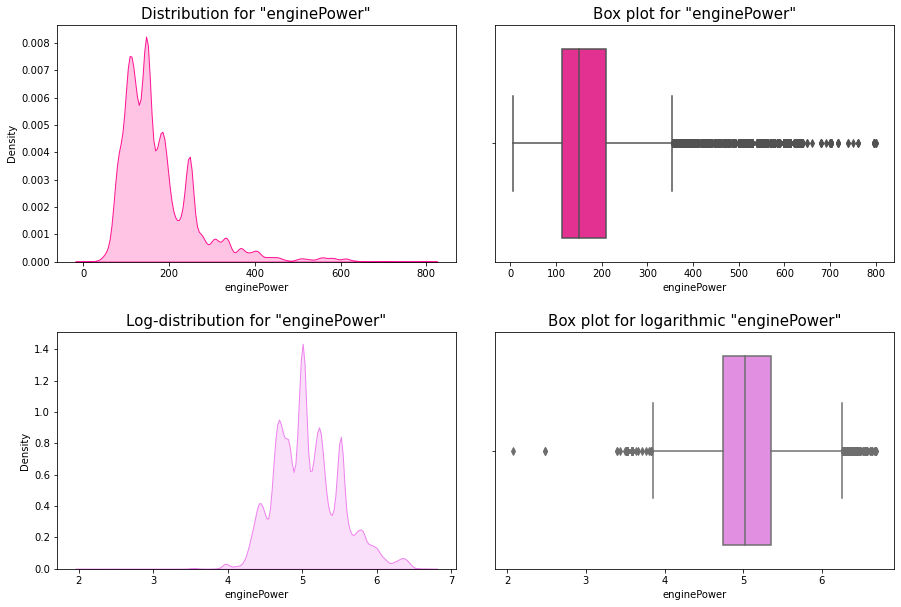

In [44]:
get_distribution('enginePower', df)

In [45]:
# новый признак - "налоговая ставка"
df['ve_duty'] = pd.DataFrame(map(lambda x, y: (12 if x<=100 else
                                               25 if x<=125 else
                                               35 if x<=150 else
                                               45 if x<=175 else
                                               50 if x<=200 else
                                               65 if x<=225 else
                                               75 if x<=250 else
                                               150) if y!='электро'
                                           else
                                              (2.5 if x<=100 else
                                               3.5 if x<=150 else
                                               5.0 if x<=200 else
                                               7.5 if x<=250 else
                                               15),
                                           df['enginePower'],
                                           df['fuelType']))
df.shape

(121101, 252)

In [46]:
df = df.merge(pd.get_dummies(df['ve_duty'], prefix='ve_duty'), left_index=True, right_index=True)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0       0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0        0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI  MITSUBISHI  \
0       0         0        0      0         0        0   0     0           0   

   MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  \
0         0       0     0        0         0        0        0           0   

   RAM  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  \
0    0      0        0            0      0     0      0     0               0   

   SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  \
0      1      0           0       0       0      0     0      0       0   

   TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  \
0       0       0    0    0           0      0       0       0    0      0   

   ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
0      0   0         13        0      0        0       

(121101, 265)

## fuelType

- 5 уникальных значений, пропусков нет
- Авто на газу представлено очень мало менее 0.1%\
$\to$ Получается очень несбалансированная выборка (с учетом остальных признаков), вся надежда на стекинг\
$\to$ проведем lable encoding

In [47]:
df = get_lable_encoding('fuelType', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0       0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0        0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI  MITSUBISHI  \
0       0         0        0      0         0        0   0     0           0   

   MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  \
0         0       0     0        0         0        0        0           0   

   RAM  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  \
0    0      0        0            0      0     0      0     0               0   

   SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  \
0      1      0           0       0       0      0     0      0       0   

   TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  \
0       0       0    0    0           0      0       0       0    0      0   

   ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
0      0   0         13        0      0        0       

(121101, 271)

## mileage

- Много нулей, что может быть равносильно пропускам (NaN значении нет)\
$\to$ Получим новый бинарный признак "new<->used" из `car_url`, возможно все авто без пробега являются новыми
   - Так и оказалось. Т.е. 16.5% в выборке новые авто (без пробега)


- Логарифмирование ухудшает распределение\
$\to$ Нормализуем значения
   - **(memo)** Если прологарифмировать нормализованные значения распределение улучшается

In [48]:
# 0 if used, 1 if new
df['state'] = df['car_url'].apply(lambda x: 0 if (re.findall('(?<=cars\/)\w+', str(x))[0]) == 'used' else 1)
display(df.head(1), df.shape, df['state'].isna().sum())

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

   modelDate                                         model_info model_name  \
0     2013.0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0       0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0        0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI  MITSUBISHI  \
0       0         0        0      0         0        0   0     0           0   

   MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  \
0         0       0     0        0         0        0        0           0   

   RAM  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  \
0    0      0        0            0      0     0      0     0               0   

   SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  \
0      1      0           0       0       0      0     0      0       0   

   TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  \
0       0       0    0    0           0      0       0       0    0      0   

   ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
0      0   0         13        0      0        0       

(121101, 272)

0

In [49]:
df.groupby('state')['mileage'].value_counts()[1]

mileage
0.0    20009
Name: mileage, dtype: int64

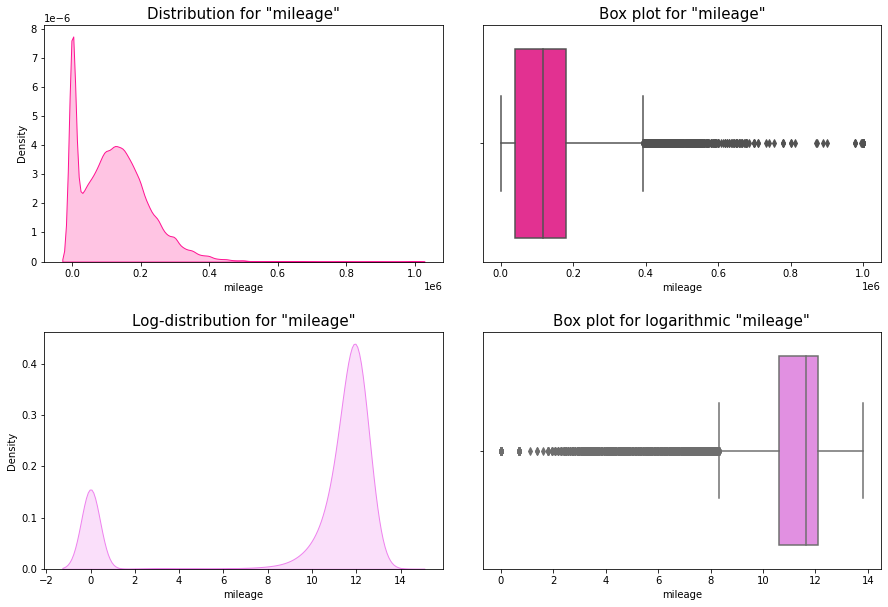

In [50]:
get_distribution('mileage', df)

In [51]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
df['mileage_norm'] = scaler.fit_transform(df[['mileage']])

In [52]:
# fig, axes = plt.subplots(figsize=(7.15, 5))
# sns.kdeplot(df['mileage'], axes=axes, color='deeppink', shade=True);

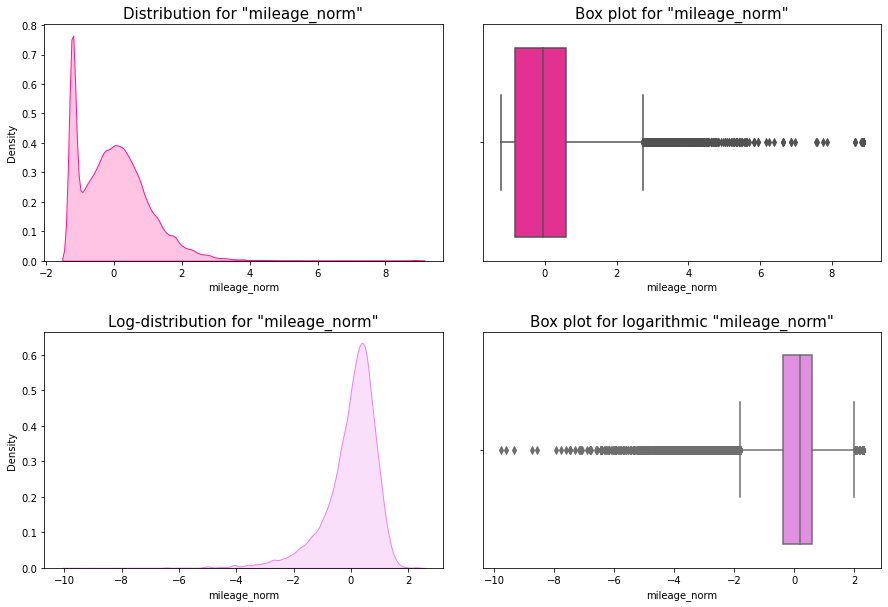

In [53]:
get_distribution('mileage_norm', df)

## productionDate

- 70 уникальных значений, пропусков нет
- Есть явные выбросы\
$\to$ Так как все строки с выбросами из тестового датасета, то их удаление приведет к тому, что будет невозможно закомитить результат.\
Хотя рассмотрение подобных авто в рамках указанных в описании к соревнованию целей не имеет смысла, так как перепродажа подобных авто не приносит много прибыли, или проходят по разряду антиквариат, предсказать состояние которого без визуального осмотра невозможно (или крайне сложно).
   1. будем надеяться, что ключевые слова из описания как-то помогут, и на стекинг
   2. Попробуем добавить еще один категориальный признак "антиквариат", для того, чтобы более явно указать модели деление на классы по данному аспекту


- логарифмирование никак не улучшает распредельные\
$\to$ Нормализуем значения

In [54]:
df[df['productionDate']<=1970].head(3)

bodyType  brand                                            car_url  \
1777  хэтчбек 3 дв.  SKODA  https://auto.ru/cars/used/sale/skoda/popular/1...   
3174          седан   AUDI  https://auto.ru/cars/used/sale/audi/920/109152...   
7216    седан 2 дв.  VOLVO  https://auto.ru/cars/used/sale/volvo/140/10985...   

       color complectation_dict  \
1777  чёрный                NaN   
3174  чёрный                NaN   
7216   белый                NaN   

                                            description engineDisplacement  \
1777  Авто после длительного простоя, под восстановл...            1.1 LTR   
3174  Ауди кабриолет, 1938 г., ретро, на ходу, есть ...            3.3 LTR   
7216                           Элементы экстерьера: 1.             2.0 LTR   

      enginePower            equipment_dict fuelType   mileage  modelDate  \
1777           30                       NaN   бензин   14000.0     1934.0   
3174           75                       NaN   бензин   90000.0     1938.0   
7216           82  {'14-inch-wheels': True}   бензин  150000.0     1966.0   

                                             model_info model_name  \
1777  {'code': 'POPULAR', 'name': 'Popular', 'ru_nam...    POPULAR   
3174  {'code': '920', 'name': '920', 'ru_name': '920...        920   
7216  {'code': '140', 'name': '140 Series', 'ru_name...        140   

                  name  numberOfDoors  price  productionDate       sell_id  \
1777  1.1 MT (30 л.с.)            3.0   -1.0          1939.0  1.097046e+09   
3174  3.3 MT (75 л.с.)            4.0   -1.0          1938.0  1.091525e+09   
7216  2.0 MT (82 л.с.)            2.0   -1.0          1970.0  1.098530e+09   

                                              super_gen  \
1777  {'id': '20783514', 'displacement': 1089, 'engi...   
3174  {'id': '20652212', 'displacement': 3281, 'engi...   
7216  {'id': '20475379', 'displacement': 2000, 'engi...   

                  vehicleConfiguration vehicleTransmission    vendor  \
1777  HATCHBACK_3_DOORS MECHANICAL 1.1        механическая  EUROPEAN   
3174              SEDAN MECHANICAL 3.3        механическая  EUROPEAN   
7216      SEDAN_2_DOORS MECHANICAL 2.0        механическая  EUROPEAN   

        Владельцы       ПТС    Привод   Руль  bodyType_enc  внедорожник_3_дв  \
1777  3 или более  Оригинал    задний  Левый            23                 0   
3174  2 владельца  Оригинал    задний  Левый            15                 0   
7216  2 владельца  Оригинал  передний  Левый            16                 0   

      внедорожник_5_дв  внедорожник_открытый  кабриолет  компактвэн  купе  \
1777                 0                     0          0           0     0   
3174                 0                     0          0           0     0   
7216                 0                     0          0           0     0   

      купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  пикап_двойная_кабина  \
1777             0        0        0         0        0                     0   
3174             0        0        0         0        0                     0   
7216             0        0        0         0        0                     0   

      пикап_одинарная_кабина  пикап_полуторная_кабина  родстер  седан  \
1777                       0                        0        0      0   
3174                       0                        0        0      1   
7216                       0                        0        0      0   

      седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  фастбек  \
1777           0              0         0      0               0        0   
3174           0              0         0      0               0        0   
7216           1              0         0      0               0        0   

      фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  \
1777       0             1             0             0         92   0      0   
3174       0             0             0             0          6   0      0   
7216  

In [55]:
get_outlier_iqr('productionDate', df)


 25-й перцентиль: 2008.0, 
 75-й перцентиль: 2018.0, 
 IQR: 10.0, 
 Границы выбросов: [1993.0<->2033.0]



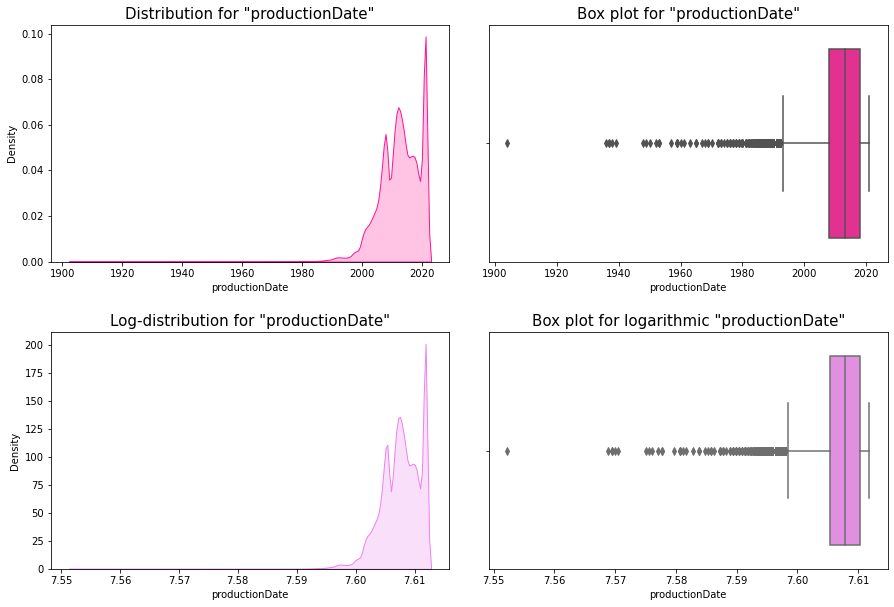

In [56]:
get_distribution('productionDate', df)

## modelDate

- 68 уникальных значений, чуть меньше чем в `productionDate`
- пропусков нет
- Есть явные выбросы\
\
$\to$ так как `productionDate` и `modelDate` близки по смыслу, проверим корреляцию
   - Признаки скоррелировали на 92% $\to$ Дата производства представляется более информативным признаком, поэтоме удалим `modelDate`

In [57]:
df[['modelDate', 'productionDate']].corr()

modelDate  productionDate
modelDate        1.000000        0.925466
productionDate   0.925466        1.000000

In [58]:
df.drop(['modelDate'], axis=1, inplace=True)
df.shape

(121101, 272)

## model_name

- 1280 уникальных значений, пропусков нет
- Значении слишком много, нет идеи как проверить адекватность/точность. На первый взгляд проблем нет\
$\to$ проведем lable encoding (хотя не уверен в правильности решения)

In [59]:
pd.DataFrame(df.groupby('brand')['model_name'].value_counts())

model_name
brand model_name             
AC    COBRA                 1
ACURA MDX                  24
      RDX                  14
      TL                    3
      TLX                   3
...                       ...
ZIBAR MK2                   1
ZOTYE T600                  5
      COUPA                 1
ZX    GRAND_TIGER           1
      LANDMARK              1

[1315 rows x 1 columns]

In [60]:
df = get_lable_encoding('model_name', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

                 name  numberOfDoors  price  productionDate       sell_id  \
0  1.2 AMT (105 л.с.)            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС    Привод   Руль  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  передний  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0         0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0          0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI_x  \
0       0         0        0      0         0        0   0       0   

   MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  \
0           0         0       0     0        0         0        0        0   

   PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  \
0           0      0      0        0            0      0     0      0     0   

   SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  \
0               0      1      0           0       0       0      0     0   

   TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  \
0      0       0       0       0    0    0           0      0       0       0   

   ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  \
0    0      0      0   0         13        0      0        0       0        0   

   

(121101, 1553)

## name

- Признак объединяет в себе признаки `engineDisplacement`, `enginePower`, `vehicleTransmission`, `Привод` (***частично***)\
$\to$ Проверим вышеуказанные признаки на наличие пропусков
   - Пропуски есть в признаке `Привод`\
   $\to$ Так как из словаря с признаками (`super_gen`) можно извлечь значение привода авто в более полном объеме, удалим столбец `name`

In [61]:
# for col in ['engineDisplacement', 'enginePower', 'vehicleTransmission', 'Привод']:
#     if df[col].isna().sum()!=0:
#         print(col, ':', df[col].isna().sum())

In [62]:
# for i in range(len(df)):
#     if df.iloc[i]['super_gen']['gear_type']=='':
#         print(i)

In [63]:
df.drop(['name'], axis=1, inplace=True)
df.shape

(121101, 1552)

## Привод

- 3 уникальных значений
- 20009 пропуска\
$\to$ извлечем значение из словаря с признаками `super_gen`\
$\to$ проведем lable encoding

In [64]:
df['Привод'] = df['super_gen'].apply(lambda x: x['gear_type'])

In [65]:
print(df['Привод'].isna().sum(), df['Привод'].unique())

0 ['FORWARD_CONTROL' 'ALL_WHEEL_DRIVE' 'REAR_DRIVE']


In [66]:
df = get_lable_encoding('Привод', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС           Привод  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  FORWARD_CONTROL   

    Руль  bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  \
0  Левый             8                 0                 0   

   внедорожник_открытый  кабриолет  компактвэн  купе  купе-хардтоп  лимузин  \
0                     0          0           0     0             0        0   

   лифтбек  микровэн  минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        1         0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0         0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0          0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI_x  \
0       0         0        0      0         0        0   0       0   

   MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  \
0           0         0       0     0        0         0        0        0   

   PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  \
0           0      0      0        0            0      0     0      0     0   

   SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  \
0               0      1      0           0       0       0      0     0   

   TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  \
0      0       0       0       0    0    0           0      0       0       0   

   ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  \
0    0      0      0   0         13        0      0        0       0        0   

   золотистый  коричневый  кр

(121101, 1556)

## numberOfDoors

- 5 уникальных значений
- Есть значение 0\
$\to$ Посмотрим поближе, возможно это ошибка
   - Все в порядке, такие автомобили действительно существуют. Хотя их количество в выборке исчезающе мало (что, конечно, соответствует реальности)\
   $\to$ есть одна строка из тестового датасета, удалить не получится

$\to$ создадим dammy

In [67]:
# df[df['numberOfDoors']==0]

In [68]:
df = df.merge(pd.get_dummies(df['numberOfDoors'], prefix='door'), left_index=True, right_index=True)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleConfiguration  \
0  {'id': '10373605', 'displacement': 1197, 'engi...   LIFTBACK ROBOT 1.2   

  vehicleTransmission    vendor    Владельцы       ПТС           Привод  \
0    роботизированная  EUROPEAN  3 или более  Оригинал  FORWARD_CONTROL   

    Руль  bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  \
0  Левый             8                 0                 0   

   внедорожник_открытый  кабриолет  компактвэн  купе  купе-хардтоп  лимузин  \
0                     0          0           0     0             0        0   

   лифтбек  микровэн  минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        1         0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0         0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   

   GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0          0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0            0       0           0      0      0       0        0    0   

   LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  MINI_x  \
0       0         0        0      0         0        0   0       0   

   MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  \
0           0         0       0     0        0         0        0        0   

   PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  \
0           0      0      0        0            0      0     0      0     0   

   SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  \
0               0      1      0           0       0       0      0     0   

   TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  \
0      0       0       0       0    0    0           0      0       0       0   

   ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  жёлтый  зелёный  \
0    0      0      0   0         13        0      0        0       0        0   

   золотистый  коричневый  кр

(121101, 1561)

## price

- **_Целевой признак_**
- 4313 пропусков (3.6% выборки)\
$\to$ Оказалось, что на момент парсинга данные авто получили статус "продано", в связи с чем цену спарсить не удалось\
$\to$ Так как `price` это целевой признал, наверное, лучше будет удалить данные авто из выборки.\
_Как вариант_: разделить все авто на две группы "new" "used", для каждой группы посчитать медианную цену для каждой модели каждого бренда и заполнить еи пропуски, если пропуски еще будут, то заполнить их медианной ценой по каждому бренду (без учета модели)\
_Еще вариант_: Во изучения кода страницы для парсинга заметил пункт с хранящейся в нем информацией о истории цены (нет времени для проверки этой теории)\
    - (реализован вариант с медианной ценой) Судя по всему оставшиеся 4 авто без цены очень редкие\
    $\to$ просто удалим

- После логарифмирования, распределение становится симметричным
- Средняя цена авто в датасете = 1 882 907 rub

In [69]:
df[df['price'] != -1]['price'].mean()

1882907.1372317362

In [70]:
for condition in [1, 0]:
    median_price = {}
    for brand in list(df['brand'].unique()):
        # вычисляем медианные цены
        median_price[brand] = df[(df['state'] == condition) &
                                 (df['brand'] == brand) &
                                 (df['price'] != -1) &
                                 (df['price'].isna() == False)].\
                                groupby('model_name')['price'].median().to_dict()
        # накладываем маску и записываем результат во временный столбец
        df['temp'] = df[(df['state'] == condition) &
                        (df['brand'] == brand) &
                        (df['price'].isna() == True)]['model_name'].map(median_price[brand])
        # заполняем пропуски
        df['price'].fillna(df['temp'], inplace=True)

df.drop('temp', axis=1, inplace=True)

df['price'].isna().sum()

8

In [71]:
df[df['price'].isna()==True]

bodyType     brand  \
35324            купе      AUDI   
44374            купе       BMW   
55587      компактвэн     HONDA   
55951   хэтчбек 5 дв.     HONDA   
82965         родстер  MERCEDES   
98743   хэтчбек 3 дв.   PEUGEOT   
113284           купе    TOYOTA   
120302  хэтчбек 5 дв.       ZAZ   

                                                  car_url        color  \
35324   https://auto.ru/cars/used/sale/audi/tts/109694...    оранжевый   
44374   https://auto.ru/cars/new/group/bmw/4/22301343/...        серый   
55587   https://auto.ru/cars/used/sale/honda/mobilio_s...  серебристый   
55951   https://auto.ru/cars/used/sale/honda/zest/1103...        белый   
82965   https://auto.ru/cars/used/sale/mercedes/slc_kl...        белый   
98743   https://auto.ru/cars/used/sale/peugeot/208_gti...        белый   
113284  https://auto.ru/cars/used/sale/toyota/supra/11...  серебристый   
120302  https://auto.ru/cars/used/sale/zaz/forza/11019...   золотистый   

                                       complectation_dict  \
35324                                         {'id': '0'}   
44374   {'id': '22350232', 'name': '420d xDrive M Spor...   
55587                                                 NaN   
55951                                         {'id': '0'}   
82965                                         {'id': '0'}   
98743                                         {'id': '0'}   
113284                                                NaN   
120302                                        {'id': '0'}   

                                              description engineDisplacement  \
35324   ! TTS апельсин ! \n272лс, автомат, полный прив...            2.0 LTR   
44374   ПОКА ДРУГИЕ ДИКТУЮТ УСЛОВИЯ, У НАС ВЫ ВСЕ РЕША...            2.0 LTR   
55587   Автомобиль в отличнейшем состоянии. В новой пт...            1.5 LTR   
55951   Авто в хорошем техническом состоянии, работает...            0.7 LTR   
82965   Собственник. Агентам просьба не беспокоить. Бе...            3.0 LTR   
98743                  Сервисная книжка. Пройдены все ТО.            1.6 LTR   
113284  Машина мечты. Toyota supra 5 го поколения, А 9...            3.0 LTR   
120302  Продам рабочего коня, машина была в одной семь...            1.5 LTR   

        enginePower                                     equipment_dict  \
35324           272  {'seats-2': True, 'abs': True, 'esp': True, 'b...   
44374           190  {'esp': True, 'isofix': True, 'hcc': True, 'st...   
55587           110                                                 {}   
55951            52  {'front-centre-armrest': True, 'keyless-entry'...   
82965           367  {'cruise-control': True, 'esp': True, 'start-s...   
98743           200  {'cruise-control': True, 'asr': True, 'esp': T...   
113284          340  {'cruise-control': True, 'dark-interior': True...   
120302          109  {'steel-wheels': True, 'condition': True, 'ptf...   

       fuelType   mileage                                         model_info  \
35324    бензин  148000.0  {'code': 'TTS', 'name': 'TTS', 'ru_name': 'ТТС...   
44374    дизель       0.0  {'code': '4', 'name': '4 серии', 'ru_name': '4...   
55587    бензин  408000.0  {'code': 'MOBILIO_SPIKE', 'name': 'Mobilio Spi...   
55951    бензин  120000.0  {'code': 'ZEST', 'name': 'Zest', 'ru_name': 'З...   
82965    бензин   21000.0  {'code': 'SLC_KLASSE_AMG', 'name': 'SLC AMG', ...   
98743    бензин   37000.0  {'code': '208_GTI', 'name': '208 GTi', 'ru_nam...   
113284   бензин    1000.0  {'code': 'SUPRA', 'name': 'Supra', 'ru_name': ...   
120302   бензин   55000.0  {'code': 'FORZA', 'name': 'Forza', 'ru_name': ...   

            model_name  numberOfDoors  price  productionDate       sell_id  \
35324              TTS            2.0    NaN          2008.0  1.096940e+09   
44374                4            2.0    NaN          2021.0  1.103285e+09   
55587    MOBILIO_SPIKE            5.0    NaN          2002.0  1.103287e+09   
55951             ZEST            5.0    NaN          2010.

In [72]:
# удалим остатки
df.dropna(subset=['price'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.shape

(121093, 1561)

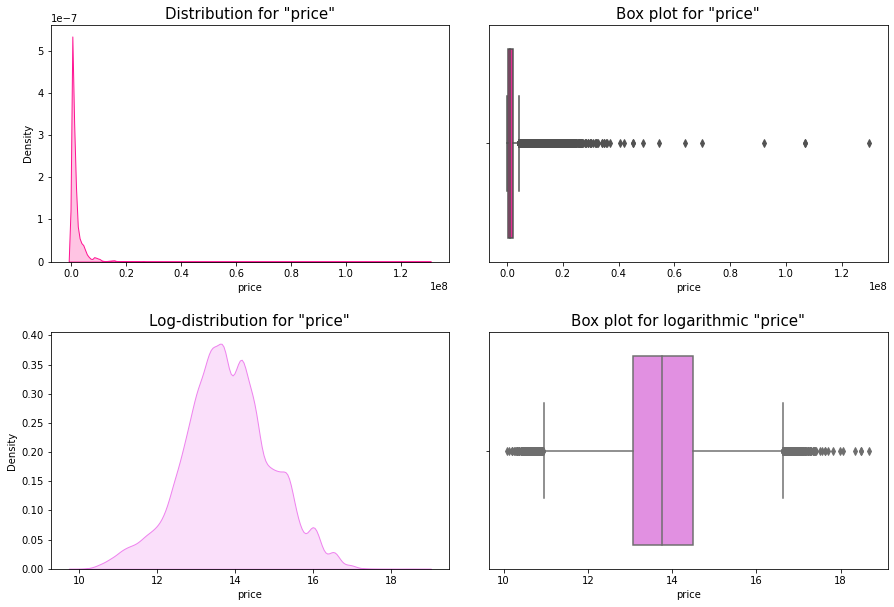

In [73]:
get_distribution('price', df[df['price']!=-1])

## vehicleConfiguration

- Признак объединяет в себе признаки `bodyType`, `vehicleTransmission`, `engineDisplacement`, `numberOfDoors` (***частично***)\
$\to$ Проверим вышеуказанные признаки на наличие пропусков
   - пропусков нет\
   $\to$ удалим столбец `vehicleConfiguration`

In [74]:
# for col in ['bodyType', 'vehicleTransmission', 'engineDisplacement', 'numberOfDoors']:
#     if df[col].isna().sum()!=0:
#         print(col, ':', df[col].isna().sum())

In [75]:
df.drop('vehicleConfiguration', axis=1, inplace=True)
df.shape

(121093, 1560)

## vehicleTransmission

- 4 уникальных значений
- пропусков нет\
$\to$ проведем lable encoding

In [76]:
df = get_lable_encoding('vehicleTransmission', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleTransmission  \
0  {'id': '10373605', 'displacement': 1197, 'engi...    роботизированная   

     vendor    Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0  EUROPEAN  3 или более  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  \
0      0    0    0      0          0    0           0      0      0      0   

   HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  \
0       0      0       0        0   0         0            0      0    0   

   JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  \
0       0     0    0            0       0           0      0      0       0   

   LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  \
0        0    0       0         0        0      0         0        0   0   

   MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  \
0       0           0         0       0     0        0         0        0   

   PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  \
0        0           0      0      0        0            0      0     0   

   SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  \
0      0     0               0      1      0           0       0       0   

   TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  \
0      0     0      0       0       0       0    0    0           0      0   

   VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  \
0       0       0    0      0      0   0         13        0      0        0   

   жёлтый  зелёный  золотистый  коричневый  красный  оранжевый  пурпурный  \
0       0        0           0         

(121093, 1565)

## vendor

- 7 уникальных значений
- 2266 пропусков + 27 `vendor_unknown`\
$\to$ Так как репутация вендоров, например 'JAPANESE' и 'CHINESE', кардинально различается откажемся от идеи объединения в более крупные группы, например 'ASIA'. По тем же соображения оставим 'VENDOR_UNKNOWN' без изменения\
$\to$ заполним пропуски\
$\to$ проведем lable encoding

In [77]:
df[df['vendor']=='VENDOR_UNKNOWN']['brand'].value_counts()

IRAN_KHODRO    15
LUXGEN         10
ZIBAR           1
TATA            1
Name: brand, dtype: int64

In [78]:
# подготовим словарь соответствия "вендор - бренд"
vendor_dict={}
for brand in list(df[df['vendor'].isna()==False]['brand'].unique()):
    vendor_dict[brand] = list(set(df[(df['brand']==brand)&(df['vendor'].isna()==False)]['vendor']))[0]

In [79]:
# заполним пропуски
df['vendor'].fillna(df['brand'].map(vendor_dict), inplace=True)

In [80]:
# проведем lable encoding
df = get_lable_encoding('vendor', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleTransmission  \
0  {'id': '10373605', 'displacement': 1197, 'engi...    роботизированная   

     vendor    Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0  EUROPEAN  3 или более  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  \
0      0    0    0      0          0    0           0      0      0      0   

   HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  \
0       0      0       0        0   0         0            0      0    0   

   JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  \
0       0     0    0            0       0           0      0      0       0   

   LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  \
0        0    0       0         0        0      0         0        0   0   

   MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  \
0       0           0         0       0     0        0         0        0   

   PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  \
0        0           0      0      0        0            0      0     0   

   SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  \
0      0     0               0      1      0           0       0       0   

   TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  \
0      0     0      0       0       0       0    0    0           0      0   

   VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  \
0       0       0    0      0      0   0         13        0      0        0   

   жёлтый  зелёный  золотистый  коричневый  красный  оранжевый  пурпурный  \
0       0        0           0         

(121093, 1573)

## Владельцы

- 5 уникальных значений\
$\to$ хотя должно быть 3, удалим текст
- 20011 пропусков 16.5%
- 20008 из пропусков это новые авто\
$\to$ заполним нулями, оставшиеся 2 заполнить медианой\
$\to$ проведем lable encoding

In [81]:
df['Владельцы'].value_counts()

3 или более    42538
1 владелец     21841
2 владельца    17975
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [82]:
# чистим
df['Владельцы'] = df['Владельцы'].apply(lambda x: np.nan if pd.isna(x) else x.replace('\xa0', ''))
df['Владельцы'] = df['Владельцы'].apply(lambda x: np.nan if pd.isna(x) else int(re.search('\d+', str(x))[0]))

In [83]:
df[df['Владельцы'].isna()==True]['state'].value_counts()

1    20008
0        2
Name: state, dtype: int64

In [84]:
df[(df['Владельцы'].isna()==True)&(df['state']==0)]

bodyType       brand  \
89526  внедорожник 5 дв.  MITSUBISHI   
97790              седан     PEUGEOT   

                                                 car_url        color  \
89526  https://auto.ru/cars/used/sale/mitsubishi/paje...  серебристый   
97790  https://auto.ru/cars/used/sale/peugeot/406/103...      зелёный   

      complectation_dict                                        description  \
89526        {'id': '0'}  АВТОСАЛОНАМ НЕ ЗВОНИТЬ, ПЛОЩАДКАМ, ПЕРЕКУПЩИКА...   
97790        {'id': '0'}  Отличное состояние. Есть сколы на капоте. Цена...   

      engineDisplacement  enginePower equipment_dict fuelType   mileage  \
89526            3.2 LTR          165             {}   дизель  260000.0   
97790            1.8 LTR          116             {}   бензин  220000.0   

                                              model_info model_name  \
89526  {'code': 'PAJERO', 'name': 'Pajero', 'ru_name'...     PAJERO   
97790  {'code': '406', 'name': '406', 'ru_name': '406...        406   

       numberOfDoors      price  productionDate       sell_id  \
89526            5.0  1280000.0          2005.0  1.025387e+09   
97790            4.0   200000.0          2000.0  1.035900e+09   

                                               super_gen vehicleTransmission  \
89526  {'id': '20395261', 'displacement': 3200, 'engi...        механическая   
97790  {'id': '20396844', 'displacement': 1749, 'engi...        механическая   

         vendor  Владельцы       ПТС           Привод   Руль  bodyType_enc  \
89526  JAPANESE        NaN  Оригинал  ALL_WHEEL_DRIVE  Левый             1   
97790  EUROPEAN        NaN  Оригинал  FORWARD_CONTROL  Левый            15   

       внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
89526                 0                 1                     0          0   
97790                 0                 0                     0          0   

       компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
89526           0     0             0        0        0         0        0   
97790           0     0             0        0        0         0        0   

       пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
89526                     0                       0                        0   
97790                     0                       0                        0   

       родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  \
89526        0      0           0              0         0      0   
97790        0      1           0              0         0      0   

       универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  \
89526               0        0       0             0             0   
97790               0        0       0             0             0   

       хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  ARIEL  \
89526             0         74   0      0           0       0      0   
97790             0         78   0      0           0       0      0   

       ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
89526             0     0      0        0    0       0           0      0   
97790             0     0      0        0    0       0           0      0   

       BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  \
89526    0         0        0      0           0          0         0   
97790    0         0        0      0           0          0         0   

       CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  DERWAYS  DODGE  \
89526        0      0     0       0         0         0        0      0   
97790        0      0     0       0         0         0        0      0   

       DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  \
89526         0   0         0    0        0     0       0     0      0    0   
97790         0   0         0    0        0     0       0     0      0    0   

       GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  H

In [85]:
df[(df['Владельцы'].isna() == True) & (df['state'] == 0)]['Владельцы'] = df['Владельцы'].median()

In [86]:
df['Владельцы'].fillna(0, inplace=True)
df['Владельцы'].isna().sum()

0

In [87]:
df['Владельцы'].value_counts()

3.0    42538
1.0    31300
2.0    27245
0.0    20010
Name: Владельцы, dtype: int64

In [88]:
df = df.merge(pd.get_dummies(df['Владельцы'], prefix='owner'), left_index=True, right_index=True)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleTransmission  \
0  {'id': '10373605', 'displacement': 1197, 'engi...    роботизированная   

     vendor  Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0  EUROPEAN        3.0  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  \
0      0    0    0      0          0    0           0      0      0      0   

   HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  \
0       0      0       0        0   0         0            0      0    0   

   JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  \
0       0     0    0            0       0           0      0      0       0   

   LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  \
0        0    0       0         0        0      0         0        0   0   

   MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  \
0       0           0         0       0     0        0         0        0   

   PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  \
0        0           0      0      0        0            0      0     0   

   SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  \
0      0     0               0      1      0           0       0       0   

   TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  \
0      0     0      0       0       0       0    0    0           0      0   

   VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  \
0       0       0    0      0      0   0         13        0      0        0   

   жёлтый  зелёный  золотистый  коричневый  красный  оранжевый  пурпурный  \
0       0        0           0           0 

(121093, 1577)

## ПТС

- 2 уникальных значений
- 20011 пропусков, 20008 из них это новые авто\
$\to$ заполним все пропуски как "Оригинал"\
$\to$ проведем lable encoding

In [89]:
df[df['ПТС'].isna()==True]['state'].value_counts()

1    20008
0        3
Name: state, dtype: int64

In [90]:
df[(df['ПТС'].isna()==True)&(df['state']==0)]

bodyType       brand                                            car_url  \
10412    седан         BMW  https://auto.ru/cars/used/sale/bmw/3er/3350400...   
48641    седан   CHEVROLET  https://auto.ru/cars/used/sale/chevrolet/cruze...   
89132    седан  MITSUBISHI  https://auto.ru/cars/used/sale/mitsubishi/cari...   

             color complectation_dict  \
10412        синий                NaN   
48641  серебристый        {'id': '0'}   
89132      зелёный        {'id': '0'}   

                                             description engineDisplacement  \
10412  Сделано большое Т.О. Фильтра масляный, воздушн...            2.5 LTR   
48641  Продам Круз в идеальном состоянии, без ДТП. Лю...            1.8 LTR   
89132  Машина на ходу, подробная информация при осмот...            1.6 LTR   

       enginePower                                     equipment_dict  \
10412          170                                                NaN   
48641          141  {'computer': True, 'velvet-seats': True, 'abs'...   
89132          100                                                 {}   

      fuelType   mileage                                         model_info  \
10412   бензин  276000.0  {'code': '3ER', 'name': '3 серии', 'ru_name': ...   
48641   бензин   85000.0  {'code': 'CRUZE', 'name': 'Cruze', 'ru_name': ...   
89132   бензин  210000.0  {'code': 'CARISMA', 'name': 'Carisma', 'ru_nam...   

      model_name  numberOfDoors     price  productionDate       sell_id  \
10412        3ER            4.0      -1.0          1999.0  3.350401e+07   
48641      CRUZE            4.0  570000.0          2014.0  1.053079e+09   
89132    CARISMA            4.0  130000.0          2000.0  1.010178e+09   

                                               super_gen vehicleTransmission  \
10412  {'id': '6329491', 'name': '323', 'nameplate': ...      автоматическая   
48641  {'id': '8538417', 'displacement': 1796, 'engin...        механическая   
89132  {'id': '21296294', 'displacement': 1597, 'engi...        механическая   

         vendor  Владельцы  ПТС           Привод   Руль  bodyType_enc  \
10412  EUROPEAN        3.0  NaN       REAR_DRIVE  Левый            15   
48641  AMERICAN        1.0  NaN  FORWARD_CONTROL  Левый            15   
89132  JAPANESE        3.0  NaN  FORWARD_CONTROL  Левый            15   

       внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
10412                 0                 0                     0          0   
48641                 0                 0                     0          0   
89132                 0                 0                     0          0   

       компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
10412           0     0             0        0        0         0        0   
48641           0     0             0        0        0         0        0   
89132           0     0             0        0        0         0        0   

       пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
10412                     0                       0                        0   
48641                     0                       0                        0   
89132                     0                       0                        0   

       родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  \
10412        0      1           0              0         0      0   
48641        0      1           0              0         0      0   
89132        0      1           0              0         0      0   

       универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  \
10412               0        0       0             0             0   
48641               0        0       0             0             0   
89132               0        0       0             0             0   

       хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  ARIEL  \
10412             0          9   0      0           0       0      0   
48641             0      

In [91]:
df['ПТС'].fillna('Оригинал', inplace=True)
df['ПТС'].isna().sum()

0

In [92]:
df = get_lable_encoding('ПТС', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleTransmission  \
0  {'id': '10373605', 'displacement': 1197, 'engi...    роботизированная   

     vendor  Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0  EUROPEAN        3.0  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  \
0      0    0    0      0          0    0           0      0      0      0   

   HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  \
0       0      0       0        0   0         0            0      0    0   

   JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  \
0       0     0    0            0       0           0      0      0       0   

   LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  \
0        0    0       0         0        0      0         0        0   0   

   MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  \
0       0           0         0       0     0        0         0        0   

   PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  \
0        0           0      0      0        0            0      0     0   

   SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  \
0      0     0               0      1      0           0       0       0   

   TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  \
0      0     0      0       0       0       0    0    0           0      0   

   VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  \
0       0       0    0      0      0   0         13        0      0        0   

   жёлтый  зелёный  золотистый  коричневый  красный  оранжевый  пурпурный  \
0       0        0           0           0 

(121093, 1580)

## Руль

- 2 уникальных значений
- Все пропуски это новые авто\
$\to$ Так как в РФ новые авто могут быть только с левым рулем, заполним все пропуски как "Левый"\
$\to$ проведем lable encoding

In [93]:
df[df['Руль'].isna()==True]['state'].value_counts()

1    20008
Name: state, dtype: int64

In [94]:
df['Руль'].fillna('Левый', inplace=True)
df['Руль'].isna().sum()

0

In [95]:
df = get_lable_encoding('Руль', df)
display(df.head(1), df.shape)

bodyType  brand                                            car_url  color  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   

  complectation_dict                                        description  \
0                NaN  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower  \
0            1.2 LTR          105   

                                      equipment_dict fuelType  mileage  \
0  {'engine-proof': True, 'tinted-glass': True, '...   бензин  74000.0   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

   numberOfDoors  price  productionDate       sell_id  \
0            5.0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleTransmission  \
0  {'id': '10373605', 'displacement': 1197, 'engi...    роботизированная   

     vendor  Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0  EUROPEAN        3.0  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  \
0      0    0    0      0          0    0           0      0      0      0   

   HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  \
0       0      0       0        0   0         0            0      0    0   

   JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  \
0       0     0    0            0       0           0      0      0       0   

   LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  \
0        0    0       0         0        0      0         0        0   0   

   MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  \
0       0           0         0       0     0        0         0        0   

   PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  \
0        0           0      0      0        0            0      0     0   

   SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  \
0      0     0               0      1      0           0       0       0   

   TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  \
0      0     0      0       0       0       0    0    0           0      0   

   VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  \
0       0       0    0      0      0   0         13        0      0        0   

   жёлтый  зелёный  золотистый  коричневый  красный  оранжевый  пурпурный  \
0       0        0           0           0 

(121093, 1583)

## car_url

$\to$ Теперь можно удалять

In [96]:
df.drop('car_url', axis=1, inplace=True)
df.shape

(121093, 1582)

### Посмотрим на признаки содержащие словари и попробуем выудить дополнительную информацию 

In [97]:
dict_columns

['complectation_dict', 'equipment_dict', 'model_info', 'super_gen']

## complectation_dict

- Очень большое количество пропусков
- плюс 52772 пустых словарей\
$\to$ возможно при парсинге что-то пошло не так
   - `equipment_dict` дублирует содержание и имеет куда меньше пропусков\
   $\to$ перейдем вначале к нему

In [98]:
df['complectation_dict'].isna().sum()

28979

In [99]:
# df['complectation_dict'][10000]

In [100]:
available_options = set()

# заполняем список всеми встречающимися уникальными значениями
df['complectation_dict'].apply(lambda x: np.nan if (pd.isna(x) or 'available_options' not in x.keys())
                                                else available_options.update(set(x['available_options'])))

len(available_options)

161

## equipment_dict

- Получим список всего доступного оборудования
- Список оказался слишком большим (326 единиц), к тому же встречаются странные значения содержащие, например, только цифры \
$\to$ найдем пересечения с `available_options` и будем использовать только их
- Там где в `equipment_dict` пропуски у `complectation_dict` так же нет значений\
$\to$ удалим `equipment_dict` и `complectation_dict`, больше они нам не пригодятся 

In [101]:
df['equipment_dict'].isna().sum()

9996

In [102]:
# df['equipment_dict'][62200]

In [103]:
available_equipments = set()

# заполняем список всеми встречающимися уникальными значениями
df['equipment_dict'].apply(lambda x: np.nan if pd.isna(x) else available_equipments.update(set(x.keys())))

len(available_equipments)

326

In [104]:
# ищем пересечения
equipments_list=list(set(available_options).intersection(set(available_equipments)))

# print(equipments_list, len(equipments_list))
len(equipments_list)

158

In [105]:
for equipment in equipments_list:
    # создаем новые столбцы для каждого вида оборудования и ставим 1 если оборудование есть в авто
    df[equipment] = df[df['equipment_dict'].isna() == False]['equipment_dict']\
                    .apply(lambda x: 1 if equipment in list(x.keys()) else 0)
    
    # сразу заполним нулями строки где не указано оборудование
    df[equipment].fillna(0, inplace=True)

display(df[df['equipment_dict'].isna() == True].head(1), df.shape)

bodyType  brand  color complectation_dict     description  \
58  лифтбек  SKODA  белый                NaN  Срочно Продам.   

   engineDisplacement  enginePower equipment_dict fuelType   mileage  \
58            1.6 LTR          110            NaN   бензин  150200.0   

                                           model_info model_name  \
58  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   

    numberOfDoors  price  productionDate       sell_id  \
58            5.0   -1.0          2016.0  1.101317e+09   

                                            super_gen vehicleTransmission  \
58  {'id': '20105520', 'displacement': 1598, 'engi...        механическая   

      vendor  Владельцы       ПТС           Привод   Руль  bodyType_enc  \
58  EUROPEAN        3.0  Дубликат  FORWARD_CONTROL  Левый             8   

    внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
58                 0                 0                     0          0   

    компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
58           0     0             0        0        1         0        0   

    пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
58                     0                       0                        0   

    родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  \
58        0      0           0              0         0      0   

    универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  \
58               0        0       0             0             0             0   

    brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  \
58         92   0      0           0       0      0             0     0   

    AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  \
58      0        0    0       0           0      0    0         0        0   

    CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  \
58      0           0          0         0        0      0     0       0   

    DAIHATSU  DATSUN_x  DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  \
58         0         0        0      0         0   0         0    0        0   

    FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  \
58     0       0     0      0    0    0      0          0    0           0   

    HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  \
58      0      0      0       0      0       0        0   0         0   

    IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  \
58            0      0    0       0     0    0            0       0   

    LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  \
58           0      0      0       0        0    0       0         0        0   

    MAZDA  MERCEDES  MERCURY  MG  MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  \
58      0         0        0   0       0           0         0       0     0   

    PEUGEOT  PLYMOUTH  PONTIAC  PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  \
58        0         0        0        0           0      0      0        0   

    ROLLS_ROYCE  ROVER  SAAB  SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  \
58            0      0     0      0     0               0      1      0   

    SSANG_YONG  SUBARU  SUZUKI  TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  \
58           0       0       0      0     0      0       0       0       0   

    UAZ  VAZ  VOLKSWAGEN  VOLVO  VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  \
58    0    0           0      0       0       0    0      0      0   0   

    color_enc  бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
58          1        0      1        0       0        0           0   

    коричневый  красный  оранжевый  пурпурный  розовый  серебристый  серый  \
58           0        0          0          0        0            0      0   

    синий  фиолетовый  чёрный  engineDisplacement_enc  _LTR  06_LTR  07_LTR  \
58      0           0       0 

(121093, 1740)

In [106]:
# проверяем есть ли нужные значения в "complectation_dict"
len(df[(df['equipment_dict'].isna()==True)&(df['complectation_dict'].isna()==False)])

0

In [107]:
# удаляем
df.drop(['complectation_dict', 'equipment_dict'], axis=1, inplace=True)
df.shape

(121093, 1738)

## model_info

- Какой-то дополнительной информации отсюда извлечь не получится\
$\to$ удалим

In [108]:
df['model_info'][10000]

{'code': '5ER',
 'name': '5 серии',
 'ru_name': '5 серии',
 'morphology': {},
 'nameplate': {'code': '10202931',
  'name': 'Gran Turismo',
  'semantic_url': 'gran_turismo'}}

In [109]:
df.drop('model_info', axis=1, inplace=True)
df.shape

(121093, 1737)

## super_gen

- Отсюда можно дополнительно извлечь информацию о:
  - времени разгона до 100 км/ч (_acceleration_)
  - минимальном клиренсе (_clearance_min_)
  - расходе топлива (_fuel_rate_)

In [110]:
df['super_gen'].isna().sum()

0

In [111]:
'acceleration' in df['super_gen'][536].keys()

False

In [112]:
# времени разгона
df['acceleration'] = df['super_gen'].apply(lambda x: np.nan if 'acceleration' not in x.keys() else x['acceleration'])
# минимальном клиренсе
df['clearance'] = df['super_gen'].apply(lambda x: np.nan if 'clearance_min' not in x.keys() else x['clearance_min'])
# расходе топлива
df['fuel_rate'] = df['super_gen'].apply(lambda x: np.nan if 'fuel_rate' not in x.keys() else x['fuel_rate'])

display(df.head(1), df.shape)

bodyType  brand  color                                        description  \
0  лифтбек  SKODA  синий  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower fuelType  mileage model_name  numberOfDoors  \
0            1.2 LTR          105   бензин  74000.0    OCTAVIA            5.0   

   price  productionDate       sell_id  \
0   -1.0          2014.0  1.100575e+09   

                                           super_gen vehicleTransmission  \
0  {'id': '10373605', 'displacement': 1197, 'engi...    роботизированная   

     vendor  Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0  EUROPEAN        3.0  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY  GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  \
0      0    0    0      0          0    0           0      0      0      0   

   HAWTAI  HONDA  HUMMER  HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  \
0       0      0       0        0   0         0            0      0    0   

   JAGUAR  JEEP  KIA  LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  \
0       0     0    0            0       0           0      0      0       0   

   LINCOLN  LTI  LUXGEN  MASERATI  MAYBACH  MAZDA  MERCEDES  MERCURY  MG  \
0        0    0       0         0        0      0         0        0   0   

   MINI_x  MITSUBISHI  MOSCVICH  NISSAN  OPEL  PEUGEOT  PLYMOUTH  PONTIAC  \
0       0           0         0       0     0        0         0        0   

   PORSCHE  PROMO_AUTO  RAM_x  RAVON  RENAULT  ROLLS_ROYCE  ROVER  SAAB  \
0        0           0      0      0        0            0      0     0   

   SCION  SEAT  SHANGHAI_MAPLE  SKODA  SMART  SSANG_YONG  SUBARU  SUZUKI  \
0      0     0               0      1      0           0       0       0   

   TAGAZ  TATA  TESLA  TIANMA  TIANYE  TOYOTA  UAZ  VAZ  VOLKSWAGEN  VOLVO  \
0      0     0      0       0       0       0    0    0           0      0   

   VORTEX  XINKAI  ZAZ  ZIBAR  ZOTYE  ZX  color_enc  бежевый  белый  голубой  \
0       0       0    0      0      0   0         13        0      0        0   

   жёлтый  зелёный  золотистый  коричневый  красный  оранжевый  пурпурный  \
0       0        0           0           0        0          0          0   

   розовый  серебристый  серый  синий  фиолетовый  чёрный  \
0        0            0      0      1           0       0   

   engineDisplacement_enc  _LTR  06_LTR  07_LTR  08_LTR  09_LTR  10_LTR  \
0                       7     0       0       0       0       0       0   

   11_LTR  12_LTR  13_LTR  14_LTR  15_LTR  16_LTR  17_LTR  18_LTR  1

(121093, 1740)

In [113]:
print(df['acceleration'].isna().sum(), df['clearance'].isna().sum(), df['fuel_rate'].isna().sum())

6287 3425 11660


In [114]:
# заполним пропуски основывая на бренде и модели
for column in ['acceleration', 'clearance', 'fuel_rate']:
    
    median_values={}
    
    for brand in list(df['brand'].unique()):
        # вычисляем медианные значения
        median_values[brand] = df[(df['brand']==brand)&
                                  (df[column].isna()==False)].\
                                   groupby('model_name')[column].median().to_dict()
        # накладываем маску и записываем результат во временный столбец
        df['temp'] = df[(df['brand']==brand)&
                        (df[column].isna()==True)]['model_name'].map(median_values[brand])
        # заполняем пропуски
        df[column].fillna(df['temp'], inplace=True)

    df.drop('temp', axis=1, inplace=True)

    print('Nan in {}: {}'.format(column, df[column].isna().sum()))

Nan in acceleration: 639
Nan in clearance: 90
Nan in fuel_rate: 1127


In [115]:
# заполним пропуски основывая на бренде и bodyType
for column in ['acceleration', 'clearance', 'fuel_rate']:
    
    median_values={}
    
    for brand in list(df['brand'].unique()):
        # вычисляем медианные значения
        median_values[brand] = df[(df['brand']==brand)&
                                  (df[column].isna()==False)].\
                                   groupby('bodyType')[column].median().to_dict()
        # накладываем маску и записываем результат во временный столбец
        df['temp'] = df[(df['brand']==brand)&
                        (df[column].isna()==True)]['bodyType'].map(median_values[brand])
        # заполняем пропуски
        df[column].fillna(df['temp'], inplace=True)

    df.drop('temp', axis=1, inplace=True)

    print('Nan in {}: {}'.format(column, df[column].isna().sum()))

Nan in acceleration: 115
Nan in clearance: 5
Nan in fuel_rate: 307


In [116]:
# заполним пропуски основывая только на bodyType
for column in ['acceleration', 'clearance', 'fuel_rate']:
    # вычисляем медианные значения
    median_values = df[df[column].isna()==False].groupby('bodyType')[column].median().to_dict()
    
    # накладываем маску и записываем результат во временный столбец
    df['temp'] = df[df[column].isna()==True]['bodyType'].map(median_values)
    
    # заполняем пропуски
    df[column].fillna(df['temp'], inplace=True)
    
    # оставшиеся пропуски заполним медианой
    df[column].fillna(df[column].dropna().median(), inplace=True)
    
    df.drop('temp', axis=1, inplace=True)
    
    print('Nan in {}: {}'.format(column, df[column].isna().sum()))

Nan in acceleration: 0
Nan in clearance: 0
Nan in fuel_rate: 0


In [117]:
# удаляем
df.drop('super_gen', axis=1, inplace=True)

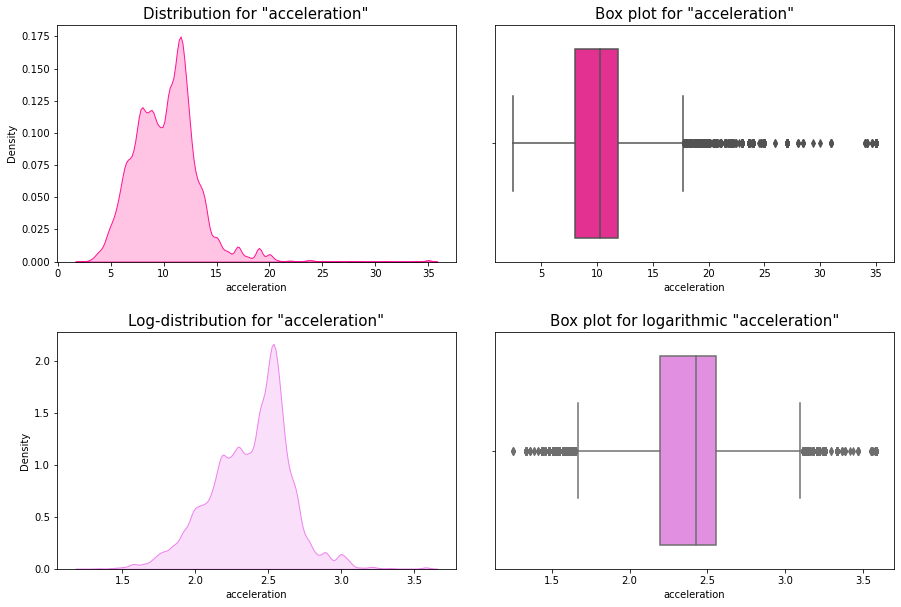

In [118]:
get_distribution('acceleration', df)

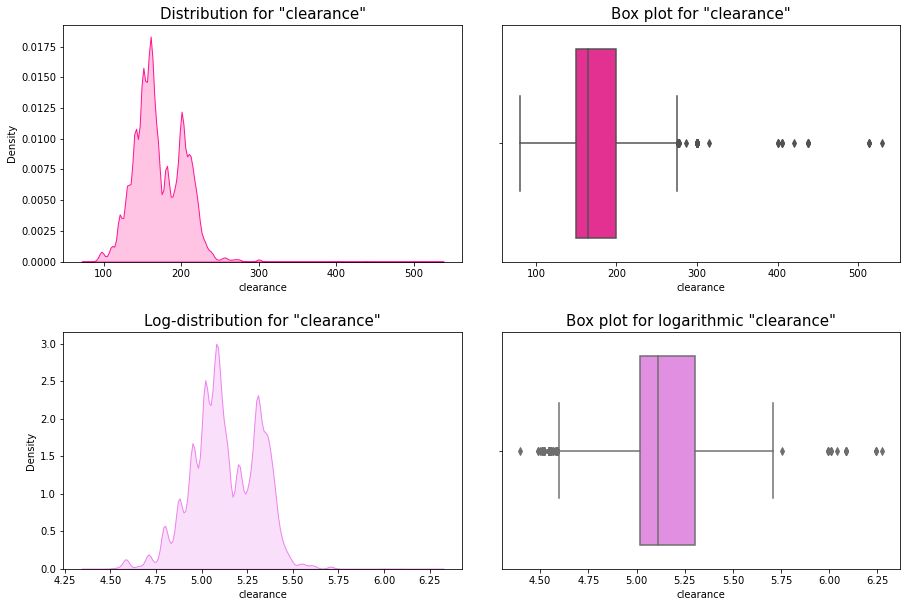

In [119]:
get_distribution('clearance', df)

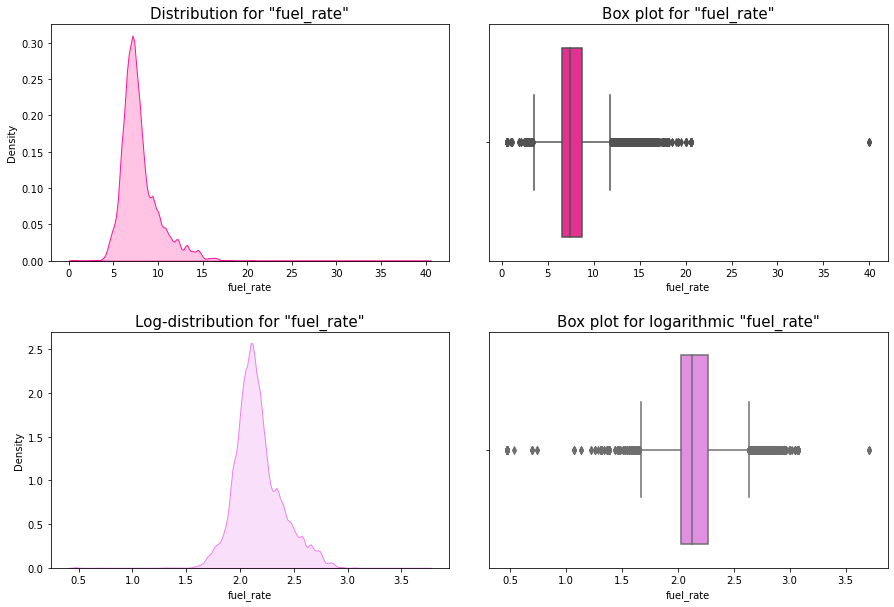

In [120]:
get_distribution('fuel_rate', df)

## description

$\to$ Заполним пропуски произвольным словом, например "пусто"\
$\to$ Проведем векторизацию текста

In [121]:
df['description'].isna().sum()

2581

In [122]:
df['description'].fillna('пусто', inplace=True)

In [123]:
# text = df['description'].copy()

# stop_words = stopwords.words('russian')

In [124]:
# c_vect = CountVectorizer(stop_words=stop_words, max_features=50)
# # tf_idf = TfidfVectorizer(stop_words=stop_words, max_features=50)
# c_vect_feature = c_vect.fit_transform(text).toarray()
# # tf_idf_feature = tf_idf.fit_transform(text).toarray()

In [125]:
# tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
# X = tsne.fit_transform(c_vect_feature)

In [126]:
# description_df = pd.DataFrame(X, columns=['axis_x', 'axis_y'])
# description_df.head(3)

### Векторизация длится очень долго, поэтому сохраним description_df в файл CSV и в дальнейшем будем работать с ним, чтобы когда будет необходимость рестартовать Kernel не ждать снова

In [127]:
# description_df.to_csv('data/description_vec.csv', index = False)

In [128]:
description_vec = pd.read_csv('data/description_vec.csv')

display(description_vec.head(3), description_vec.shape)

axis_x     axis_y
0  22.706980  33.496120
1 -28.379526 -28.465767
2  22.707077  33.496143

(121097, 2)

In [129]:
# добавляем в основной df
df = df.merge(description_vec, left_index=True, right_index=True)

display(df.head(3), df.shape)

bodyType  brand   color                                        description  \
0  лифтбек  SKODA   синий  Все автомобили, представленные в продаже, прох...   
1  лифтбек  SKODA  чёрный  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...   
2  лифтбек  SKODA   серый  Все автомобили, представленные в продаже, прох...   

  engineDisplacement  enginePower fuelType  mileage model_name  numberOfDoors  \
0            1.2 LTR          105   бензин  74000.0    OCTAVIA            5.0   
1            1.6 LTR          110   бензин  60563.0    OCTAVIA            5.0   
2            1.8 LTR          152   бензин  88000.0     SUPERB            5.0   

   price  productionDate       sell_id vehicleTransmission    vendor  \
0   -1.0          2014.0  1.100575e+09    роботизированная  EUROPEAN   
1   -1.0          2017.0  1.100549e+09        механическая  EUROPEAN   
2   -1.0          2014.0  1.100658e+09    роботизированная  EUROPEAN   

   Владельцы       ПТС           Привод   Руль  bodyType_enc  \
0        3.0  Оригинал  FORWARD_CONTROL  Левый             8   
1        1.0  Оригинал  FORWARD_CONTROL  Левый             8   
2        1.0  Оригинал  FORWARD_CONTROL  Левый             8   

   внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  кабриолет  \
0                 0                 0                     0          0   
1                 0                 0                     0          0   
2                 0                 0                     0          0   

   компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  минивэн  \
0           0     0             0        0        1         0        0   
1           0     0             0        0        1         0        0   
2           0     0             0        0        1         0        0   

   пикап_двойная_кабина  пикап_одинарная_кабина  пикап_полуторная_кабина  \
0                     0                       0                        0   
1                     0                       0                        0   
2                     0                       0                        0   

   родстер  седан  седан_2_дв  седан-хардтоп  спидстер  тарга  универсал_5_дв  \
0        0      0           0              0         0      0               0   
1        0      0           0              0         0      0               0   
2        0      0           0              0         0      0               0   

   фастбек  фургон  хэтчбек_3_дв  хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  \
0        0       0             0             0             0         92   0   
1        0       0             0             0             0         92   0   
2        0       0             0             0             0         92   0   

   ACURA  ALFA_ROMEO  ALPINA  ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  \
0      0           0       0      0             0     0      0        0    0   
1      0           0       0      0             0     0      0        0    0   
2      0           0       0      0             0     0      0        0    0   

   BRABUS  BRILLIANCE  BUICK  BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  \
0       0           0      0    0         0        0      0           0   
1       0           0      0    0         0        0      0           0   
2       0           0      0    0         0        0      0           0   

   CHEVROLET  CHRYSLER  CITROEN  DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  \
0          0         0        0      0     0       0         0         0   
1          0         0        0      0     0       0         0         0   
2          0         0        0      0     0       0         0         0   

   DERWAYS  DODGE  DONGFENG  DS  DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  \
0        0      0         0   0         0    0        0     0       0     0   
1        0      0         0   0         0    0        0     0       0     0   
2        0      0         0   0         0    0        0     0       0     0   

   FOTON  GAC  GAZ  GEELY

(121093, 1741)

In [130]:
# удаляем "description"
df.drop('description', axis=1, inplace=True)

display(df.head(3), df.shape)

bodyType  brand   color engineDisplacement  enginePower fuelType  mileage  \
0  лифтбек  SKODA   синий            1.2 LTR          105   бензин  74000.0   
1  лифтбек  SKODA  чёрный            1.6 LTR          110   бензин  60563.0   
2  лифтбек  SKODA   серый            1.8 LTR          152   бензин  88000.0   

  model_name  numberOfDoors  price  productionDate       sell_id  \
0    OCTAVIA            5.0   -1.0          2014.0  1.100575e+09   
1    OCTAVIA            5.0   -1.0          2017.0  1.100549e+09   
2     SUPERB            5.0   -1.0          2014.0  1.100658e+09   

  vehicleTransmission    vendor  Владельцы       ПТС           Привод   Руль  \
0    роботизированная  EUROPEAN        3.0  Оригинал  FORWARD_CONTROL  Левый   
1        механическая  EUROPEAN        1.0  Оригинал  FORWARD_CONTROL  Левый   
2    роботизированная  EUROPEAN        1.0  Оригинал  FORWARD_CONTROL  Левый   

   bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  внедорожник_открытый  \
0             8                 0                 0                     0   
1             8                 0                 0                     0   
2             8                 0                 0                     0   

   кабриолет  компактвэн  купе  купе-хардтоп  лимузин  лифтбек  микровэн  \
0          0           0     0             0        0        1         0   
1          0           0     0             0        0        1         0   
2          0           0     0             0        0        1         0   

   минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        0                     0                       0   
1        0                     0                       0   
2        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   
1                        0        0      0           0              0   
2                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   
1         0      0               0        0       0             0   
2         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   
1             0             0         92   0      0           0       0   
2             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   
1      0             0     0      0        0    0       0           0      0   
2      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   
1    0         0        0      0           0          0         0        0   
2    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0         0        0      0         0   0   
1      0     0       0         0         0        0      0         0   0   
2      0     0       0         0         0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   
1         0    0        0     0       0     0      0    0    0      0   
2         0    0        0     0       0     0      0    0    0      0   

   GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0          0    0           0      0      0      0      

(121093, 1740)

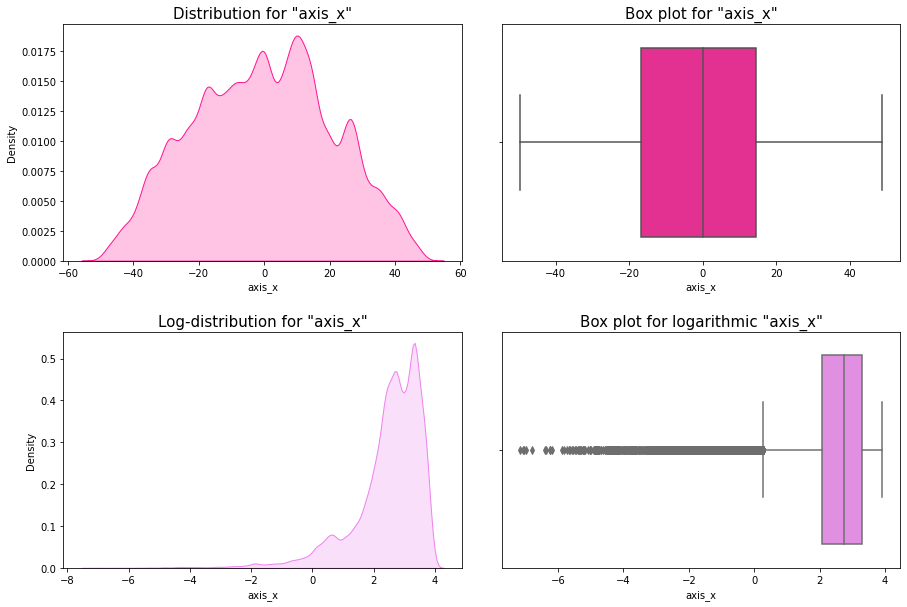

In [131]:
get_distribution('axis_x', df)

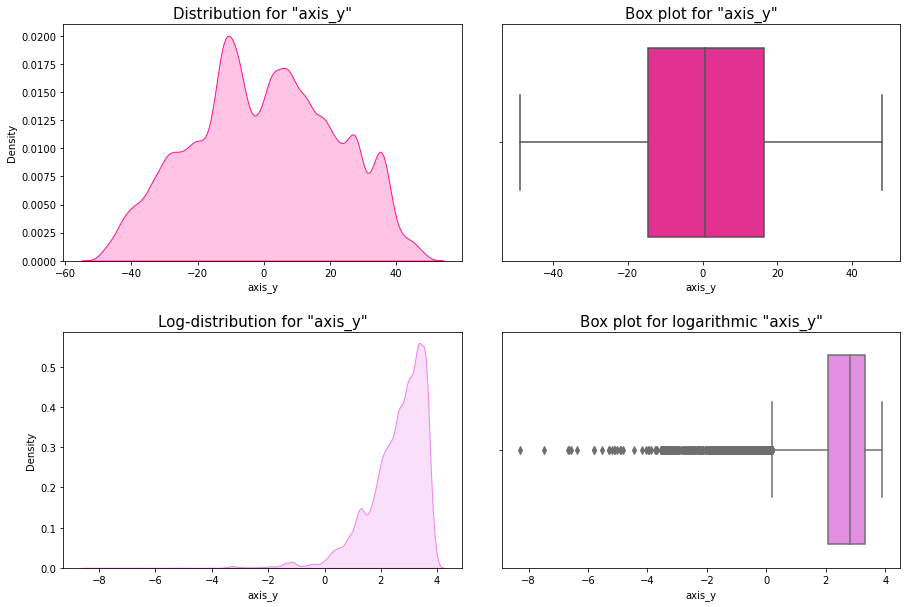

In [132]:
get_distribution('axis_y', df)

## Подготовка данных

### Удалим все признаки с типом object

In [133]:
obt = ['bodyType',
       'brand',
       'color',
       'engineDisplacement',
       'fuelType',
       'model_name',
       'vehicleTransmission',
       'vendor',
       'ПТС',
       'Привод',
       'Руль']

df.drop(obt, axis=1, inplace=True)

display(df.head(3), df.shape)

enginePower  mileage  numberOfDoors  price  productionDate       sell_id  \
0          105  74000.0            5.0   -1.0          2014.0  1.100575e+09   
1          110  60563.0            5.0   -1.0          2017.0  1.100549e+09   
2          152  88000.0            5.0   -1.0          2014.0  1.100658e+09   

   Владельцы  bodyType_enc  внедорожник_3_дв  внедорожник_5_дв  \
0        3.0             8                 0                 0   
1        1.0             8                 0                 0   
2        1.0             8                 0                 0   

   внедорожник_открытый  кабриолет  компактвэн  купе  купе-хардтоп  лимузин  \
0                     0          0           0     0             0        0   
1                     0          0           0     0             0        0   
2                     0          0           0     0             0        0   

   лифтбек  микровэн  минивэн  пикап_двойная_кабина  пикап_одинарная_кабина  \
0        1         0        0                     0                       0   
1        1         0        0                     0                       0   
2        1         0        0                     0                       0   

   пикап_полуторная_кабина  родстер  седан  седан_2_дв  седан-хардтоп  \
0                        0        0      0           0              0   
1                        0        0      0           0              0   
2                        0        0      0           0              0   

   спидстер  тарга  универсал_5_дв  фастбек  фургон  хэтчбек_3_дв  \
0         0      0               0        0       0             0   
1         0      0               0        0       0             0   
2         0      0               0        0       0             0   

   хэтчбек_4_дв  хэтчбек_5_дв  brand_enc  AC  ACURA  ALFA_ROMEO  ALPINA  \
0             0             0         92   0      0           0       0   
1             0             0         92   0      0           0       0   
2             0             0         92   0      0           0       0   

   ARIEL  ASTON_MARTIN  AUDI  AURUS  BENTLEY  BMW  BRABUS  BRILLIANCE  BUICK  \
0      0             0     0      0        0    0       0           0      0   
1      0             0     0      0        0    0       0           0      0   
2      0             0     0      0        0    0       0           0      0   

   BYD  CADILLAC  CHANGAN  CHERY  CHERYEXEED  CHEVROLET  CHRYSLER  CITROEN  \
0    0         0        0      0           0          0         0        0   
1    0         0        0      0           0          0         0        0   
2    0         0        0      0           0          0         0        0   

   DACIA  DADI  DAEWOO  DAIHATSU  DATSUN_x  DERWAYS  DODGE  DONGFENG  DS  \
0      0     0       0         0         0        0      0         0   0   
1      0     0       0         0         0        0      0         0   0   
2      0     0       0         0         0        0      0         0   0   

   DW_HOWER  FAW  FERRARI  FIAT  FISKER  FORD  FOTON  GAC  GAZ  GEELY  \
0         0    0        0     0       0     0      0    0    0      0   
1         0    0        0     0       0     0      0    0    0      0   
2         0    0        0     0       0     0      0    0    0      0   

   GENESIS_x  GMC  GREAT_WALL  HAFEI  HAIMA  HAVAL  HAWTAI  HONDA  HUMMER  \
0          0    0           0      0      0      0       0      0       0   
1          0    0           0      0      0      0       0      0       0   
2          0    0           0      0      0      0       0      0       0   

   HYUNDAI  IG  INFINITI  IRAN_KHODRO  ISUZU  JAC  JAGUAR  JEEP  KIA  \
0        0   0         0            0      0    0       0     0    0   
1        0   0         0            0      0    0       0     0    0   
2        0   0         0            0      0    0       0     0    0   

   LAMBORGHINI  LANCIA  LAND_ROVER  LEXUS  LIFAN  LIGIER  LINCOLN  LTI  \
0           

(121093, 1729)

### Нормализуем числовые признаки

In [134]:
num = ['enginePower', 'productionDate', 'mileage', 'acceleration', 'fuel_rate', 'clearance', 'axis_x', 'axis_y']

# scaler = StandardScaler()
scaler = MinMaxScaler()

num_norm=[]
for col in num:
    df[col+'_norm'] = scaler.fit_transform(df[[col]])
    num_norm.append(col+'_norm')

df[num_norm].head(3)

enginePower_norm  productionDate_norm  mileage_norm  acceleration_norm  \
0          0.123581             0.940171      0.074000           0.246154   
1          0.129887             0.965812      0.060563           0.255385   
2          0.182850             0.940171      0.088000           0.190769   

   fuel_rate_norm  clearance_norm  axis_x_norm  axis_y_norm  
0        0.111675        0.166667     0.735018     0.849023  
1        0.147208        0.168889     0.217100     0.210941  
2        0.164975        0.131111     0.735019     0.849023

### Логарифмирование числовых признаков

#### Проверим распределение каких признаков улучшатся после логарифмирования

- Логарифмирование не дает какого-то ощутимого импакта
- распределение улучшается только у `mileage` при использовании `StandardScaler`\
$\to$ будем пока использовать `MinMaxScaler`, для того чтобы значения были в рамках от 0 до 1
- ~Признак `price` прологарифмируем после разделения df на тестовый и обучающий~

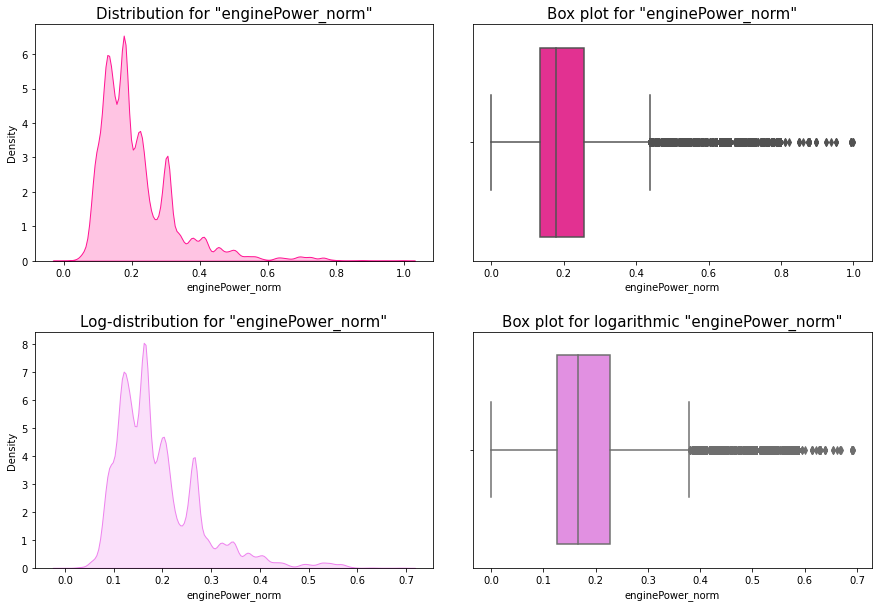

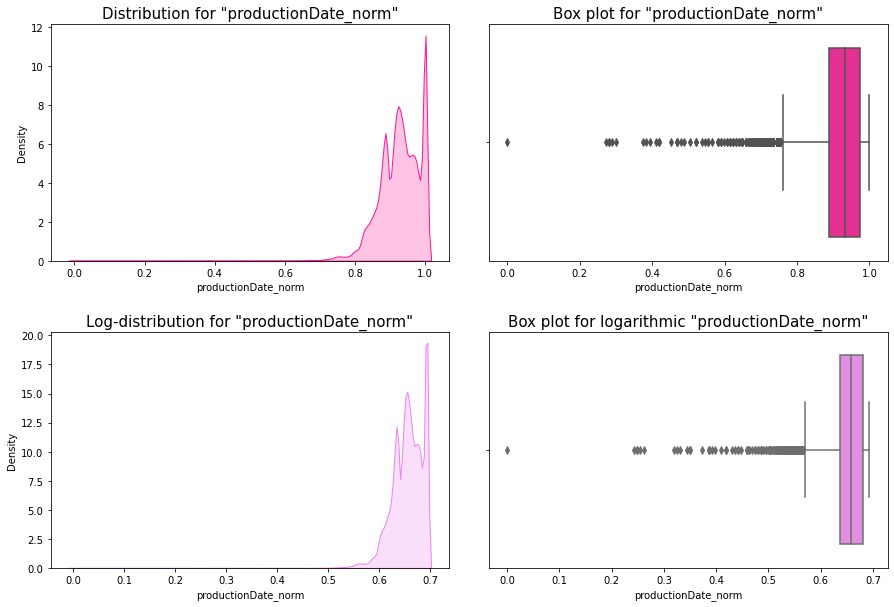

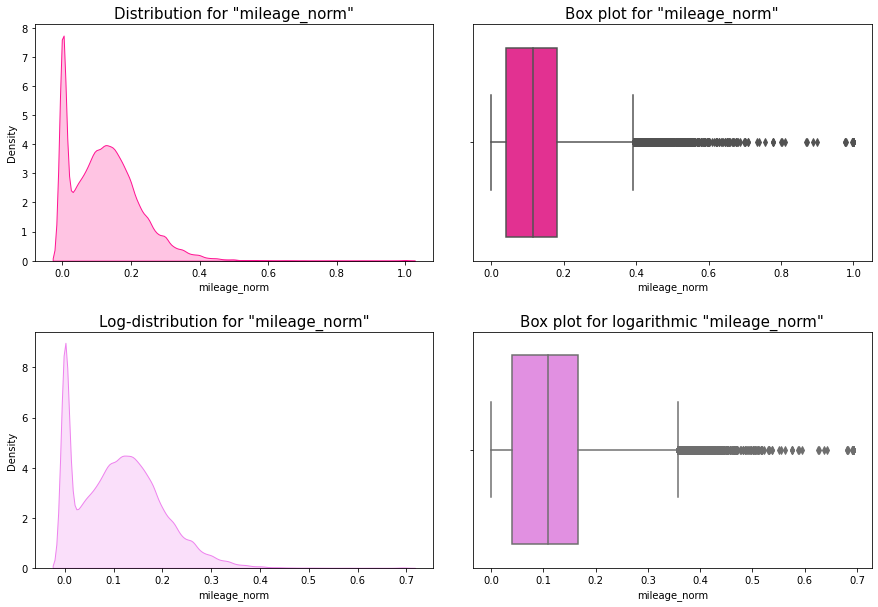

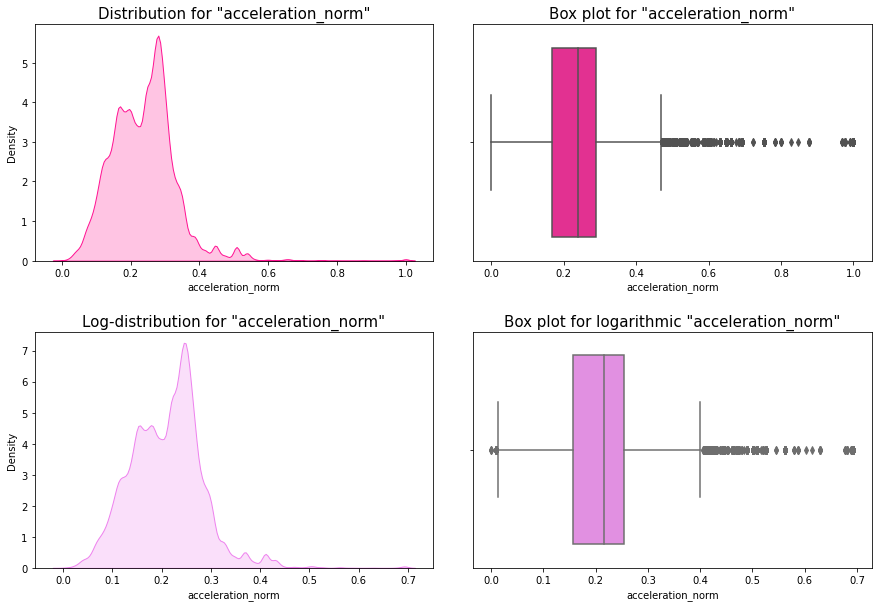

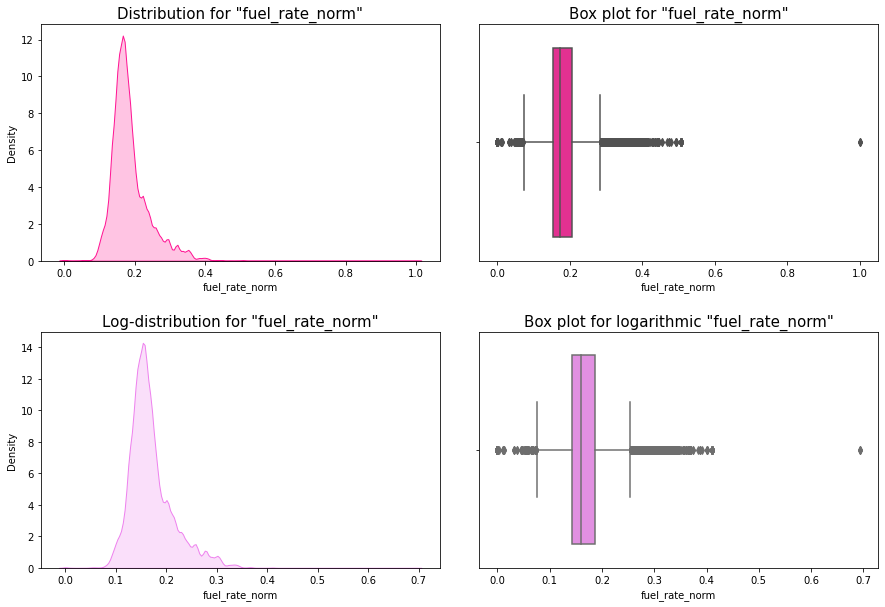

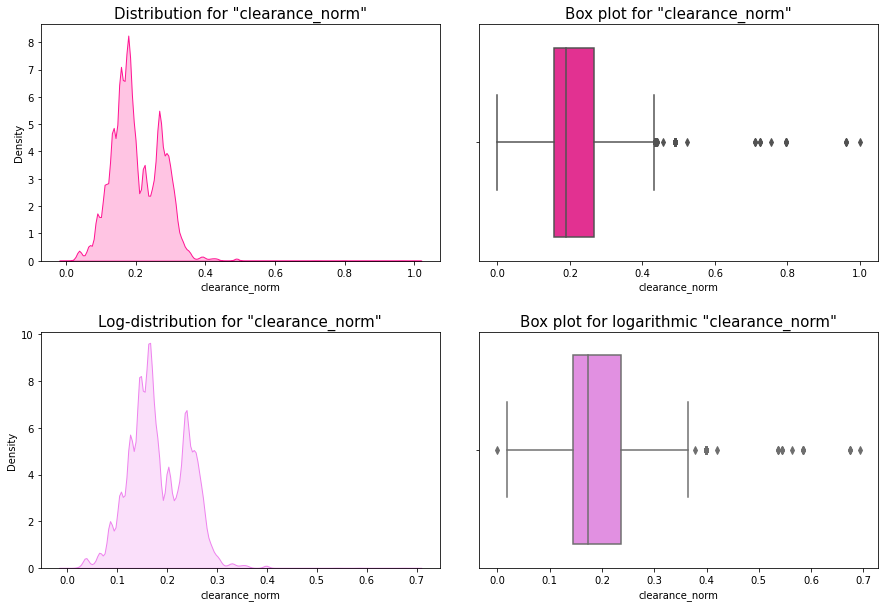

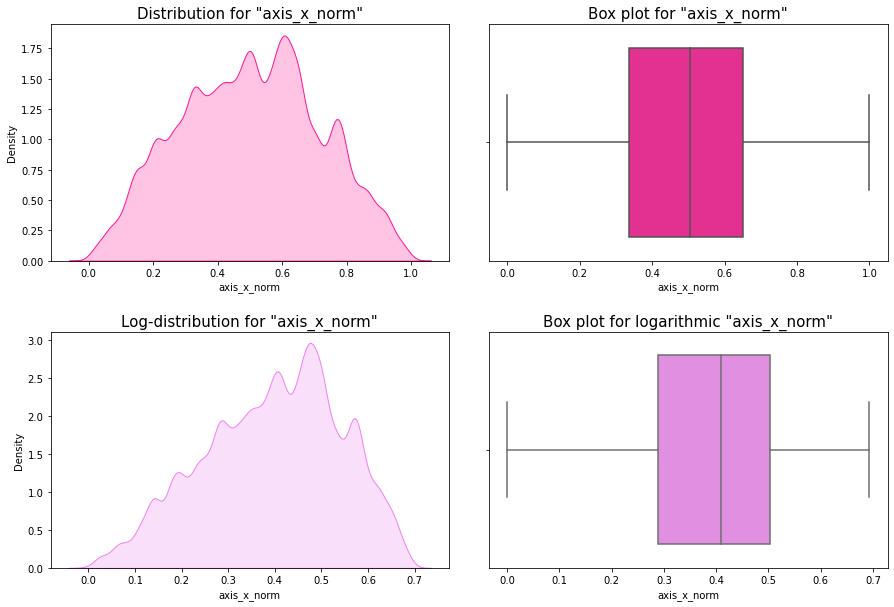

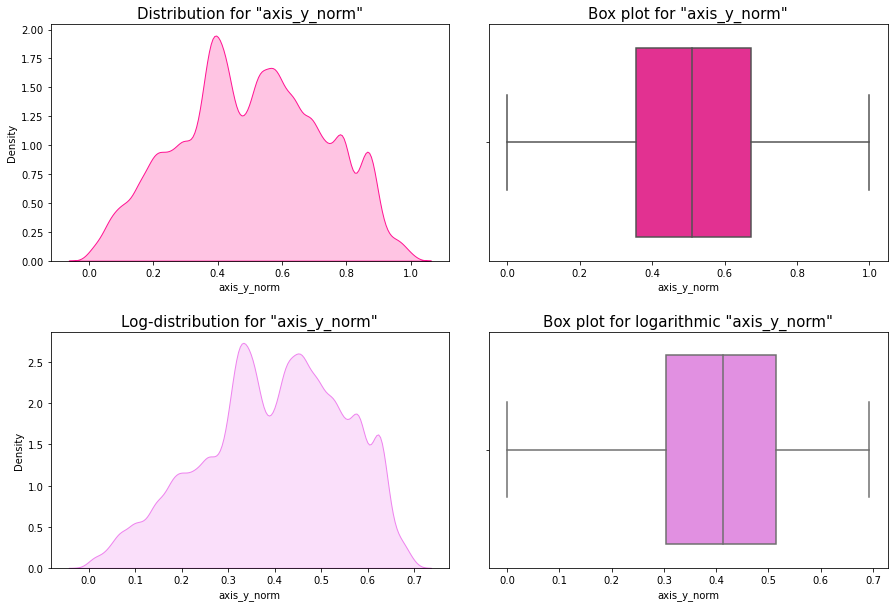

In [135]:
for col in num_norm:
    get_distribution(col, df)

## Подготовка к машинному обучению

In [136]:
train_data = df.query('price != -1').drop(['sell_id'], axis=1)
test_data = df.query('price == -1').drop(['price'], axis=1)

print(train_data.shape, test_data.shape)

(86407, 1735) (34686, 1735)


In [137]:
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# train_data['price_norm'] = scaler.fit_transform(train_data[['price']])

# train_data['price_log'] = train_data['price'].apply(lambda x: np.log(x+1))

In [138]:
# get_distribution('price_norm', train_data)

### Оценка корреляции

- Очень сильная корреляция между `ve_duty` и `enginePower`, так как `ve_duty` сгенерирован на основе `enginePower`\
$\to$ `ve_duty` имеет более низкую значимость чем `enginePower`, удалим `ve_duty` (идея оказалась неудачной)

- Также наблюдаются зависимости между:
  - `acceleration` и `enginePower`
  - `Владельцы` и `productionDate`
  - `mileage` и `productionDate`\
  , что логично\
  $\to$ пока оставим

In [139]:
num_all = num + ['numberOfDoors',
                 'Владельцы',
                 'bodyType_enc',
                 'brand_enc',
                 'color_enc',
                 'engineDisplacement_enc',
                 've_duty', 'fuelType_enc',
                 'model_name_enc',
                 'Привод_enc',
                 'vehicleTransmission_enc',
                 'vendor_enc', 'ПТС_enc',
                 'Руль_enc']

# pandas_profiling.ProfileReport(train_data[num_all]) # отключил на время тестирования моделей

In [140]:
# df.drop(['productionDate', 'enginePower', 'acceleration'], axis=1, inplace=True)
# df.shape

### Оценка значимости переменных

<AxesSubplot:>

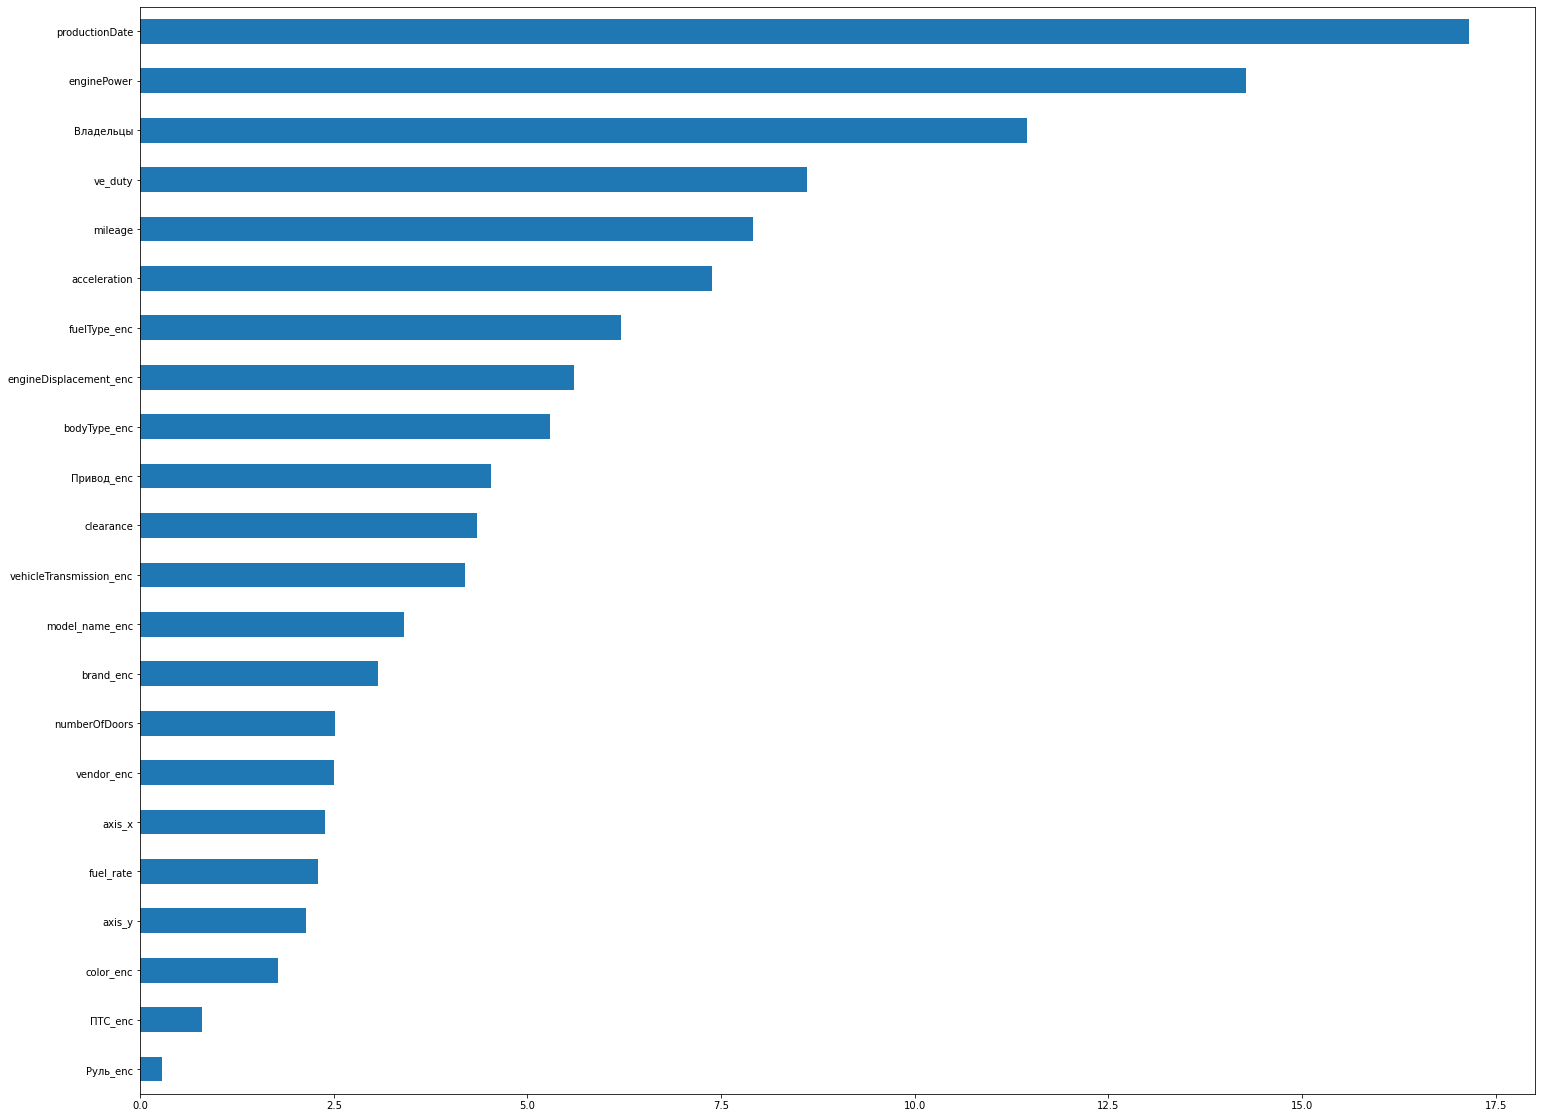

In [141]:
i_numerical = pd.Series(f_classif(train_data[num_all], train_data['price'])[0], index = num_all)
plt.subplots(figsize=(25, 20))
i_numerical.sort_values(inplace = True)
i_numerical.plot(kind = 'barh')

# Baseline

- Используем только категориальные и числовые признаки
  - Уберем малозначительные признаки `ПТС_enc`, `Руль_enc`, `numberOfDoors`, `color_enc`, `vendor_enc`, `fuel_rate`

In [142]:
num_all

['enginePower',
 'productionDate',
 'mileage',
 'acceleration',
 'fuel_rate',
 'clearance',
 'axis_x',
 'axis_y',
 'numberOfDoors',
 'Владельцы',
 'bodyType_enc',
 'brand_enc',
 'color_enc',
 'engineDisplacement_enc',
 've_duty',
 'fuelType_enc',
 'model_name_enc',
 'Привод_enc',
 'vehicleTransmission_enc',
 'vendor_enc',
 'ПТС_enc',
 'Руль_enc']

In [214]:
test_list = ['enginePower',
             'productionDate',
             'mileage',
             'acceleration',
#              'fuel_rate',
             'clearance',
#              'axis_x',
#              'axis_y',
#              'numberOfDoors',
             'Владельцы',
             'bodyType_enc',
             'brand_enc',
#              'color_enc',
             'engineDisplacement_enc',
#              've_duty',
             'fuelType_enc',
             'model_name_enc',
             'Привод_enc',
             'vehicleTransmission_enc',
#              'vendor_enc',
#              'ПТС_enc',
#              'Руль_enc'
            ]

In [215]:
# train
Y = train_data['price'].values.astype('int32')
X = train_data[test_list]

In [171]:
# rus = RandomUnderSampler(random_state = RANDOM_SEED)
# X_resampled, Y_resampled = rus.fit_resample(X, Y)

# X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_SEED)

In [216]:
# submission
X_sub = test_data[test_list]

In [217]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

### ExtraTreesRegressor

In [174]:
# # # ExtraTreesRegressor
# model = ExtraTreesRegressor(n_estimators=100,
#                             random_state=RANDOM_SEED,
#                             bootstrap=True,
#                             n_jobs=-1,
#                             verbose=1)

# model.fit(X_train, Y_train)

# # Prediction
# Y_pred = model.predict(X_test)

# # MAPE = mape(np.exp(Y_test), np.exp(Y_pred))
# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s


Точность модели по метрике MAPE: 13.67%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


MAPE: 13.67%

$\to$ Попробуем регуляризацию

### ExtraTreesRegressor + Regularization

In [149]:
# param_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)], 
#               'max_depth' : [3, 5, 7, 10, 15, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_split' : [2, 4, 6],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap' : [True, False]}

# model = ExtraTreesRegressor(random_state=RANDOM_SEED,
#                             n_jobs=-1,
#                             verbose=1)

# best_model = GridSearchCV(model,
#                           param_grid,
#                           cv=3,
#                           n_jobs=-1,
#                           verbose=True)

# best_model.fit(X_train, Y_train)

# Y_pred = best_model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

In [150]:
# best_model.best_estimator_.get_params()

- Проверить все параметры не получается - крашится Windows\
$\to$ Проверим 100 случайных комбинаций

In [163]:
# param_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)], 
#               'max_depth' : [3, 5, 7, 10, 15, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_split' : [2, 4, 6],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap' : [True, False]}

# model = ExtraTreesRegressor(random_state=RANDOM_SEED,
#                             n_jobs=-1,
#                             verbose=1)

# best_model = RandomizedSearchCV(model,
#                                 param_grid,
#                                 cv=3,
#                                 n_iter=100,
#                                 n_jobs=-1,
#                                 verbose=True,
#                                 random_state=RANDOM_SEED)

# best_model.fit(X_train, Y_train)

# Y_pred = best_model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.2s


Точность модели по метрике MAPE: 15.33%


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished


MAPE: 15.33%

- модель с дефолтными параметрами справилась лучше\
$\to$ Попробуем прологарифмировать целевой признак

In [192]:
# # ExtraTreesRegressor
# model = ExtraTreesRegressor(n_estimators=100,
#                             random_state=RANDOM_SEED,
#                             bootstrap=True,
#                             n_jobs=-1,
#                             verbose=1)

# model.fit(X_train, np.log(Y_train))

# # Prediction
# Y_pred = model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, np.exp(Y_pred)))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s


Точность модели по метрике MAPE: 12.60%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


MAPE: 12.60%

- Логарифмирование целевого признака помогло очень сильно улучшить результат\
$\to$ Попробуем ту же модель, только заменим категориальные признаки на бинарные, а числовые нормализует (пока без логарифмирования)

In [234]:
drop_list = ['enginePower',
             'productionDate',
             'mileage',
             'acceleration',
             'fuel_rate',
             'clearance',
             'axis_x',
             'axis_y',
             'numberOfDoors',
             'Владельцы',
             'bodyType_enc',
             'brand_enc',
             'color_enc',
             'engineDisplacement_enc',
             've_duty',
             'fuelType_enc',
             'model_name_enc',
             'Привод_enc',
             'vehicleTransmission_enc',
             'vendor_enc',
             'ПТС_enc',
             'Руль_enc']

In [235]:
# train
Y = train_data['price'].values.astype('int32')
X = train_data.drop(drop_list, axis=1)
X.drop('price', axis=1, inplace=True)

In [236]:
# submission
X_sub = test_data.drop(drop_list, axis=1)
X_sub.drop('sell_id', axis=1, inplace=True)

In [237]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [168]:
# # ExtraTreesRegressor
# model = ExtraTreesRegressor(n_estimators=100,
#                             random_state=RANDOM_SEED,
#                             bootstrap=True,
#                             n_jobs=-1,
#                             verbose=1)

# model.fit(X_train, Y_train)

# # Prediction
# Y_pred = model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


Точность модели по метрике MAPE: 13.02%


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


MAPE: 13.02%

- результат стал лучше модели с просто категориальными признаками\
$\to$ Попробуем регуляризацию, может в этот раз повезет
    - Все очень печально, моего железа явно недостаточно, на Kaggle, по ощущениям, еще хуже (или нужно очень много времени)\
    $\to$ регуляризация хоть и полезная штука, но осуществлять ее в рамках проекта больше не будем\
    $\to$ логарифмируем целевого признака

In [157]:
# param_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)], 
#               'max_depth' : [3, 5, 7, 10, 15, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_split' : [2, 4, 6],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap' : [True, False]}

# model = ExtraTreesRegressor(random_state=RANDOM_SEED,
#                             n_jobs=-1,
#                             verbose=1)

# best_model = RandomizedSearchCV(model,
#                                 param_grid,
#                                 cv=3,
#                                 n_iter=100,
#                                 n_jobs=-1,
#                                 verbose=True,
#                                 random_state=RANDOM_SEED)

# best_model.fit(X_train, Y_train)

# Y_pred = best_model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

In [197]:
# # ExtraTreesRegressor
# model = ExtraTreesRegressor(n_estimators=100,
#                             random_state=RANDOM_SEED,
#                             bootstrap=True,
#                             n_jobs=-1,
#                             verbose=1)

# model.fit(X_train, np.log(Y_train))

# # Prediction
# Y_pred = model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, np.exp(Y_pred)))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


Точность модели по метрике MAPE: 12.06%


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


MAPE: 12.06%

- Пока что это лучший результат\
$\to$ перейдем к другим моделям

### CatBoost

- Используем те же бинарные признаки

In [218]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           use_best_model=True)

# model.fit(X_train, Y_train,
#           eval_set=(X_test, Y_test),
#           plot=True)

# Y_pred = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

Learning rate set to 0.036708
0:	learn: 2.6746737	test: 2.7401699	best: 2.7401699 (0)	total: 30.9ms	remaining: 2m 34s
1:	learn: 2.6061170	test: 2.6703802	best: 2.6703802 (1)	total: 36.6ms	remaining: 1m 31s
2:	learn: 2.5321463	test: 2.5950402	best: 2.5950402 (2)	total: 42.4ms	remaining: 1m 10s
3:	learn: 2.4627425	test: 2.5245424	best: 2.5245424 (3)	total: 47.8ms	remaining: 59.7s
4:	learn: 2.3963977	test: 2.4566589	best: 2.4566589 (4)	total: 53.6ms	remaining: 53.5s
5:	learn: 2.3295410	test: 2.3885922	best: 2.3885922 (5)	total: 59.5ms	remaining: 49.6s
6:	learn: 2.2691883	test: 2.3270433	best: 2.3270433 (6)	total: 64.9ms	remaining: 46.3s
7:	learn: 2.2050772	test: 2.2616355	best: 2.2616355 (7)	total: 70.7ms	remaining: 44.1s
8:	learn: 2.1414063	test: 2.1966262	best: 2.1966262 (8)	total: 76.5ms	remaining: 42.4s
9:	learn: 2.0792921	test: 2.1331580	best: 2.1331580 (9)	total: 81.9ms	remaining: 40.9s
10:	learn: 2.0181217	test: 2.0706862	best: 2.0706862 (10)	total: 87.5ms	remaining: 39.7s
11:	lear

122:	learn: 0.3562475	test: 0.3695655	best: 0.3695655 (122)	total: 723ms	remaining: 28.7s
123:	learn: 0.3545517	test: 0.3677110	best: 0.3677110 (123)	total: 728ms	remaining: 28.6s
124:	learn: 0.3531813	test: 0.3662296	best: 0.3662296 (124)	total: 734ms	remaining: 28.6s
125:	learn: 0.3502327	test: 0.3632852	best: 0.3632852 (125)	total: 740ms	remaining: 28.6s
126:	learn: 0.3493364	test: 0.3623984	best: 0.3623984 (126)	total: 745ms	remaining: 28.6s
127:	learn: 0.3485014	test: 0.3615204	best: 0.3615204 (127)	total: 750ms	remaining: 28.6s
128:	learn: 0.3456794	test: 0.3585824	best: 0.3585824 (128)	total: 755ms	remaining: 28.5s
129:	learn: 0.3446531	test: 0.3575307	best: 0.3575307 (129)	total: 761ms	remaining: 28.5s
130:	learn: 0.3437198	test: 0.3565488	best: 0.3565488 (130)	total: 767ms	remaining: 28.5s
131:	learn: 0.3407304	test: 0.3534527	best: 0.3534527 (131)	total: 772ms	remaining: 28.5s
132:	learn: 0.3402877	test: 0.3530422	best: 0.3530422 (132)	total: 778ms	remaining: 28.5s
133:	learn

218:	learn: 0.2728185	test: 0.2828436	best: 0.2826742 (217)	total: 1.26s	remaining: 27.6s
219:	learn: 0.2731200	test: 0.2831656	best: 0.2826742 (217)	total: 1.27s	remaining: 27.6s
220:	learn: 0.2729437	test: 0.2829748	best: 0.2826742 (217)	total: 1.28s	remaining: 27.6s
221:	learn: 0.2724022	test: 0.2824352	best: 0.2824352 (221)	total: 1.28s	remaining: 27.6s
222:	learn: 0.2724660	test: 0.2825310	best: 0.2824352 (221)	total: 1.29s	remaining: 27.6s
223:	learn: 0.2713363	test: 0.2813849	best: 0.2813849 (223)	total: 1.29s	remaining: 27.6s
224:	learn: 0.2700307	test: 0.2799365	best: 0.2799365 (224)	total: 1.3s	remaining: 27.6s
225:	learn: 0.2694136	test: 0.2792901	best: 0.2792901 (225)	total: 1.31s	remaining: 27.6s
226:	learn: 0.2690353	test: 0.2789055	best: 0.2789055 (226)	total: 1.31s	remaining: 27.6s
227:	learn: 0.2687263	test: 0.2785169	best: 0.2785169 (227)	total: 1.32s	remaining: 27.6s
228:	learn: 0.2685886	test: 0.2783787	best: 0.2783787 (228)	total: 1.32s	remaining: 27.6s
229:	learn:

312:	learn: 0.2461247	test: 0.2553365	best: 0.2553365 (312)	total: 1.81s	remaining: 27.1s
313:	learn: 0.2459893	test: 0.2552385	best: 0.2552385 (313)	total: 1.81s	remaining: 27.1s
314:	learn: 0.2458582	test: 0.2551141	best: 0.2551141 (314)	total: 1.82s	remaining: 27.1s
315:	learn: 0.2456270	test: 0.2548824	best: 0.2548824 (315)	total: 1.82s	remaining: 27.1s
316:	learn: 0.2456319	test: 0.2548751	best: 0.2548751 (316)	total: 1.83s	remaining: 27s
317:	learn: 0.2456321	test: 0.2548739	best: 0.2548739 (317)	total: 1.84s	remaining: 27s
318:	learn: 0.2456342	test: 0.2548669	best: 0.2548669 (318)	total: 1.84s	remaining: 27s
319:	learn: 0.2453246	test: 0.2545339	best: 0.2545339 (319)	total: 1.85s	remaining: 27s
320:	learn: 0.2451275	test: 0.2543133	best: 0.2543133 (320)	total: 1.85s	remaining: 27s
321:	learn: 0.2451676	test: 0.2543576	best: 0.2543133 (320)	total: 1.86s	remaining: 27s
322:	learn: 0.2449973	test: 0.2541612	best: 0.2541612 (322)	total: 1.87s	remaining: 27s
323:	learn: 0.2449755	te

410:	learn: 0.2286897	test: 0.2373098	best: 0.2373098 (410)	total: 2.36s	remaining: 26.4s
411:	learn: 0.2287071	test: 0.2373281	best: 0.2373098 (410)	total: 2.37s	remaining: 26.4s
412:	learn: 0.2287248	test: 0.2373465	best: 0.2373098 (410)	total: 2.37s	remaining: 26.4s
413:	learn: 0.2284560	test: 0.2370970	best: 0.2370970 (413)	total: 2.38s	remaining: 26.4s
414:	learn: 0.2283024	test: 0.2369439	best: 0.2369439 (414)	total: 2.38s	remaining: 26.4s
415:	learn: 0.2281853	test: 0.2368112	best: 0.2368112 (415)	total: 2.39s	remaining: 26.4s
416:	learn: 0.2280225	test: 0.2366574	best: 0.2366574 (416)	total: 2.4s	remaining: 26.3s
417:	learn: 0.2278585	test: 0.2364866	best: 0.2364866 (417)	total: 2.4s	remaining: 26.3s
418:	learn: 0.2278196	test: 0.2364689	best: 0.2364689 (418)	total: 2.41s	remaining: 26.3s
419:	learn: 0.2276759	test: 0.2363195	best: 0.2363195 (419)	total: 2.41s	remaining: 26.3s
420:	learn: 0.2270314	test: 0.2356272	best: 0.2356272 (420)	total: 2.42s	remaining: 26.3s
421:	learn: 

505:	learn: 0.2160602	test: 0.2242980	best: 0.2242980 (505)	total: 2.9s	remaining: 25.8s
506:	learn: 0.2150845	test: 0.2232995	best: 0.2232995 (506)	total: 2.91s	remaining: 25.8s
507:	learn: 0.2150994	test: 0.2233144	best: 0.2232995 (506)	total: 2.92s	remaining: 25.8s
508:	learn: 0.2151897	test: 0.2233788	best: 0.2232995 (506)	total: 2.92s	remaining: 25.8s
509:	learn: 0.2150281	test: 0.2232070	best: 0.2232070 (509)	total: 2.93s	remaining: 25.8s
510:	learn: 0.2149489	test: 0.2231539	best: 0.2231539 (510)	total: 2.93s	remaining: 25.8s
511:	learn: 0.2148558	test: 0.2230702	best: 0.2230702 (511)	total: 2.94s	remaining: 25.8s
512:	learn: 0.2147784	test: 0.2229952	best: 0.2229952 (512)	total: 2.95s	remaining: 25.8s
513:	learn: 0.2147692	test: 0.2229868	best: 0.2229868 (513)	total: 2.95s	remaining: 25.8s
514:	learn: 0.2146851	test: 0.2228771	best: 0.2228771 (514)	total: 2.96s	remaining: 25.8s
515:	learn: 0.2139242	test: 0.2220984	best: 0.2220984 (515)	total: 2.96s	remaining: 25.7s
516:	learn:

600:	learn: 0.2054148	test: 0.2136828	best: 0.2136828 (600)	total: 3.45s	remaining: 25.2s
601:	learn: 0.2053663	test: 0.2136390	best: 0.2136390 (601)	total: 3.45s	remaining: 25.2s
602:	learn: 0.2052485	test: 0.2135130	best: 0.2135130 (602)	total: 3.46s	remaining: 25.2s
603:	learn: 0.2051726	test: 0.2134470	best: 0.2134470 (603)	total: 3.46s	remaining: 25.2s
604:	learn: 0.2051743	test: 0.2134499	best: 0.2134470 (603)	total: 3.47s	remaining: 25.2s
605:	learn: 0.2052196	test: 0.2134983	best: 0.2134470 (603)	total: 3.48s	remaining: 25.2s
606:	learn: 0.2049576	test: 0.2132567	best: 0.2132567 (606)	total: 3.48s	remaining: 25.2s
607:	learn: 0.2048861	test: 0.2131968	best: 0.2131968 (607)	total: 3.49s	remaining: 25.2s
608:	learn: 0.2048226	test: 0.2131482	best: 0.2131482 (608)	total: 3.49s	remaining: 25.2s
609:	learn: 0.2047556	test: 0.2130907	best: 0.2130907 (609)	total: 3.5s	remaining: 25.2s
610:	learn: 0.2048007	test: 0.2131387	best: 0.2130907 (609)	total: 3.51s	remaining: 25.2s
611:	learn:

693:	learn: 0.1975055	test: 0.2061341	best: 0.2061341 (693)	total: 3.98s	remaining: 24.7s
694:	learn: 0.1973140	test: 0.2059516	best: 0.2059516 (694)	total: 3.99s	remaining: 24.7s
695:	learn: 0.1972807	test: 0.2059221	best: 0.2059221 (695)	total: 4s	remaining: 24.7s
696:	learn: 0.1970362	test: 0.2056655	best: 0.2056655 (696)	total: 4s	remaining: 24.7s
697:	learn: 0.1969902	test: 0.2056322	best: 0.2056322 (697)	total: 4.01s	remaining: 24.7s
698:	learn: 0.1969717	test: 0.2055983	best: 0.2055983 (698)	total: 4.01s	remaining: 24.7s
699:	learn: 0.1969121	test: 0.2055444	best: 0.2055444 (699)	total: 4.02s	remaining: 24.7s
700:	learn: 0.1968965	test: 0.2055205	best: 0.2055205 (700)	total: 4.02s	remaining: 24.7s
701:	learn: 0.1969664	test: 0.2055874	best: 0.2055205 (700)	total: 4.03s	remaining: 24.7s
702:	learn: 0.1969272	test: 0.2055415	best: 0.2055205 (700)	total: 4.03s	remaining: 24.7s
703:	learn: 0.1968508	test: 0.2054891	best: 0.2054891 (703)	total: 4.04s	remaining: 24.7s
704:	learn: 0.19

787:	learn: 0.1905551	test: 0.1995417	best: 0.1995417 (787)	total: 4.53s	remaining: 24.2s
788:	learn: 0.1905108	test: 0.1994980	best: 0.1994980 (788)	total: 4.53s	remaining: 24.2s
789:	learn: 0.1904641	test: 0.1994335	best: 0.1994335 (789)	total: 4.54s	remaining: 24.2s
790:	learn: 0.1903987	test: 0.1993756	best: 0.1993756 (790)	total: 4.54s	remaining: 24.2s
791:	learn: 0.1904266	test: 0.1994017	best: 0.1993756 (790)	total: 4.55s	remaining: 24.2s
792:	learn: 0.1902661	test: 0.1992490	best: 0.1992490 (792)	total: 4.55s	remaining: 24.2s
793:	learn: 0.1902506	test: 0.1992357	best: 0.1992357 (793)	total: 4.56s	remaining: 24.2s
794:	learn: 0.1901343	test: 0.1991379	best: 0.1991379 (794)	total: 4.57s	remaining: 24.2s
795:	learn: 0.1901110	test: 0.1991294	best: 0.1991294 (795)	total: 4.57s	remaining: 24.1s
796:	learn: 0.1899036	test: 0.1989318	best: 0.1989318 (796)	total: 4.58s	remaining: 24.1s
797:	learn: 0.1898583	test: 0.1988778	best: 0.1988778 (797)	total: 4.58s	remaining: 24.1s
798:	learn

883:	learn: 0.1848521	test: 0.1939408	best: 0.1939408 (883)	total: 5.07s	remaining: 23.6s
884:	learn: 0.1848515	test: 0.1939550	best: 0.1939408 (883)	total: 5.07s	remaining: 23.6s
885:	learn: 0.1848215	test: 0.1939224	best: 0.1939224 (885)	total: 5.08s	remaining: 23.6s
886:	learn: 0.1847635	test: 0.1938647	best: 0.1938647 (886)	total: 5.08s	remaining: 23.6s
887:	learn: 0.1847608	test: 0.1938659	best: 0.1938647 (886)	total: 5.09s	remaining: 23.6s
888:	learn: 0.1846248	test: 0.1937183	best: 0.1937183 (888)	total: 5.1s	remaining: 23.6s
889:	learn: 0.1846266	test: 0.1937369	best: 0.1937183 (888)	total: 5.1s	remaining: 23.6s
890:	learn: 0.1846240	test: 0.1937277	best: 0.1937183 (888)	total: 5.11s	remaining: 23.6s
891:	learn: 0.1846017	test: 0.1936913	best: 0.1936913 (891)	total: 5.11s	remaining: 23.6s
892:	learn: 0.1844571	test: 0.1935407	best: 0.1935407 (892)	total: 5.12s	remaining: 23.5s
893:	learn: 0.1844536	test: 0.1935131	best: 0.1935131 (893)	total: 5.13s	remaining: 23.5s
894:	learn: 

976:	learn: 0.1808992	test: 0.1899060	best: 0.1899060 (976)	total: 5.61s	remaining: 23.1s
977:	learn: 0.1808766	test: 0.1898875	best: 0.1898875 (977)	total: 5.62s	remaining: 23.1s
978:	learn: 0.1808033	test: 0.1898374	best: 0.1898374 (978)	total: 5.62s	remaining: 23.1s
979:	learn: 0.1807751	test: 0.1897963	best: 0.1897963 (979)	total: 5.63s	remaining: 23.1s
980:	learn: 0.1807847	test: 0.1898045	best: 0.1897963 (979)	total: 5.63s	remaining: 23.1s
981:	learn: 0.1807583	test: 0.1897731	best: 0.1897731 (981)	total: 5.64s	remaining: 23.1s
982:	learn: 0.1807106	test: 0.1897281	best: 0.1897281 (982)	total: 5.64s	remaining: 23.1s
983:	learn: 0.1806884	test: 0.1897180	best: 0.1897180 (983)	total: 5.65s	remaining: 23.1s
984:	learn: 0.1806721	test: 0.1897002	best: 0.1897002 (984)	total: 5.65s	remaining: 23s
985:	learn: 0.1806302	test: 0.1896591	best: 0.1896591 (985)	total: 5.66s	remaining: 23s
986:	learn: 0.1806540	test: 0.1896853	best: 0.1896591 (985)	total: 5.66s	remaining: 23s
987:	learn: 0.18

1073:	learn: 0.1773180	test: 0.1863804	best: 0.1863804 (1073)	total: 6.15s	remaining: 22.5s
1074:	learn: 0.1770662	test: 0.1861093	best: 0.1861093 (1074)	total: 6.16s	remaining: 22.5s
1075:	learn: 0.1770357	test: 0.1860824	best: 0.1860824 (1075)	total: 6.16s	remaining: 22.5s
1076:	learn: 0.1770640	test: 0.1861131	best: 0.1860824 (1075)	total: 6.17s	remaining: 22.5s
1077:	learn: 0.1770609	test: 0.1861078	best: 0.1860824 (1075)	total: 6.17s	remaining: 22.5s
1078:	learn: 0.1770146	test: 0.1860639	best: 0.1860639 (1078)	total: 6.18s	remaining: 22.5s
1079:	learn: 0.1769919	test: 0.1860253	best: 0.1860253 (1079)	total: 6.19s	remaining: 22.5s
1080:	learn: 0.1769265	test: 0.1859599	best: 0.1859599 (1080)	total: 6.19s	remaining: 22.5s
1081:	learn: 0.1769147	test: 0.1859472	best: 0.1859472 (1081)	total: 6.2s	remaining: 22.4s
1082:	learn: 0.1769192	test: 0.1859486	best: 0.1859472 (1081)	total: 6.2s	remaining: 22.4s
1083:	learn: 0.1769075	test: 0.1859366	best: 0.1859366 (1083)	total: 6.21s	remaini

1171:	learn: 0.1739706	test: 0.1830162	best: 0.1829959 (1170)	total: 6.69s	remaining: 21.9s
1172:	learn: 0.1739502	test: 0.1829941	best: 0.1829941 (1172)	total: 6.7s	remaining: 21.8s
1173:	learn: 0.1739079	test: 0.1829519	best: 0.1829519 (1173)	total: 6.7s	remaining: 21.8s
1174:	learn: 0.1739078	test: 0.1829552	best: 0.1829519 (1173)	total: 6.71s	remaining: 21.8s
1175:	learn: 0.1738922	test: 0.1829399	best: 0.1829399 (1175)	total: 6.71s	remaining: 21.8s
1176:	learn: 0.1738735	test: 0.1829323	best: 0.1829323 (1176)	total: 6.72s	remaining: 21.8s
1177:	learn: 0.1737760	test: 0.1828319	best: 0.1828319 (1177)	total: 6.73s	remaining: 21.8s
1178:	learn: 0.1737439	test: 0.1827992	best: 0.1827992 (1178)	total: 6.73s	remaining: 21.8s
1179:	learn: 0.1737639	test: 0.1828165	best: 0.1827992 (1178)	total: 6.74s	remaining: 21.8s
1180:	learn: 0.1737365	test: 0.1827936	best: 0.1827936 (1180)	total: 6.74s	remaining: 21.8s
1181:	learn: 0.1736934	test: 0.1827502	best: 0.1827502 (1181)	total: 6.75s	remaini

1269:	learn: 0.1701697	test: 0.1791935	best: 0.1791935 (1269)	total: 7.23s	remaining: 21.2s
1270:	learn: 0.1701499	test: 0.1791782	best: 0.1791782 (1270)	total: 7.24s	remaining: 21.2s
1271:	learn: 0.1700965	test: 0.1791334	best: 0.1791334 (1271)	total: 7.25s	remaining: 21.2s
1272:	learn: 0.1701088	test: 0.1791593	best: 0.1791334 (1271)	total: 7.25s	remaining: 21.2s
1273:	learn: 0.1700279	test: 0.1790768	best: 0.1790768 (1273)	total: 7.26s	remaining: 21.2s
1274:	learn: 0.1700133	test: 0.1790619	best: 0.1790619 (1274)	total: 7.26s	remaining: 21.2s
1275:	learn: 0.1700199	test: 0.1790632	best: 0.1790619 (1274)	total: 7.27s	remaining: 21.2s
1276:	learn: 0.1700303	test: 0.1790711	best: 0.1790619 (1274)	total: 7.27s	remaining: 21.2s
1277:	learn: 0.1700317	test: 0.1790840	best: 0.1790619 (1274)	total: 7.28s	remaining: 21.2s
1278:	learn: 0.1700384	test: 0.1790908	best: 0.1790619 (1274)	total: 7.28s	remaining: 21.2s
1279:	learn: 0.1700116	test: 0.1790767	best: 0.1790619 (1274)	total: 7.29s	remai

1366:	learn: 0.1668478	test: 0.1760765	best: 0.1760761 (1365)	total: 7.79s	remaining: 20.7s
1367:	learn: 0.1668312	test: 0.1760628	best: 0.1760628 (1367)	total: 7.79s	remaining: 20.7s
1368:	learn: 0.1668015	test: 0.1760398	best: 0.1760398 (1368)	total: 7.8s	remaining: 20.7s
1369:	learn: 0.1668272	test: 0.1760661	best: 0.1760398 (1368)	total: 7.8s	remaining: 20.7s
1370:	learn: 0.1668116	test: 0.1760533	best: 0.1760398 (1368)	total: 7.81s	remaining: 20.7s
1371:	learn: 0.1667962	test: 0.1760411	best: 0.1760398 (1368)	total: 7.81s	remaining: 20.7s
1372:	learn: 0.1667594	test: 0.1760056	best: 0.1760056 (1372)	total: 7.82s	remaining: 20.7s
1373:	learn: 0.1667114	test: 0.1759624	best: 0.1759624 (1373)	total: 7.83s	remaining: 20.7s
1374:	learn: 0.1667061	test: 0.1759806	best: 0.1759624 (1373)	total: 7.83s	remaining: 20.6s
1375:	learn: 0.1666963	test: 0.1759783	best: 0.1759624 (1373)	total: 7.84s	remaining: 20.6s
1376:	learn: 0.1666942	test: 0.1759749	best: 0.1759624 (1373)	total: 7.84s	remaini

1465:	learn: 0.1636987	test: 0.1729178	best: 0.1729178 (1465)	total: 8.33s	remaining: 20.1s
1466:	learn: 0.1636568	test: 0.1728827	best: 0.1728827 (1466)	total: 8.33s	remaining: 20.1s
1467:	learn: 0.1636465	test: 0.1728715	best: 0.1728715 (1467)	total: 8.34s	remaining: 20.1s
1468:	learn: 0.1635292	test: 0.1727528	best: 0.1727528 (1468)	total: 8.34s	remaining: 20.1s
1469:	learn: 0.1633989	test: 0.1726242	best: 0.1726242 (1469)	total: 8.35s	remaining: 20s
1470:	learn: 0.1632997	test: 0.1725245	best: 0.1725245 (1470)	total: 8.35s	remaining: 20s
1471:	learn: 0.1633127	test: 0.1725335	best: 0.1725245 (1470)	total: 8.36s	remaining: 20s
1472:	learn: 0.1632945	test: 0.1725235	best: 0.1725235 (1472)	total: 8.37s	remaining: 20s
1473:	learn: 0.1632705	test: 0.1724992	best: 0.1724992 (1473)	total: 8.37s	remaining: 20s
1474:	learn: 0.1632693	test: 0.1724975	best: 0.1724975 (1474)	total: 8.38s	remaining: 20s
1475:	learn: 0.1632295	test: 0.1724521	best: 0.1724521 (1475)	total: 8.38s	remaining: 20s
14

1564:	learn: 0.1610199	test: 0.1701970	best: 0.1701970 (1564)	total: 8.87s	remaining: 19.5s
1565:	learn: 0.1609530	test: 0.1701161	best: 0.1701161 (1565)	total: 8.88s	remaining: 19.5s
1566:	learn: 0.1609601	test: 0.1701225	best: 0.1701161 (1565)	total: 8.88s	remaining: 19.5s
1567:	learn: 0.1609660	test: 0.1701270	best: 0.1701161 (1565)	total: 8.89s	remaining: 19.5s
1568:	learn: 0.1609459	test: 0.1701091	best: 0.1701091 (1568)	total: 8.9s	remaining: 19.5s
1569:	learn: 0.1609421	test: 0.1701077	best: 0.1701077 (1569)	total: 8.9s	remaining: 19.5s
1570:	learn: 0.1608799	test: 0.1700251	best: 0.1700251 (1570)	total: 8.91s	remaining: 19.4s
1571:	learn: 0.1608770	test: 0.1700238	best: 0.1700238 (1571)	total: 8.92s	remaining: 19.4s
1572:	learn: 0.1608598	test: 0.1700183	best: 0.1700183 (1572)	total: 8.92s	remaining: 19.4s
1573:	learn: 0.1608582	test: 0.1700081	best: 0.1700081 (1573)	total: 8.93s	remaining: 19.4s
1574:	learn: 0.1608783	test: 0.1700271	best: 0.1700081 (1573)	total: 8.94s	remaini

1661:	learn: 0.1585876	test: 0.1678041	best: 0.1678041 (1661)	total: 9.41s	remaining: 18.9s
1662:	learn: 0.1585745	test: 0.1677939	best: 0.1677939 (1662)	total: 9.42s	remaining: 18.9s
1663:	learn: 0.1585620	test: 0.1677841	best: 0.1677841 (1663)	total: 9.42s	remaining: 18.9s
1664:	learn: 0.1585252	test: 0.1677557	best: 0.1677557 (1664)	total: 9.43s	remaining: 18.9s
1665:	learn: 0.1585168	test: 0.1677588	best: 0.1677557 (1664)	total: 9.43s	remaining: 18.9s
1666:	learn: 0.1584943	test: 0.1677641	best: 0.1677557 (1664)	total: 9.44s	remaining: 18.9s
1667:	learn: 0.1584587	test: 0.1677336	best: 0.1677336 (1667)	total: 9.45s	remaining: 18.9s
1668:	learn: 0.1584905	test: 0.1677740	best: 0.1677336 (1667)	total: 9.45s	remaining: 18.9s
1669:	learn: 0.1584798	test: 0.1677631	best: 0.1677336 (1667)	total: 9.46s	remaining: 18.9s
1670:	learn: 0.1584847	test: 0.1677767	best: 0.1677336 (1667)	total: 9.46s	remaining: 18.8s
1671:	learn: 0.1584373	test: 0.1677235	best: 0.1677235 (1671)	total: 9.47s	remai

1758:	learn: 0.1565375	test: 0.1659349	best: 0.1659349 (1758)	total: 9.95s	remaining: 18.3s
1759:	learn: 0.1564866	test: 0.1658699	best: 0.1658699 (1759)	total: 9.95s	remaining: 18.3s
1760:	learn: 0.1564709	test: 0.1658611	best: 0.1658611 (1760)	total: 9.96s	remaining: 18.3s
1761:	learn: 0.1564514	test: 0.1658411	best: 0.1658411 (1761)	total: 9.96s	remaining: 18.3s
1762:	learn: 0.1563441	test: 0.1657406	best: 0.1657406 (1762)	total: 9.97s	remaining: 18.3s
1763:	learn: 0.1563394	test: 0.1657426	best: 0.1657406 (1762)	total: 9.97s	remaining: 18.3s
1764:	learn: 0.1563185	test: 0.1657241	best: 0.1657241 (1764)	total: 9.98s	remaining: 18.3s
1765:	learn: 0.1563200	test: 0.1657270	best: 0.1657241 (1764)	total: 9.99s	remaining: 18.3s
1766:	learn: 0.1563122	test: 0.1657182	best: 0.1657182 (1766)	total: 9.99s	remaining: 18.3s
1767:	learn: 0.1563112	test: 0.1657219	best: 0.1657182 (1766)	total: 10s	remaining: 18.3s
1768:	learn: 0.1562719	test: 0.1656864	best: 0.1656864 (1768)	total: 10s	remaining

1856:	learn: 0.1540571	test: 0.1636218	best: 0.1636021 (1855)	total: 10.5s	remaining: 17.8s
1857:	learn: 0.1540202	test: 0.1635843	best: 0.1635843 (1857)	total: 10.5s	remaining: 17.7s
1858:	learn: 0.1539877	test: 0.1635576	best: 0.1635576 (1858)	total: 10.5s	remaining: 17.7s
1859:	learn: 0.1539980	test: 0.1635753	best: 0.1635576 (1858)	total: 10.5s	remaining: 17.7s
1860:	learn: 0.1540021	test: 0.1635766	best: 0.1635576 (1858)	total: 10.5s	remaining: 17.7s
1861:	learn: 0.1539311	test: 0.1634977	best: 0.1634977 (1861)	total: 10.5s	remaining: 17.7s
1862:	learn: 0.1539161	test: 0.1634780	best: 0.1634780 (1862)	total: 10.5s	remaining: 17.7s
1863:	learn: 0.1538669	test: 0.1634192	best: 0.1634192 (1863)	total: 10.5s	remaining: 17.7s
1864:	learn: 0.1538636	test: 0.1634272	best: 0.1634192 (1863)	total: 10.5s	remaining: 17.7s
1865:	learn: 0.1538226	test: 0.1633875	best: 0.1633875 (1865)	total: 10.5s	remaining: 17.7s
1866:	learn: 0.1538109	test: 0.1633815	best: 0.1633815 (1866)	total: 10.5s	remai

1953:	learn: 0.1526628	test: 0.1622197	best: 0.1622197 (1953)	total: 11s	remaining: 17.2s
1954:	learn: 0.1526263	test: 0.1621804	best: 0.1621804 (1954)	total: 11s	remaining: 17.2s
1955:	learn: 0.1526060	test: 0.1621690	best: 0.1621690 (1955)	total: 11s	remaining: 17.2s
1956:	learn: 0.1526089	test: 0.1621775	best: 0.1621690 (1955)	total: 11.1s	remaining: 17.2s
1957:	learn: 0.1525694	test: 0.1621312	best: 0.1621312 (1957)	total: 11.1s	remaining: 17.2s
1958:	learn: 0.1525012	test: 0.1620518	best: 0.1620518 (1958)	total: 11.1s	remaining: 17.2s
1959:	learn: 0.1524813	test: 0.1620340	best: 0.1620340 (1959)	total: 11.1s	remaining: 17.2s
1960:	learn: 0.1524803	test: 0.1620333	best: 0.1620333 (1960)	total: 11.1s	remaining: 17.2s
1961:	learn: 0.1524684	test: 0.1620207	best: 0.1620207 (1961)	total: 11.1s	remaining: 17.2s
1962:	learn: 0.1524608	test: 0.1620231	best: 0.1620207 (1961)	total: 11.1s	remaining: 17.1s
1963:	learn: 0.1524774	test: 0.1620406	best: 0.1620207 (1961)	total: 11.1s	remaining: 

2049:	learn: 0.1511309	test: 0.1607420	best: 0.1607404 (2046)	total: 11.6s	remaining: 16.7s
2050:	learn: 0.1511183	test: 0.1607333	best: 0.1607333 (2050)	total: 11.6s	remaining: 16.7s
2051:	learn: 0.1511004	test: 0.1607112	best: 0.1607112 (2051)	total: 11.6s	remaining: 16.6s
2052:	learn: 0.1510650	test: 0.1606616	best: 0.1606616 (2052)	total: 11.6s	remaining: 16.6s
2053:	learn: 0.1510673	test: 0.1606687	best: 0.1606616 (2052)	total: 11.6s	remaining: 16.6s
2054:	learn: 0.1510352	test: 0.1606359	best: 0.1606359 (2054)	total: 11.6s	remaining: 16.6s
2055:	learn: 0.1510514	test: 0.1606529	best: 0.1606359 (2054)	total: 11.6s	remaining: 16.6s
2056:	learn: 0.1510385	test: 0.1606567	best: 0.1606359 (2054)	total: 11.6s	remaining: 16.6s
2057:	learn: 0.1510158	test: 0.1606172	best: 0.1606172 (2057)	total: 11.6s	remaining: 16.6s
2058:	learn: 0.1510158	test: 0.1606191	best: 0.1606172 (2057)	total: 11.6s	remaining: 16.6s
2059:	learn: 0.1510181	test: 0.1606269	best: 0.1606172 (2057)	total: 11.6s	remai

2145:	learn: 0.1498359	test: 0.1595849	best: 0.1595751 (2144)	total: 12.1s	remaining: 16.1s
2146:	learn: 0.1497947	test: 0.1595485	best: 0.1595485 (2146)	total: 12.1s	remaining: 16.1s
2147:	learn: 0.1497891	test: 0.1595473	best: 0.1595473 (2147)	total: 12.1s	remaining: 16.1s
2148:	learn: 0.1497846	test: 0.1595449	best: 0.1595449 (2148)	total: 12.1s	remaining: 16.1s
2149:	learn: 0.1497875	test: 0.1595500	best: 0.1595449 (2148)	total: 12.1s	remaining: 16.1s
2150:	learn: 0.1497873	test: 0.1595501	best: 0.1595449 (2148)	total: 12.1s	remaining: 16.1s
2151:	learn: 0.1497777	test: 0.1595291	best: 0.1595291 (2151)	total: 12.1s	remaining: 16.1s
2152:	learn: 0.1497704	test: 0.1595296	best: 0.1595291 (2151)	total: 12.2s	remaining: 16.1s
2153:	learn: 0.1497813	test: 0.1595467	best: 0.1595291 (2151)	total: 12.2s	remaining: 16.1s
2154:	learn: 0.1497619	test: 0.1595296	best: 0.1595291 (2151)	total: 12.2s	remaining: 16.1s
2155:	learn: 0.1497538	test: 0.1595221	best: 0.1595221 (2155)	total: 12.2s	remai

2242:	learn: 0.1485088	test: 0.1583600	best: 0.1583600 (2242)	total: 12.7s	remaining: 15.6s
2243:	learn: 0.1484860	test: 0.1583300	best: 0.1583300 (2243)	total: 12.7s	remaining: 15.5s
2244:	learn: 0.1484662	test: 0.1583051	best: 0.1583051 (2244)	total: 12.7s	remaining: 15.5s
2245:	learn: 0.1484297	test: 0.1582682	best: 0.1582682 (2245)	total: 12.7s	remaining: 15.5s
2246:	learn: 0.1484151	test: 0.1582653	best: 0.1582653 (2246)	total: 12.7s	remaining: 15.5s
2247:	learn: 0.1483873	test: 0.1582365	best: 0.1582365 (2247)	total: 12.7s	remaining: 15.5s
2248:	learn: 0.1484079	test: 0.1582607	best: 0.1582365 (2247)	total: 12.7s	remaining: 15.5s
2249:	learn: 0.1484007	test: 0.1582534	best: 0.1582365 (2247)	total: 12.7s	remaining: 15.5s
2250:	learn: 0.1483953	test: 0.1582532	best: 0.1582365 (2247)	total: 12.7s	remaining: 15.5s
2251:	learn: 0.1484016	test: 0.1582584	best: 0.1582365 (2247)	total: 12.7s	remaining: 15.5s
2252:	learn: 0.1483908	test: 0.1582592	best: 0.1582365 (2247)	total: 12.7s	remai

2341:	learn: 0.1473440	test: 0.1572168	best: 0.1572168 (2341)	total: 13.2s	remaining: 15s
2342:	learn: 0.1472891	test: 0.1571670	best: 0.1571670 (2342)	total: 13.2s	remaining: 15s
2343:	learn: 0.1472997	test: 0.1571792	best: 0.1571670 (2342)	total: 13.2s	remaining: 15s
2344:	learn: 0.1472946	test: 0.1571772	best: 0.1571670 (2342)	total: 13.2s	remaining: 15s
2345:	learn: 0.1472297	test: 0.1571153	best: 0.1571153 (2345)	total: 13.2s	remaining: 15s
2346:	learn: 0.1472368	test: 0.1571234	best: 0.1571153 (2345)	total: 13.2s	remaining: 14.9s
2347:	learn: 0.1472316	test: 0.1571268	best: 0.1571153 (2345)	total: 13.2s	remaining: 14.9s
2348:	learn: 0.1472351	test: 0.1571327	best: 0.1571153 (2345)	total: 13.2s	remaining: 14.9s
2349:	learn: 0.1472175	test: 0.1571094	best: 0.1571094 (2349)	total: 13.2s	remaining: 14.9s
2350:	learn: 0.1472265	test: 0.1571211	best: 0.1571094 (2349)	total: 13.2s	remaining: 14.9s
2351:	learn: 0.1472141	test: 0.1571093	best: 0.1571093 (2351)	total: 13.3s	remaining: 14.9

2437:	learn: 0.1460504	test: 0.1560101	best: 0.1560101 (2437)	total: 13.7s	remaining: 14.4s
2438:	learn: 0.1460571	test: 0.1560177	best: 0.1560101 (2437)	total: 13.8s	remaining: 14.4s
2439:	learn: 0.1460559	test: 0.1560169	best: 0.1560101 (2437)	total: 13.8s	remaining: 14.4s
2440:	learn: 0.1460459	test: 0.1560066	best: 0.1560066 (2440)	total: 13.8s	remaining: 14.4s
2441:	learn: 0.1460019	test: 0.1559744	best: 0.1559744 (2441)	total: 13.8s	remaining: 14.4s
2442:	learn: 0.1460053	test: 0.1559787	best: 0.1559744 (2441)	total: 13.8s	remaining: 14.4s
2443:	learn: 0.1460037	test: 0.1559795	best: 0.1559744 (2441)	total: 13.8s	remaining: 14.4s
2444:	learn: 0.1460003	test: 0.1559796	best: 0.1559744 (2441)	total: 13.8s	remaining: 14.4s
2445:	learn: 0.1459883	test: 0.1559675	best: 0.1559675 (2445)	total: 13.8s	remaining: 14.4s
2446:	learn: 0.1459748	test: 0.1559582	best: 0.1559582 (2446)	total: 13.8s	remaining: 14.4s
2447:	learn: 0.1459602	test: 0.1559457	best: 0.1559457 (2447)	total: 13.8s	remai

2536:	learn: 0.1448236	test: 0.1550131	best: 0.1550131 (2536)	total: 14.3s	remaining: 13.9s
2537:	learn: 0.1447752	test: 0.1549734	best: 0.1549734 (2537)	total: 14.3s	remaining: 13.9s
2538:	learn: 0.1447700	test: 0.1549691	best: 0.1549691 (2538)	total: 14.3s	remaining: 13.9s
2539:	learn: 0.1447310	test: 0.1549496	best: 0.1549496 (2539)	total: 14.3s	remaining: 13.9s
2540:	learn: 0.1446650	test: 0.1548866	best: 0.1548866 (2540)	total: 14.3s	remaining: 13.9s
2541:	learn: 0.1446417	test: 0.1548610	best: 0.1548610 (2541)	total: 14.3s	remaining: 13.8s
2542:	learn: 0.1446465	test: 0.1548661	best: 0.1548610 (2541)	total: 14.3s	remaining: 13.8s
2543:	learn: 0.1446397	test: 0.1548633	best: 0.1548610 (2541)	total: 14.3s	remaining: 13.8s
2544:	learn: 0.1446074	test: 0.1548286	best: 0.1548286 (2544)	total: 14.3s	remaining: 13.8s
2545:	learn: 0.1445869	test: 0.1548100	best: 0.1548100 (2545)	total: 14.3s	remaining: 13.8s
2546:	learn: 0.1445640	test: 0.1547892	best: 0.1547892 (2546)	total: 14.4s	remai

2632:	learn: 0.1433812	test: 0.1536859	best: 0.1536859 (2632)	total: 14.8s	remaining: 13.3s
2633:	learn: 0.1433760	test: 0.1536825	best: 0.1536825 (2633)	total: 14.8s	remaining: 13.3s
2634:	learn: 0.1433187	test: 0.1536257	best: 0.1536257 (2634)	total: 14.8s	remaining: 13.3s
2635:	learn: 0.1433069	test: 0.1536177	best: 0.1536177 (2635)	total: 14.9s	remaining: 13.3s
2636:	learn: 0.1432692	test: 0.1535800	best: 0.1535800 (2636)	total: 14.9s	remaining: 13.3s
2637:	learn: 0.1432235	test: 0.1535352	best: 0.1535352 (2637)	total: 14.9s	remaining: 13.3s
2638:	learn: 0.1432091	test: 0.1535293	best: 0.1535293 (2638)	total: 14.9s	remaining: 13.3s
2639:	learn: 0.1432036	test: 0.1535324	best: 0.1535293 (2638)	total: 14.9s	remaining: 13.3s
2640:	learn: 0.1431947	test: 0.1535211	best: 0.1535211 (2640)	total: 14.9s	remaining: 13.3s
2641:	learn: 0.1431681	test: 0.1534966	best: 0.1534966 (2641)	total: 14.9s	remaining: 13.3s
2642:	learn: 0.1431442	test: 0.1534735	best: 0.1534735 (2642)	total: 14.9s	remai

2731:	learn: 0.1420904	test: 0.1525692	best: 0.1525692 (2731)	total: 15.4s	remaining: 12.8s
2732:	learn: 0.1420829	test: 0.1525649	best: 0.1525649 (2732)	total: 15.4s	remaining: 12.8s
2733:	learn: 0.1420638	test: 0.1525463	best: 0.1525463 (2733)	total: 15.4s	remaining: 12.8s
2734:	learn: 0.1420239	test: 0.1525092	best: 0.1525092 (2734)	total: 15.4s	remaining: 12.7s
2735:	learn: 0.1420203	test: 0.1525082	best: 0.1525082 (2735)	total: 15.4s	remaining: 12.7s
2736:	learn: 0.1420106	test: 0.1524942	best: 0.1524942 (2736)	total: 15.4s	remaining: 12.7s
2737:	learn: 0.1420019	test: 0.1524920	best: 0.1524920 (2737)	total: 15.4s	remaining: 12.7s
2738:	learn: 0.1419926	test: 0.1525000	best: 0.1524920 (2737)	total: 15.4s	remaining: 12.7s
2739:	learn: 0.1419831	test: 0.1524883	best: 0.1524883 (2739)	total: 15.4s	remaining: 12.7s
2740:	learn: 0.1419050	test: 0.1524256	best: 0.1524256 (2740)	total: 15.4s	remaining: 12.7s
2741:	learn: 0.1419010	test: 0.1524302	best: 0.1524256 (2740)	total: 15.4s	remai

2827:	learn: 0.1411763	test: 0.1518464	best: 0.1518429 (2826)	total: 15.9s	remaining: 12.2s
2828:	learn: 0.1411679	test: 0.1518369	best: 0.1518369 (2828)	total: 15.9s	remaining: 12.2s
2829:	learn: 0.1411640	test: 0.1518359	best: 0.1518359 (2829)	total: 15.9s	remaining: 12.2s
2830:	learn: 0.1411663	test: 0.1518385	best: 0.1518359 (2829)	total: 15.9s	remaining: 12.2s
2831:	learn: 0.1411581	test: 0.1518338	best: 0.1518338 (2831)	total: 15.9s	remaining: 12.2s
2832:	learn: 0.1411698	test: 0.1518475	best: 0.1518338 (2831)	total: 15.9s	remaining: 12.2s
2833:	learn: 0.1411716	test: 0.1518495	best: 0.1518338 (2831)	total: 15.9s	remaining: 12.2s
2834:	learn: 0.1411578	test: 0.1518399	best: 0.1518338 (2831)	total: 16s	remaining: 12.2s
2835:	learn: 0.1411446	test: 0.1518277	best: 0.1518277 (2835)	total: 16s	remaining: 12.2s
2836:	learn: 0.1411364	test: 0.1518215	best: 0.1518215 (2836)	total: 16s	remaining: 12.2s
2837:	learn: 0.1411300	test: 0.1518143	best: 0.1518143 (2837)	total: 16s	remaining: 12

2924:	learn: 0.1400143	test: 0.1508610	best: 0.1508610 (2924)	total: 16.5s	remaining: 11.7s
2925:	learn: 0.1400053	test: 0.1508533	best: 0.1508533 (2925)	total: 16.5s	remaining: 11.7s
2926:	learn: 0.1399997	test: 0.1508522	best: 0.1508522 (2926)	total: 16.5s	remaining: 11.7s
2927:	learn: 0.1399990	test: 0.1508518	best: 0.1508518 (2927)	total: 16.5s	remaining: 11.7s
2928:	learn: 0.1399972	test: 0.1508506	best: 0.1508506 (2928)	total: 16.5s	remaining: 11.7s
2929:	learn: 0.1399695	test: 0.1508208	best: 0.1508208 (2929)	total: 16.5s	remaining: 11.6s
2930:	learn: 0.1399688	test: 0.1508203	best: 0.1508203 (2930)	total: 16.5s	remaining: 11.6s
2931:	learn: 0.1399720	test: 0.1508240	best: 0.1508203 (2930)	total: 16.5s	remaining: 11.6s
2932:	learn: 0.1399671	test: 0.1508314	best: 0.1508203 (2930)	total: 16.5s	remaining: 11.6s
2933:	learn: 0.1399604	test: 0.1508277	best: 0.1508203 (2930)	total: 16.5s	remaining: 11.6s
2934:	learn: 0.1399521	test: 0.1508026	best: 0.1508026 (2934)	total: 16.5s	remai

3023:	learn: 0.1391076	test: 0.1500532	best: 0.1500450 (3022)	total: 17s	remaining: 11.1s
3024:	learn: 0.1391043	test: 0.1500499	best: 0.1500450 (3022)	total: 17s	remaining: 11.1s
3025:	learn: 0.1391002	test: 0.1500458	best: 0.1500450 (3022)	total: 17s	remaining: 11.1s
3026:	learn: 0.1391014	test: 0.1500496	best: 0.1500450 (3022)	total: 17s	remaining: 11.1s
3027:	learn: 0.1391019	test: 0.1500501	best: 0.1500450 (3022)	total: 17s	remaining: 11.1s
3028:	learn: 0.1391128	test: 0.1500635	best: 0.1500450 (3022)	total: 17s	remaining: 11.1s
3029:	learn: 0.1390808	test: 0.1500370	best: 0.1500370 (3029)	total: 17s	remaining: 11.1s
3030:	learn: 0.1390874	test: 0.1500430	best: 0.1500370 (3029)	total: 17s	remaining: 11.1s
3031:	learn: 0.1390857	test: 0.1500414	best: 0.1500370 (3029)	total: 17s	remaining: 11.1s
3032:	learn: 0.1390840	test: 0.1500398	best: 0.1500370 (3029)	total: 17s	remaining: 11.1s
3033:	learn: 0.1390716	test: 0.1500277	best: 0.1500277 (3033)	total: 17.1s	remaining: 11.1s
3034:	le

3118:	learn: 0.1382783	test: 0.1493764	best: 0.1493764 (3118)	total: 17.5s	remaining: 10.6s
3119:	learn: 0.1382745	test: 0.1493751	best: 0.1493751 (3119)	total: 17.5s	remaining: 10.6s
3120:	learn: 0.1382710	test: 0.1493726	best: 0.1493726 (3120)	total: 17.5s	remaining: 10.6s
3121:	learn: 0.1382691	test: 0.1493716	best: 0.1493716 (3121)	total: 17.6s	remaining: 10.6s
3122:	learn: 0.1382445	test: 0.1493544	best: 0.1493544 (3122)	total: 17.6s	remaining: 10.6s
3123:	learn: 0.1382273	test: 0.1493437	best: 0.1493437 (3123)	total: 17.6s	remaining: 10.5s
3124:	learn: 0.1382250	test: 0.1493411	best: 0.1493411 (3124)	total: 17.6s	remaining: 10.5s
3125:	learn: 0.1382021	test: 0.1493193	best: 0.1493193 (3125)	total: 17.6s	remaining: 10.5s
3126:	learn: 0.1382000	test: 0.1493168	best: 0.1493168 (3126)	total: 17.6s	remaining: 10.5s
3127:	learn: 0.1381619	test: 0.1492902	best: 0.1492902 (3127)	total: 17.6s	remaining: 10.5s
3128:	learn: 0.1381606	test: 0.1492920	best: 0.1492902 (3127)	total: 17.6s	remai

3216:	learn: 0.1372452	test: 0.1484391	best: 0.1484388 (3214)	total: 18.1s	remaining: 10s
3217:	learn: 0.1372411	test: 0.1484367	best: 0.1484367 (3217)	total: 18.1s	remaining: 10s
3218:	learn: 0.1371993	test: 0.1483918	best: 0.1483918 (3218)	total: 18.1s	remaining: 10s
3219:	learn: 0.1371932	test: 0.1483870	best: 0.1483870 (3219)	total: 18.1s	remaining: 10s
3220:	learn: 0.1371592	test: 0.1483537	best: 0.1483537 (3220)	total: 18.1s	remaining: 10s
3221:	learn: 0.1371510	test: 0.1483465	best: 0.1483465 (3221)	total: 18.1s	remaining: 9.99s
3222:	learn: 0.1371449	test: 0.1483433	best: 0.1483433 (3222)	total: 18.1s	remaining: 9.99s
3223:	learn: 0.1371376	test: 0.1483368	best: 0.1483368 (3223)	total: 18.1s	remaining: 9.98s
3224:	learn: 0.1371250	test: 0.1483296	best: 0.1483296 (3224)	total: 18.1s	remaining: 9.97s
3225:	learn: 0.1371071	test: 0.1483189	best: 0.1483189 (3225)	total: 18.1s	remaining: 9.97s
3226:	learn: 0.1371077	test: 0.1483193	best: 0.1483189 (3225)	total: 18.1s	remaining: 9.96

3313:	learn: 0.1363607	test: 0.1477410	best: 0.1477410 (3313)	total: 18.6s	remaining: 9.47s
3314:	learn: 0.1363675	test: 0.1477498	best: 0.1477410 (3313)	total: 18.6s	remaining: 9.47s
3315:	learn: 0.1363660	test: 0.1477490	best: 0.1477410 (3313)	total: 18.6s	remaining: 9.46s
3316:	learn: 0.1363719	test: 0.1477554	best: 0.1477410 (3313)	total: 18.6s	remaining: 9.46s
3317:	learn: 0.1363422	test: 0.1477242	best: 0.1477242 (3317)	total: 18.6s	remaining: 9.45s
3318:	learn: 0.1363439	test: 0.1477292	best: 0.1477242 (3317)	total: 18.6s	remaining: 9.45s
3319:	learn: 0.1363047	test: 0.1476859	best: 0.1476859 (3319)	total: 18.7s	remaining: 9.44s
3320:	learn: 0.1363098	test: 0.1476971	best: 0.1476859 (3319)	total: 18.7s	remaining: 9.43s
3321:	learn: 0.1363045	test: 0.1476983	best: 0.1476859 (3319)	total: 18.7s	remaining: 9.43s
3322:	learn: 0.1362759	test: 0.1476648	best: 0.1476648 (3322)	total: 18.7s	remaining: 9.42s
3323:	learn: 0.1362607	test: 0.1476506	best: 0.1476506 (3323)	total: 18.7s	remai

3408:	learn: 0.1355337	test: 0.1471158	best: 0.1471158 (3408)	total: 19.2s	remaining: 8.94s
3409:	learn: 0.1355223	test: 0.1471047	best: 0.1471047 (3409)	total: 19.2s	remaining: 8.94s
3410:	learn: 0.1355011	test: 0.1470843	best: 0.1470843 (3410)	total: 19.2s	remaining: 8.93s
3411:	learn: 0.1354915	test: 0.1470875	best: 0.1470843 (3410)	total: 19.2s	remaining: 8.93s
3412:	learn: 0.1354265	test: 0.1470208	best: 0.1470208 (3412)	total: 19.2s	remaining: 8.92s
3413:	learn: 0.1354237	test: 0.1470055	best: 0.1470055 (3413)	total: 19.2s	remaining: 8.91s
3414:	learn: 0.1354265	test: 0.1470057	best: 0.1470055 (3413)	total: 19.2s	remaining: 8.91s
3415:	learn: 0.1354146	test: 0.1469906	best: 0.1469906 (3415)	total: 19.2s	remaining: 8.9s
3416:	learn: 0.1354076	test: 0.1469861	best: 0.1469861 (3416)	total: 19.2s	remaining: 8.9s
3417:	learn: 0.1353997	test: 0.1469772	best: 0.1469772 (3417)	total: 19.2s	remaining: 8.89s
3418:	learn: 0.1353989	test: 0.1469779	best: 0.1469772 (3417)	total: 19.2s	remaini

3501:	learn: 0.1346507	test: 0.1464083	best: 0.1464083 (3501)	total: 19.7s	remaining: 8.43s
3502:	learn: 0.1346235	test: 0.1463761	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.42s
3503:	learn: 0.1346248	test: 0.1463823	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.42s
3504:	learn: 0.1346251	test: 0.1463813	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.41s
3505:	learn: 0.1346263	test: 0.1463790	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.41s
3506:	learn: 0.1346275	test: 0.1463805	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.4s
3507:	learn: 0.1346299	test: 0.1463849	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.39s
3508:	learn: 0.1346304	test: 0.1463854	best: 0.1463761 (3502)	total: 19.7s	remaining: 8.39s
3509:	learn: 0.1346327	test: 0.1463894	best: 0.1463761 (3502)	total: 19.8s	remaining: 8.38s
3510:	learn: 0.1346283	test: 0.1463889	best: 0.1463761 (3502)	total: 19.8s	remaining: 8.38s
3511:	learn: 0.1346202	test: 0.1463804	best: 0.1463761 (3502)	total: 19.8s	remain

3597:	learn: 0.1338764	test: 0.1457766	best: 0.1457716 (3592)	total: 20.2s	remaining: 7.89s
3598:	learn: 0.1338794	test: 0.1457804	best: 0.1457716 (3592)	total: 20.2s	remaining: 7.88s
3599:	learn: 0.1338724	test: 0.1457709	best: 0.1457709 (3599)	total: 20.3s	remaining: 7.88s
3600:	learn: 0.1338760	test: 0.1457674	best: 0.1457674 (3600)	total: 20.3s	remaining: 7.87s
3601:	learn: 0.1338644	test: 0.1457539	best: 0.1457539 (3601)	total: 20.3s	remaining: 7.87s
3602:	learn: 0.1338397	test: 0.1457342	best: 0.1457342 (3602)	total: 20.3s	remaining: 7.86s
3603:	learn: 0.1338165	test: 0.1457142	best: 0.1457142 (3603)	total: 20.3s	remaining: 7.85s
3604:	learn: 0.1338170	test: 0.1457156	best: 0.1457142 (3603)	total: 20.3s	remaining: 7.85s
3605:	learn: 0.1338183	test: 0.1457169	best: 0.1457142 (3603)	total: 20.3s	remaining: 7.84s
3606:	learn: 0.1338131	test: 0.1457119	best: 0.1457119 (3606)	total: 20.3s	remaining: 7.84s
3607:	learn: 0.1337989	test: 0.1457011	best: 0.1457011 (3607)	total: 20.3s	remai

3692:	learn: 0.1331416	test: 0.1451252	best: 0.1451244 (3691)	total: 20.8s	remaining: 7.36s
3693:	learn: 0.1330953	test: 0.1450789	best: 0.1450789 (3693)	total: 20.8s	remaining: 7.35s
3694:	learn: 0.1330931	test: 0.1450772	best: 0.1450772 (3694)	total: 20.8s	remaining: 7.34s
3695:	learn: 0.1330935	test: 0.1450798	best: 0.1450772 (3694)	total: 20.8s	remaining: 7.34s
3696:	learn: 0.1330926	test: 0.1450794	best: 0.1450772 (3694)	total: 20.8s	remaining: 7.33s
3697:	learn: 0.1330837	test: 0.1450702	best: 0.1450702 (3697)	total: 20.8s	remaining: 7.33s
3698:	learn: 0.1330677	test: 0.1450635	best: 0.1450635 (3698)	total: 20.8s	remaining: 7.32s
3699:	learn: 0.1330650	test: 0.1450620	best: 0.1450620 (3699)	total: 20.8s	remaining: 7.32s
3700:	learn: 0.1330620	test: 0.1450683	best: 0.1450620 (3699)	total: 20.8s	remaining: 7.31s
3701:	learn: 0.1330525	test: 0.1450644	best: 0.1450620 (3699)	total: 20.8s	remaining: 7.31s
3702:	learn: 0.1330451	test: 0.1450594	best: 0.1450594 (3702)	total: 20.8s	remai

3789:	learn: 0.1322173	test: 0.1444115	best: 0.1444100 (3786)	total: 21.3s	remaining: 6.81s
3790:	learn: 0.1322091	test: 0.1444051	best: 0.1444051 (3790)	total: 21.3s	remaining: 6.8s
3791:	learn: 0.1322098	test: 0.1444118	best: 0.1444051 (3790)	total: 21.3s	remaining: 6.8s
3792:	learn: 0.1321994	test: 0.1444067	best: 0.1444051 (3790)	total: 21.3s	remaining: 6.79s
3793:	learn: 0.1321803	test: 0.1443910	best: 0.1443910 (3793)	total: 21.3s	remaining: 6.79s
3794:	learn: 0.1321804	test: 0.1443930	best: 0.1443910 (3793)	total: 21.4s	remaining: 6.78s
3795:	learn: 0.1321819	test: 0.1443935	best: 0.1443910 (3793)	total: 21.4s	remaining: 6.77s
3796:	learn: 0.1321903	test: 0.1444022	best: 0.1443910 (3793)	total: 21.4s	remaining: 6.77s
3797:	learn: 0.1321780	test: 0.1443962	best: 0.1443910 (3793)	total: 21.4s	remaining: 6.76s
3798:	learn: 0.1321560	test: 0.1443803	best: 0.1443803 (3798)	total: 21.4s	remaining: 6.76s
3799:	learn: 0.1321528	test: 0.1443786	best: 0.1443786 (3799)	total: 21.4s	remaini

3888:	learn: 0.1315770	test: 0.1439335	best: 0.1439225 (3886)	total: 21.9s	remaining: 6.25s
3889:	learn: 0.1315757	test: 0.1439332	best: 0.1439225 (3886)	total: 21.9s	remaining: 6.25s
3890:	learn: 0.1315130	test: 0.1438804	best: 0.1438804 (3890)	total: 21.9s	remaining: 6.24s
3891:	learn: 0.1314995	test: 0.1438695	best: 0.1438695 (3891)	total: 21.9s	remaining: 6.23s
3892:	learn: 0.1314802	test: 0.1438506	best: 0.1438506 (3892)	total: 21.9s	remaining: 6.23s
3893:	learn: 0.1314817	test: 0.1438568	best: 0.1438506 (3892)	total: 21.9s	remaining: 6.22s
3894:	learn: 0.1314805	test: 0.1438565	best: 0.1438506 (3892)	total: 21.9s	remaining: 6.22s
3895:	learn: 0.1314735	test: 0.1438499	best: 0.1438499 (3895)	total: 21.9s	remaining: 6.21s
3896:	learn: 0.1314724	test: 0.1438488	best: 0.1438488 (3896)	total: 21.9s	remaining: 6.21s
3897:	learn: 0.1314766	test: 0.1438554	best: 0.1438488 (3896)	total: 21.9s	remaining: 6.2s
3898:	learn: 0.1314765	test: 0.1438661	best: 0.1438488 (3896)	total: 21.9s	remain

3985:	learn: 0.1309502	test: 0.1435360	best: 0.1435360 (3985)	total: 22.4s	remaining: 5.7s
3986:	learn: 0.1309464	test: 0.1435307	best: 0.1435307 (3986)	total: 22.4s	remaining: 5.7s
3987:	learn: 0.1309391	test: 0.1435259	best: 0.1435259 (3987)	total: 22.4s	remaining: 5.69s
3988:	learn: 0.1309376	test: 0.1435255	best: 0.1435255 (3988)	total: 22.4s	remaining: 5.69s
3989:	learn: 0.1308639	test: 0.1434431	best: 0.1434431 (3989)	total: 22.4s	remaining: 5.68s
3990:	learn: 0.1308476	test: 0.1434315	best: 0.1434315 (3990)	total: 22.4s	remaining: 5.67s
3991:	learn: 0.1308462	test: 0.1434301	best: 0.1434301 (3991)	total: 22.5s	remaining: 5.67s
3992:	learn: 0.1308400	test: 0.1434251	best: 0.1434251 (3992)	total: 22.5s	remaining: 5.66s
3993:	learn: 0.1308410	test: 0.1434281	best: 0.1434251 (3992)	total: 22.5s	remaining: 5.66s
3994:	learn: 0.1308486	test: 0.1434360	best: 0.1434251 (3992)	total: 22.5s	remaining: 5.65s
3995:	learn: 0.1308564	test: 0.1434477	best: 0.1434251 (3992)	total: 22.5s	remaini

4083:	learn: 0.1302456	test: 0.1429837	best: 0.1429791 (4079)	total: 23s	remaining: 5.15s
4084:	learn: 0.1302407	test: 0.1429787	best: 0.1429787 (4084)	total: 23s	remaining: 5.14s
4085:	learn: 0.1302410	test: 0.1429806	best: 0.1429787 (4084)	total: 23s	remaining: 5.14s
4086:	learn: 0.1302400	test: 0.1429794	best: 0.1429787 (4084)	total: 23s	remaining: 5.13s
4087:	learn: 0.1302406	test: 0.1429818	best: 0.1429787 (4084)	total: 23s	remaining: 5.13s
4088:	learn: 0.1302401	test: 0.1429840	best: 0.1429787 (4084)	total: 23s	remaining: 5.12s
4089:	learn: 0.1302206	test: 0.1429632	best: 0.1429632 (4089)	total: 23s	remaining: 5.12s
4090:	learn: 0.1302276	test: 0.1429705	best: 0.1429632 (4089)	total: 23s	remaining: 5.11s
4091:	learn: 0.1302356	test: 0.1429832	best: 0.1429632 (4089)	total: 23s	remaining: 5.11s
4092:	learn: 0.1302158	test: 0.1429726	best: 0.1429632 (4089)	total: 23s	remaining: 5.1s
4093:	learn: 0.1302126	test: 0.1429739	best: 0.1429632 (4089)	total: 23s	remaining: 5.09s
4094:	learn

4180:	learn: 0.1296934	test: 0.1425650	best: 0.1425650 (4180)	total: 23.5s	remaining: 4.6s
4181:	learn: 0.1296960	test: 0.1425691	best: 0.1425650 (4180)	total: 23.5s	remaining: 4.6s
4182:	learn: 0.1296693	test: 0.1425456	best: 0.1425456 (4182)	total: 23.5s	remaining: 4.59s
4183:	learn: 0.1296679	test: 0.1425465	best: 0.1425456 (4182)	total: 23.5s	remaining: 4.59s
4184:	learn: 0.1296650	test: 0.1425466	best: 0.1425456 (4182)	total: 23.5s	remaining: 4.58s
4185:	learn: 0.1296652	test: 0.1425543	best: 0.1425456 (4182)	total: 23.5s	remaining: 4.58s
4186:	learn: 0.1296640	test: 0.1425556	best: 0.1425456 (4182)	total: 23.5s	remaining: 4.57s
4187:	learn: 0.1296615	test: 0.1425537	best: 0.1425456 (4182)	total: 23.5s	remaining: 4.57s
4188:	learn: 0.1296604	test: 0.1425536	best: 0.1425456 (4182)	total: 23.6s	remaining: 4.56s
4189:	learn: 0.1296534	test: 0.1425493	best: 0.1425456 (4182)	total: 23.6s	remaining: 4.55s
4190:	learn: 0.1295931	test: 0.1424915	best: 0.1424915 (4190)	total: 23.6s	remaini

4278:	learn: 0.1290797	test: 0.1421816	best: 0.1421672 (4273)	total: 24s	remaining: 4.05s
4279:	learn: 0.1290509	test: 0.1421554	best: 0.1421554 (4279)	total: 24.1s	remaining: 4.05s
4280:	learn: 0.1290439	test: 0.1421484	best: 0.1421484 (4280)	total: 24.1s	remaining: 4.04s
4281:	learn: 0.1290367	test: 0.1421422	best: 0.1421422 (4281)	total: 24.1s	remaining: 4.04s
4282:	learn: 0.1290326	test: 0.1421414	best: 0.1421414 (4282)	total: 24.1s	remaining: 4.03s
4283:	learn: 0.1290342	test: 0.1421428	best: 0.1421414 (4282)	total: 24.1s	remaining: 4.02s
4284:	learn: 0.1290274	test: 0.1421408	best: 0.1421408 (4284)	total: 24.1s	remaining: 4.02s
4285:	learn: 0.1290262	test: 0.1421384	best: 0.1421384 (4285)	total: 24.1s	remaining: 4.01s
4286:	learn: 0.1290152	test: 0.1421294	best: 0.1421294 (4286)	total: 24.1s	remaining: 4.01s
4287:	learn: 0.1290067	test: 0.1421163	best: 0.1421163 (4287)	total: 24.1s	remaining: 4s
4288:	learn: 0.1290018	test: 0.1421114	best: 0.1421114 (4288)	total: 24.1s	remaining:

4374:	learn: 0.1284669	test: 0.1416793	best: 0.1416793 (4374)	total: 24.6s	remaining: 3.51s
4375:	learn: 0.1284615	test: 0.1416760	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.51s
4376:	learn: 0.1284615	test: 0.1416784	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.5s
4377:	learn: 0.1284583	test: 0.1416778	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.5s
4378:	learn: 0.1284611	test: 0.1416809	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.49s
4379:	learn: 0.1284630	test: 0.1416859	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.48s
4380:	learn: 0.1284720	test: 0.1416977	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.48s
4381:	learn: 0.1284506	test: 0.1416812	best: 0.1416760 (4375)	total: 24.6s	remaining: 3.47s
4382:	learn: 0.1284117	test: 0.1416444	best: 0.1416444 (4382)	total: 24.6s	remaining: 3.47s
4383:	learn: 0.1284095	test: 0.1416409	best: 0.1416409 (4383)	total: 24.6s	remaining: 3.46s
4384:	learn: 0.1284128	test: 0.1416435	best: 0.1416409 (4383)	total: 24.6s	remaini

4472:	learn: 0.1280024	test: 0.1413375	best: 0.1413375 (4472)	total: 25.1s	remaining: 2.96s
4473:	learn: 0.1279932	test: 0.1413323	best: 0.1413323 (4473)	total: 25.1s	remaining: 2.96s
4474:	learn: 0.1279736	test: 0.1413153	best: 0.1413153 (4474)	total: 25.1s	remaining: 2.95s
4475:	learn: 0.1279667	test: 0.1413080	best: 0.1413080 (4475)	total: 25.1s	remaining: 2.94s
4476:	learn: 0.1279726	test: 0.1413163	best: 0.1413080 (4475)	total: 25.2s	remaining: 2.94s
4477:	learn: 0.1279748	test: 0.1413230	best: 0.1413080 (4475)	total: 25.2s	remaining: 2.93s
4478:	learn: 0.1279809	test: 0.1413295	best: 0.1413080 (4475)	total: 25.2s	remaining: 2.93s
4479:	learn: 0.1279895	test: 0.1413404	best: 0.1413080 (4475)	total: 25.2s	remaining: 2.92s
4480:	learn: 0.1279750	test: 0.1413278	best: 0.1413080 (4475)	total: 25.2s	remaining: 2.92s
4481:	learn: 0.1279600	test: 0.1413069	best: 0.1413069 (4481)	total: 25.2s	remaining: 2.91s
4482:	learn: 0.1279630	test: 0.1413059	best: 0.1413059 (4482)	total: 25.2s	remai

4570:	learn: 0.1273543	test: 0.1408574	best: 0.1408574 (4570)	total: 25.7s	remaining: 2.41s
4571:	learn: 0.1273563	test: 0.1408592	best: 0.1408574 (4570)	total: 25.7s	remaining: 2.4s
4572:	learn: 0.1273534	test: 0.1408619	best: 0.1408574 (4570)	total: 25.7s	remaining: 2.4s
4573:	learn: 0.1273516	test: 0.1408621	best: 0.1408574 (4570)	total: 25.7s	remaining: 2.39s
4574:	learn: 0.1273495	test: 0.1408666	best: 0.1408574 (4570)	total: 25.7s	remaining: 2.39s
4575:	learn: 0.1273411	test: 0.1408582	best: 0.1408574 (4570)	total: 25.7s	remaining: 2.38s
4576:	learn: 0.1273388	test: 0.1408570	best: 0.1408570 (4576)	total: 25.7s	remaining: 2.38s
4577:	learn: 0.1273345	test: 0.1408541	best: 0.1408541 (4577)	total: 25.7s	remaining: 2.37s
4578:	learn: 0.1273284	test: 0.1408513	best: 0.1408513 (4578)	total: 25.7s	remaining: 2.36s
4579:	learn: 0.1273227	test: 0.1408449	best: 0.1408449 (4579)	total: 25.7s	remaining: 2.36s
4580:	learn: 0.1273208	test: 0.1408460	best: 0.1408449 (4579)	total: 25.7s	remaini

4666:	learn: 0.1269207	test: 0.1405675	best: 0.1405638 (4664)	total: 26.2s	remaining: 1.87s
4667:	learn: 0.1269286	test: 0.1405778	best: 0.1405638 (4664)	total: 26.2s	remaining: 1.86s
4668:	learn: 0.1268946	test: 0.1405407	best: 0.1405407 (4668)	total: 26.2s	remaining: 1.86s
4669:	learn: 0.1268825	test: 0.1405302	best: 0.1405302 (4669)	total: 26.2s	remaining: 1.85s
4670:	learn: 0.1268850	test: 0.1405347	best: 0.1405302 (4669)	total: 26.2s	remaining: 1.85s
4671:	learn: 0.1268746	test: 0.1405241	best: 0.1405241 (4671)	total: 26.2s	remaining: 1.84s
4672:	learn: 0.1268771	test: 0.1405270	best: 0.1405241 (4671)	total: 26.2s	remaining: 1.84s
4673:	learn: 0.1268813	test: 0.1405370	best: 0.1405241 (4671)	total: 26.3s	remaining: 1.83s
4674:	learn: 0.1268813	test: 0.1405361	best: 0.1405241 (4671)	total: 26.3s	remaining: 1.82s
4675:	learn: 0.1268748	test: 0.1405350	best: 0.1405241 (4671)	total: 26.3s	remaining: 1.82s
4676:	learn: 0.1268653	test: 0.1405256	best: 0.1405241 (4671)	total: 26.3s	remai

4757:	learn: 0.1264930	test: 0.1402726	best: 0.1402717 (4756)	total: 26.8s	remaining: 1.36s
4758:	learn: 0.1264834	test: 0.1402643	best: 0.1402643 (4758)	total: 26.8s	remaining: 1.35s
4759:	learn: 0.1264784	test: 0.1402613	best: 0.1402613 (4759)	total: 26.8s	remaining: 1.35s
4760:	learn: 0.1264521	test: 0.1402428	best: 0.1402428 (4760)	total: 26.8s	remaining: 1.34s
4761:	learn: 0.1264525	test: 0.1402458	best: 0.1402428 (4760)	total: 26.8s	remaining: 1.34s
4762:	learn: 0.1264513	test: 0.1402449	best: 0.1402428 (4760)	total: 26.8s	remaining: 1.33s
4763:	learn: 0.1264548	test: 0.1402513	best: 0.1402428 (4760)	total: 26.8s	remaining: 1.33s
4764:	learn: 0.1264548	test: 0.1402527	best: 0.1402428 (4760)	total: 26.8s	remaining: 1.32s
4765:	learn: 0.1264411	test: 0.1402418	best: 0.1402418 (4765)	total: 26.8s	remaining: 1.32s
4766:	learn: 0.1264354	test: 0.1402347	best: 0.1402347 (4766)	total: 26.8s	remaining: 1.31s
4767:	learn: 0.1264285	test: 0.1402303	best: 0.1402303 (4767)	total: 26.8s	remai

4847:	learn: 0.1258667	test: 0.1397532	best: 0.1397531 (4846)	total: 27.3s	remaining: 856ms
4848:	learn: 0.1258524	test: 0.1397450	best: 0.1397450 (4848)	total: 27.3s	remaining: 850ms
4849:	learn: 0.1258348	test: 0.1397325	best: 0.1397325 (4849)	total: 27.3s	remaining: 845ms
4850:	learn: 0.1258205	test: 0.1397171	best: 0.1397171 (4850)	total: 27.3s	remaining: 839ms
4851:	learn: 0.1258203	test: 0.1397203	best: 0.1397171 (4850)	total: 27.3s	remaining: 834ms
4852:	learn: 0.1258222	test: 0.1397248	best: 0.1397171 (4850)	total: 27.3s	remaining: 828ms
4853:	learn: 0.1258249	test: 0.1397282	best: 0.1397171 (4850)	total: 27.4s	remaining: 823ms
4854:	learn: 0.1258286	test: 0.1397351	best: 0.1397171 (4850)	total: 27.4s	remaining: 817ms
4855:	learn: 0.1258352	test: 0.1397457	best: 0.1397171 (4850)	total: 27.4s	remaining: 812ms
4856:	learn: 0.1258294	test: 0.1397408	best: 0.1397171 (4850)	total: 27.4s	remaining: 806ms
4857:	learn: 0.1258277	test: 0.1397404	best: 0.1397171 (4850)	total: 27.4s	remai

4939:	learn: 0.1254376	test: 0.1394533	best: 0.1394533 (4939)	total: 27.9s	remaining: 338ms
4940:	learn: 0.1254307	test: 0.1394538	best: 0.1394533 (4939)	total: 27.9s	remaining: 333ms
4941:	learn: 0.1254256	test: 0.1394493	best: 0.1394493 (4941)	total: 27.9s	remaining: 327ms
4942:	learn: 0.1254200	test: 0.1394415	best: 0.1394415 (4942)	total: 27.9s	remaining: 321ms
4943:	learn: 0.1254178	test: 0.1394389	best: 0.1394389 (4943)	total: 27.9s	remaining: 316ms
4944:	learn: 0.1254128	test: 0.1394343	best: 0.1394343 (4944)	total: 27.9s	remaining: 310ms
4945:	learn: 0.1254064	test: 0.1394288	best: 0.1394288 (4945)	total: 27.9s	remaining: 304ms
4946:	learn: 0.1253812	test: 0.1394015	best: 0.1394015 (4946)	total: 27.9s	remaining: 299ms
4947:	learn: 0.1253782	test: 0.1394012	best: 0.1394012 (4947)	total: 27.9s	remaining: 293ms
4948:	learn: 0.1253733	test: 0.1393978	best: 0.1393978 (4948)	total: 27.9s	remaining: 288ms
4949:	learn: 0.1253438	test: 0.1393735	best: 0.1393735 (4949)	total: 27.9s	remai

MAPE: 13.84%

In [213]:
# model = CatBoostRegressor(random_seed=RANDOM_SEED)

# # Grid search for catboost model
# param_grid = {'iterations': [100, 500, 1000],
#               'learning_rate': [0.01, 0.1, 0.25, 0.5],
#               'l2_leaf_reg': [1, 3, 5, 9],
#               'depth': np.arange(10, 14)}

# model.grid_search(param_grid=param_grid,
#                   X=X_train,
#                   y=Y_train,
#                   cv=3,
#                   partition_random_seed=RANDOM_SEED,
#                   calc_cv_statistics=True,
#                   search_by_train_test_split=True,
#                   refit=True,
#                   shuffle=True,
#                   stratified=None,
#                   train_size=0.8,
#                   verbose=True,
#                   plot=True)

## XGBoost

- Используем те же бинарные признаки

In [238]:
# # Training xgboost model

# # kf = StratifiedKFold(n_splits=5,
# #                      random_state=RANDOM_SEED,
# #                      shuffle=True)

# # for train_index, test_index in kf.split(X_train, Y_train):
# model = XGBRegressor(objective='reg:squarederror',
#                      colsample_bytree=0.5,
#                      learning_rate=0.05,
#                      max_depth=12,
#                      alpha=1,
#                      n_estimators=1000)

# model.fit(X_train, Y_train)

# Y_pred = model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, Y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.08%


MAPE: 12.08%

- бинарные признаки + логарифмирование

In [239]:
# model = XGBRegressor(objective='reg:squarederror',
#                      colsample_bytree=0.5,
#                      learning_rate=0.05,
#                      max_depth=12,
#                      alpha=1,
#                      n_estimators=1000)

# model.fit(X_train, np.log(Y_train))

# Y_pred = model.predict(X_test)

# print(f"Точность модели по метрике MAPE: {(mape(Y_test, np.exp(Y_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 11.22%


MAPE: 11.22%

## LGBMRegressor

- Используем те же бинарные признаки + логарифмирование

In [241]:
# Defining lightgbm hyper-parameters
hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': ['mape'],
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 10,
                'verbose': 0,
                "max_depth": 12,
                "num_leaves": 128,  
                "max_bin": 512,
                "num_iterations": 1000,
                "n_estimators": 1000
            }

model = LGBMRegressor(**hyper_params)
model.fit(X_train, np.log(Y_train),
          eval_set=[(X_test, Y_test)],
          eval_metric='l1',
          early_stopping_rounds=100)

Y_pred = model.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(Y_test, np.exp(Y_pred)))*100:0.2f}%")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.

MAPE: 11.22%

### Итоги:
- Все модели показали свои лучшие результат на датасете из бинарных признаков (LabelEncoding) и с усредненным (log) целевым
- Наилучший результат с MAPE = 11.22% показали модели `XGBRegressor` и `LGBMRegressor`
- Так же хорошие результат у модели `ExtraTreesRegressor` =12.06%
- Из-за возникших проблем с системой (постоянные перезагрузки в середине процесса подбора параметров...), а так как это занимает очень много времени, в этот раз выполнить все доконца и вовремя не удалось

### Дальнейшие возможные шаги по улучшению результата:
1. Подбор гиперпараметров
2. Stacking, Bagging with DecisionTreeRegressor
3. Подглядел у одного из лидера соревнования, то что также можно усреднить предсказания "вручную" расставив веса ($Ypred_1*\omega_1+Ypred_2*\omega_2+Ypred_3*\omega_3$)
4. Заменить часть бинарных признаков обратно категориальными, Все таки попробовать убрать выбросы\
...Идеи еще есть, реализовать не удалось, Так же не хватило опыта оценить количество времени необходимого на расчет модели (рассчитывал на, то, что происходит это будет намного быстрее. если ориентироваться на расписание, то недели явно недостаточно)

In [ ]:
# estimators = [XGBRegressor, ExtraTreesRegressor, ]

# stack = StackingRegressor(estimators=estimators,
#                           n_jobs=-1,
#                           cv=3,
#                           final_estimator=xg_reg,
#                           verbose=100)

# stack.fit(X_train, Y_train).score(X_test, Y_test)